In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data (2015, 2016, and 2017 currently)

In [4]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.cam.h0.2015-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.cam.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.cam.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.cam.h0.2015-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h0.2015-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h0.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h0.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h0.2015-08-09-36585.nc'])

# Define file names of clm patch files 
hmgLNDfilesPatch = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h1.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h1.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h1.2015-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h1.2015-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h1.2015-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2015jja.clm2.h1.2015-08-09-36585.nc'])



for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2015 = HTGcamDS 
        HMGcamDS_all2015 = HMGcamDS
        HTGclmDS_all2015 = HTGclmDS
        HMGclmDS_all2015 = HMGclmDS 
        HTGclmDSpatch_all2015 = HTGclmDS_patch
        HMGclmDSpatch_all2015 = HMGclmDS_patch
    else: 
        HTGcamDS_all2015 = xr.concat([HTGcamDS_all2015, HTGcamDS], dim='time')
        HMGcamDS_all2015 = xr.concat([HMGcamDS_all2015, HMGcamDS], dim='time')
        HTGclmDS_all2015 = xr.concat([HTGclmDS_all2015,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2015 = xr.concat([HMGclmDS_all2015,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2015 = xr.concat([HTGclmDSpatch_all2015,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2015 = xr.concat([HMGclmDSpatch_all2015,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [5]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2016
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.cam.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.cam.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.cam.h0.2016-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.cam.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.cam.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.cam.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h0.2016-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h0.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h0.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h0.2016-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfilesPatch = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h1.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h1.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h1.2016-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h1.2016-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h1.2016-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2016jja.clm2.h1.2016-08-09-36585.nc'])



for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2016 = HTGcamDS 
        HMGcamDS_all2016 = HMGcamDS
        HTGclmDS_all2016 = HTGclmDS
        HMGclmDS_all2016 = HMGclmDS 
        HTGclmDSpatch_all2016 = HTGclmDS_patch
        HMGclmDSpatch_all2016 = HMGclmDS_patch
    else: 
        HTGcamDS_all2016 = xr.concat([HTGcamDS_all2016, HTGcamDS], dim='time')
        HMGcamDS_all2016 = xr.concat([HMGcamDS_all2016, HMGcamDS], dim='time')
        HTGclmDS_all2016 = xr.concat([HTGclmDS_all2016,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2016 = xr.concat([HMGclmDS_all2016,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2016 = xr.concat([HTGclmDSpatch_all2016,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2016 = xr.concat([HMGclmDSpatch_all2016,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [6]:
### 
#   Prescribing thlp2, rtp2, and thlprtp. w* computed in FluxMods, set to 0.5 if stable.
#   This version uses an finidat file from June, not January 
#   This version also prescribes u'2, v'2, and w'2.
#   This version uses the reordering propsed by Adam H. to get around 2dt oscillations 
#
#   TEST JJA in 2017
#
###

dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/'

# Define file names of cam history files
hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.cam.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.cam.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.cam.h0.2017-08-09-36585.nc'])

htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.cam.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.cam.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.cam.h0.2017-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h0.2017-08-09-36585.nc'])

htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h0.2017-05-31-84585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h0.2017-07-05-60585.nc',
                          'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h0.2017-08-09-36585.nc'])

# Define file names of clm history files 
hmgLNDfilesPatch = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h1.2017-05-31-84585.nc',
                               'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h1.2017-07-05-60585.nc',
                               'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h1.2017-08-09-36585.nc'])

htgLNDfilesPatch = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h1.2017-05-31-84585.nc',
                               'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h1.2017-07-05-60585.nc',
                               'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsPlusReorder_artificialSfc_2017jja.clm2.h1.2017-08-09-36585.nc'])



for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
        
    with xr.open_dataset(dataDir+htgLNDfilesPatch[iFile], decode_times=True) as HTGclmDS_patch:
        HTGclmDS_patch['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfilesPatch[iFile], decode_times=True) as HMGclmDS_patch:
        HMGclmDS_patch['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all2017 = HTGcamDS 
        HMGcamDS_all2017 = HMGcamDS
        HTGclmDS_all2017 = HTGclmDS
        HMGclmDS_all2017 = HMGclmDS 
        HTGclmDSpatch_all2017 = HTGclmDS_patch
        HMGclmDSpatch_all2017 = HMGclmDS_patch
    else: 
        HTGcamDS_all2017 = xr.concat([HTGcamDS_all2017, HTGcamDS], dim='time')
        HMGcamDS_all2017 = xr.concat([HMGcamDS_all2017, HMGcamDS], dim='time')
        HTGclmDS_all2017 = xr.concat([HTGclmDS_all2017,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all2017 = xr.concat([HMGclmDS_all2017,HMGclmDS], dim='time', data_vars='minimal')
        HTGclmDSpatch_all2017 = xr.concat([HTGclmDSpatch_all2017,HTGclmDS_patch], dim='time', data_vars='minimal')
        HMGclmDSpatch_all2017 = xr.concat([HMGclmDSpatch_all2017,HMGclmDS_patch], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))
    

Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [7]:
#selYear = 2017
selYear = 'all'

if selYear==2015: 
    HTGcamDS_all = HTGcamDS_all2015
    HMGcamDS_all = HMGcamDS_all2015
    HTGclmDS_all = HTGclmDS_all2015
    HMGclmDS_all = HMGclmDS_all2015
elif selYear==2016:
    HTGcamDS_all = HTGcamDS_all2016
    HMGcamDS_all = HMGcamDS_all2016
    HTGclmDS_all = HTGclmDS_all2016
    HMGclmDS_all = HMGclmDS_all2016    
elif selYear==2017:
    HTGcamDS_all = HTGcamDS_all2017
    HMGcamDS_all = HMGcamDS_all2017
    HTGclmDS_all = HTGclmDS_all2017
    HMGclmDS_all = HMGclmDS_all2017 
elif selYear=='all': 
    ## Discard spin up days 
    iTimeStart   = np.where(HTGcamDS_all2015.time.values >= (HTGcamDS_all2015.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2015.time.values))

    HTGcamDS_all2015 = HTGcamDS_all2015.isel(time=timeArr)
    HTGclmDS_all2015 = HTGclmDS_all2015.isel(time=timeArr)
    HMGcamDS_all2015 = HMGcamDS_all2015.isel(time=timeArr)
    HMGclmDS_all2015 = HMGclmDS_all2015.isel(time=timeArr)
    HTGclmDSpatch_all2015 = HTGclmDSpatch_all2015.isel(time=timeArr)
    HMGclmDSpatch_all2015 = HMGclmDSpatch_all2015.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2016.time.values >= (HTGcamDS_all2016.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2016.time.values))

    HTGcamDS_all2016 = HTGcamDS_all2016.isel(time=timeArr)
    HTGclmDS_all2016 = HTGclmDS_all2016.isel(time=timeArr)
    HMGcamDS_all2016 = HMGcamDS_all2016.isel(time=timeArr)
    HMGclmDS_all2016 = HMGclmDS_all2016.isel(time=timeArr)
    HTGclmDSpatch_all2016 = HTGclmDSpatch_all2016.isel(time=timeArr)
    HMGclmDSpatch_all2016 = HMGclmDSpatch_all2016.isel(time=timeArr)
    
    iTimeStart   = np.where(HTGcamDS_all2017.time.values >= (HTGcamDS_all2017.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all2017.time.values))

    HTGcamDS_all2017 = HTGcamDS_all2017.isel(time=timeArr)
    HTGclmDS_all2017 = HTGclmDS_all2017.isel(time=timeArr)
    HMGcamDS_all2017 = HMGcamDS_all2017.isel(time=timeArr)
    HMGclmDS_all2017 = HMGclmDS_all2017.isel(time=timeArr)
    HTGclmDSpatch_all2017 = HTGclmDSpatch_all2017.isel(time=timeArr)
    HMGclmDSpatch_all2017 = HMGclmDSpatch_all2017.isel(time=timeArr)

    ## Concat into one giant DS
    HTGcamDS_all = xr.concat([HTGcamDS_all2015, HTGcamDS_all2016, HTGcamDS_all2017], dim='time')
    HMGcamDS_all = xr.concat([HMGcamDS_all2015, HMGcamDS_all2016, HMGcamDS_all2017], dim='time')
    HTGclmDS_all = xr.concat([HTGclmDS_all2015, HTGclmDS_all2016, HTGclmDS_all2017], dim='time')
    HMGclmDS_all = xr.concat([HMGclmDS_all2015, HMGclmDS_all2016, HMGclmDS_all2017], dim='time')
    
    HTGclmDS_allPatch = xr.concat([HTGclmDSpatch_all2015, HTGclmDSpatch_all2016, HTGclmDSpatch_all2017], dim='time')
    HMGclmDS_allPatch = xr.concat([HMGclmDSpatch_all2015, HMGclmDSpatch_all2016, HMGclmDSpatch_all2017], dim='time')
    

## Start processing the data

#### Define evaporative fraction (LH / (LH+SH)) for each dataset

In [8]:
HTG_EF = HTGcamDS_all.LHFLX.values / (HTGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)
HMG_EF = HMGcamDS_all.LHFLX.values / (HMGcamDS_all.LHFLX.values + HTGcamDS_all.SHFLX.values)

HTGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HTG_EF))
HMGcamDS_all['EvapFraction'] = (('time'), np.squeeze(HMG_EF))


#### Get standard deviation of ET as measure of sfc heterogeneity?

Patch types have values:  <br>
  !   0  => not_vegetated <br>
  !   1  => needleleaf_evergreen_temperate_tree <br>
  !   2  => needleleaf_evergreen_boreal_tree <br>
  !   3  => needleleaf_deciduous_boreal_tree <br>
  !   4  => broadleaf_evergreen_tropical_tree <br>
  !   5  => broadleaf_evergreen_temperate_tree <br>
  !   6  => broadleaf_deciduous_tropical_tree <br>
  !   7  => broadleaf_deciduous_temperate_tree <br>
  !   8  => broadleaf_deciduous_boreal_tree <br>
  !   9  => broadleaf_evergreen_shrub <br>
  !   10 => broadleaf_deciduous_temperate_shrub <br>
  !   11 => broadleaf_deciduous_boreal_shrub <br>
  !   12 => c3_arctic_grass <br>
  !   13 => c3_non-arctic_grass <br>
  !   14 => c4_grass <br>
  !   15 => c3_crop <br>
  !   16 => c3_irrigated <br>
<br><br>
Column types have values: <br> 
  !   1  => (istsoil)          soil (vegetated or bare soil)<br> 
  !   2  => (istcrop)          crop (only for crop configuration)<br> 
  !   3  => (UNUSED)           (formerly non-multiple elevation class land ice; currently unused)<br> 
  !   4  => (istice_mec)       land ice (multiple elevation classes)   <br> 
  !   5  => (istdlak)          deep lake<br> 
  !   6  => (istwet)           wetland<br> 
  !   71 => (icol_roof)        urban roof<br> 
  !   72 => (icol_sunwall)     urban sunwall<br> 
  !   73 => (icol_shadewall)   urban shadewall<br> 
  !   74 => (icol_road_imperv) urban impervious road<br> 
  !   75 => (icol_road_perv)   urban pervious road<br> 

In [9]:
## Get information on patch weights and types 

# Weight of each PFT over the gridcell (doesn't change in time here)
PFTwgt = HTGclmDS_allPatch.pfts1d_wtgcell.values[0,:]

# PFT types 
PFTtype = HTGclmDS_allPatch.pfts1d_itype_veg.values[0,:]

# Column types 
colType = HTGclmDS_allPatch.pfts1d_itype_col.values[0,:]

# If want to sort by weight...
indSort     = np.argsort(PFTwgt)

sortWgt     = PFTwgt[indSort[::-1]]
sortPFTtype = PFTtype[indSort[::-1]]
sortColType = colType[indSort[::-1]]

print(' Patch %      PFT_Type      Col_Type')
for iPatch in range(len(PFTwgt)):
    print(' %7.2f %11i %13i' % ((sortWgt[iPatch]/np.sum(sortWgt))*100, sortPFTtype[iPatch], sortColType[iPatch]))
iUrban = np.where((sortColType>70) & (sortColType<80))[0]
print('Percent of urban area in grdicell: %.2f' %( np.sum(sortWgt[iUrban])*100))

 Patch %      PFT_Type      Col_Type
   25.00           0             5
   25.00          13             1
   25.00           7             1
   12.50           0            71
    4.17           0            73
    4.17           0            72
    2.92           0            74
    1.25           0            75
Percent of urban area in grdicell: 25.00


In [10]:
## Also save patch names into an array to use later 

print('Unsorted.... ')
print('  PFT type          Col type')
for iPatch in range(len(PFTwgt)):
    print('%3i %16i '% (PFTtype[iPatch], colType[iPatch]))

patchLabels = np.asarray(['BroadleafDeciduous',
                          'C3 grass',
                          'Urban71',
                          'Urban72',
                          'Urban73',
                          'Urban74',
                          'Urban75',
                          'Lake'])

Unsorted.... 
  PFT type          Col type
  7                1 
 13                1 
  0               71 
  0               72 
  0               73 
  0               74 
  0               75 
  0                5 


In [11]:
# First define ET (LHFLX)
ET_patch_HTG = HTGclmDS_allPatch.QSOIL.values + HTGclmDS_allPatch.QVEGE.values + HTGclmDS_allPatch.QVEGT.values
ET_patch_HMG = HMGclmDS_allPatch.QSOIL.values + HMGclmDS_allPatch.QVEGE.values + HMGclmDS_allPatch.QVEGT.values

HTGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HTG)
HMGclmDS_allPatch['ETtotal'] = (('time','pft'), ET_patch_HMG)


In [12]:
## Now get variance over the gridcell, but needs to be weighted... so use same scheme we did in CLM module 

# Need gridcell mean 
wgtGridMean_ET_HTG = (np.sum(ET_patch_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtGridMean_ET_HMG = (np.sum(ET_patch_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))

# Now get each patch's difference from that gridcell mean 
varUnweighted_ET_HTG = np.full([len(HTGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)
varUnweighted_ET_HMG = np.full([len(HMGclmDS_allPatch.time.values), len(PFTwgt)], np.nan)

for iPatch in range(len(PFTwgt)):
    varUnweighted_ET_HTG[:,iPatch] = (ET_patch_HTG[:,iPatch] - wgtGridMean_ET_HTG)**2
    varUnweighted_ET_HMG[:,iPatch] = (ET_patch_HMG[:,iPatch] - wgtGridMean_ET_HMG)**2

# Now get the weighted mean of that across the gridcell
wgtVarianceET_HTG = (np.sum(varUnweighted_ET_HTG*PFTwgt,axis=1)/np.sum(PFTwgt))
wgtVarianceET_HMG = (np.sum(varUnweighted_ET_HMG*PFTwgt,axis=1)/np.sum(PFTwgt))



In [13]:
## Save standard deviation to larger datasets

HTGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HTG))
HMGclmDS_all['stdET'] = (('time'), np.sqrt(wgtVarianceET_HMG))


#### Get PBLH as defined by max d(theta)/dz 

In [14]:
## Need to use metPy conda env
import metpy.calc as mpc
from metpy.units import units

In [15]:
def PBLHasMaxDZ(DS, pbl_var): 
    # Convert HMGcamDS_all to height (nabbed from Rich's script)
    p0 = DS['P0'].values[0]
    
    plevm = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
    plevm.attrs['units'] = "Pa"

    # Height with standard atmosphere
    zlevm      = plevm
    zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
    zlevm      = plevm.copy(deep=True)
    zlevm[:,:] = zlevm_vals
    
    pvar        = DS[pbl_var].isel(lat=0,lon=0)
    pvar['lev'] = zlevm[0,:].values
    dvardz      = pvar.differentiate("lev") # Find field gradient wrt HEIGHT!

    dvardz.loc[:,200:]   = 0.  # Restrict to a specificheight region
    dvardz.loc[:,:3000.] = 0

    nT = np.shape(dvardz)[0]
    PBLdepth = np.full([nT], np.nan)

    for iT in range(nT):
        iLevs  = np.where((zlevm[iT,:]>=200) & (zlevm[iT,:]<=3000))[0]
        maxLev = np.where(dvardz[iT,iLevs]==np.nanmax(dvardz[iT,iLevs]))[0]
        PBLdepth[iT] = zlevm[iT,iLevs[maxLev[0]]]
    
    return PBLdepth

In [16]:
## Get *potential* temperature, not just T 

# So first, get actual pressures 
p0 = HTGcamDS_all['P0'].values[0]
plevmHTG = HTGcamDS_all['hyam']*p0 + HTGcamDS_all['hybm']*HTGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHTG.attrs['units'] = "Pa"

p0 = HMGcamDS_all['P0'].values[0]
plevmHMG = HMGcamDS_all['hyam']*p0 + HMGcamDS_all['hybm']*HMGcamDS_all['PS'].isel(lat=0,lon=0) # Mid level
plevmHMG.attrs['units'] = "Pa"

# Now get theta: 
HTG_theta = np.asarray(mpc.potential_temperature(plevmHTG * units.pascals, HTGcamDS_all['T'] * units.kelvin))
HMG_theta = np.asarray(mpc.potential_temperature(plevmHMG * units.pascals, HMGcamDS_all['T'] * units.kelvin))

# Add to existing DS
HTGcamDS_all['theta'] = (('time','lev','lat','lon'), HTG_theta)
HMGcamDS_all['theta'] = (('time','lev','lat','lon'), HMG_theta)

In [17]:
# Height with standard atmosphere
zlevmHTG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHTG)) # Units of [m] after multiplied 
zlevmHTG      = plevmHTG.copy(deep=True)
zlevmHTG[:,:] = zlevmHTG_vals

zlevmHMG_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevmHMG)) # Units of [m] after multiplied 
zlevmHMG      = plevmHMG.copy(deep=True)
zlevmHMG[:,:] = zlevmHMG_vals


HTGcamDS_all['zlevm'] = (('time','lev'), zlevmHTG)
HMGcamDS_all['zlevm'] = (('time','lev'), zlevmHMG)


In [18]:
# Now compute the BL depth
PBLdepth_hmg = PBLHasMaxDZ(HMGcamDS_all, 'theta')
PBLdepth_htg = PBLHasMaxDZ(HTGcamDS_all, 'theta')


In [19]:
# Add above to each dataset
HMGcamDS_all['PBLdepth'] = (('time'), PBLdepth_hmg)
HTGcamDS_all['PBLdepth'] = (('time'), PBLdepth_htg)
                              

####  Convert datasets to local time

In [20]:
## Convert to local times...
HMGcamDS_local       = HMGcamDS_all.copy(deep=True)
HTGcamDS_local       = HTGcamDS_all.copy(deep=True)
HMGclmDS_local       = HMGclmDS_all.copy(deep=True)
HTGclmDS_local       = HTGclmDS_all.copy(deep=True)
HMGclmDS_patch_local = HMGclmDS_allPatch.copy(deep=True)
HTGclmDS_patch_local = HTGclmDS_allPatch.copy(deep=True)


# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_all['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HMGcamDS_local = HMGcamDS_local.assign_coords({"time": localTimes})
HTGcamDS_local = HTGcamDS_local.assign_coords({"time": localTimes})
HMGclmDS_local = HMGclmDS_local.assign_coords({"time": localTimes})
HTGclmDS_local = HTGclmDS_local.assign_coords({"time": localTimes})
HMGclmDS_patch_local = HMGclmDS_patch_local.assign_coords({"time": localTimes})
HTGclmDS_patch_local = HTGclmDS_patch_local.assign_coords({"time": localTimes})


print('First four times in UTC:\n', HMGcamDS_all.time.values[0:5])
print('Now in local time (CDT):\n', HMGcamDS_local.time.values[0:5])


First four times in UTC:
 ['2015-06-02T23:39:45.000000000' '2015-06-02T23:59:45.000000000'
 '2015-06-03T00:19:45.000000000' '2015-06-03T00:39:45.000000000'
 '2015-06-03T00:59:45.000000000']
Now in local time (CDT):
 ['2015-06-02T18:39:45.000000000' '2015-06-02T18:59:45.000000000'
 '2015-06-02T19:19:45.000000000' '2015-06-02T19:39:45.000000000'
 '2015-06-02T19:59:45.000000000']


**Add month-day index**

In [21]:
# Add month_day index
month_day_idx                      = pd.MultiIndex.from_arrays([HMGcamDS_local['time.year'].values,
                                                                HMGcamDS_local['time.month'].values, 
                                                                HMGcamDS_local['time.day'].values])
HMGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HMGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)

month_day_idx                      = pd.MultiIndex.from_arrays([HTGcamDS_local['time.year'].values,
                                                                HTGcamDS_local['time.month'].values, 
                                                                HTGcamDS_local['time.day'].values])
HTGcamDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_local.coords['year_month_day'] = ('time', month_day_idx)
HTGclmDS_patch_local.coords['year_month_day'] = ('time', month_day_idx)


### Now explore plotting and further analysis options

#### Mean diurnal cycles

In [22]:
# Get means a function of hour of day
hourlyMean_HMG = HMGcamDS_local.groupby("time.hour").mean()
hourlyMean_HTG = HTGcamDS_local.groupby("time.hour").mean()

hourlyMeanCLM_HMG = HMGclmDS_local.groupby("time.hour").mean()
hourlyMeanCLM_HTG = HTGclmDS_local.groupby("time.hour").mean()

hourlyMeanCLMpatch_HMG = HMGclmDS_patch_local.groupby("time.hour").mean()
hourlyMeanCLMpatch_HTG = HTGclmDS_patch_local.groupby("time.hour").mean()


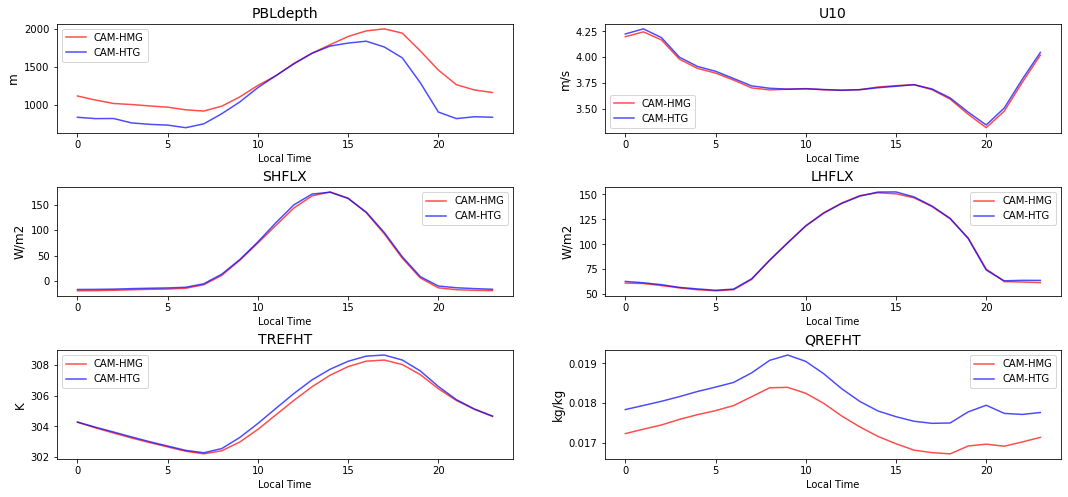

In [23]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])
# ATM_varNames = np.asarray(['TGCLDLWP','U10','SHFLX','LHFLX','TREFHT','RHREFHT'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):       
    axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        

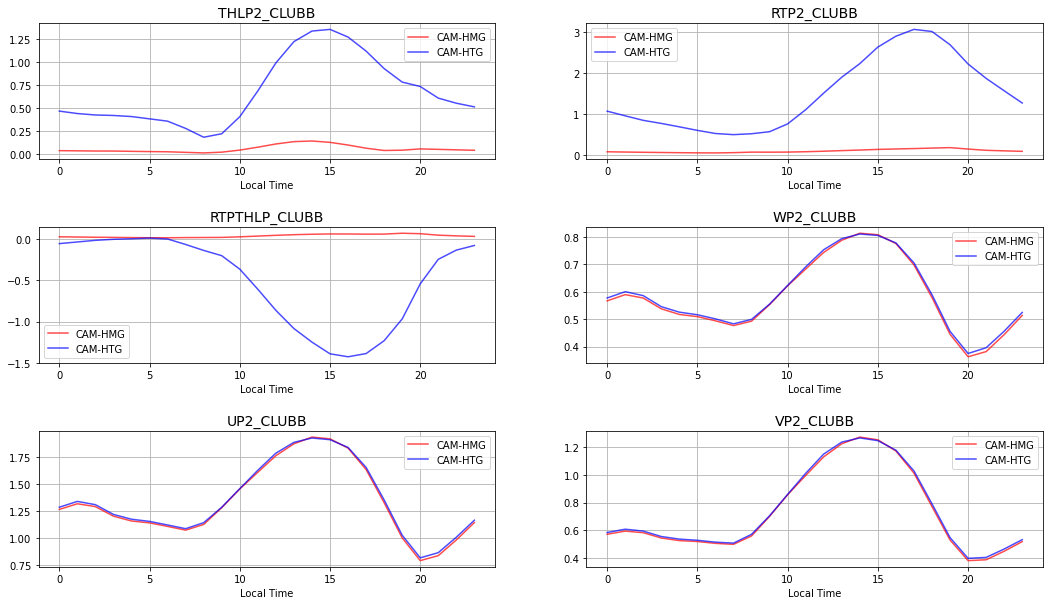

In [24]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG')
    
    else: 
        axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
    
        

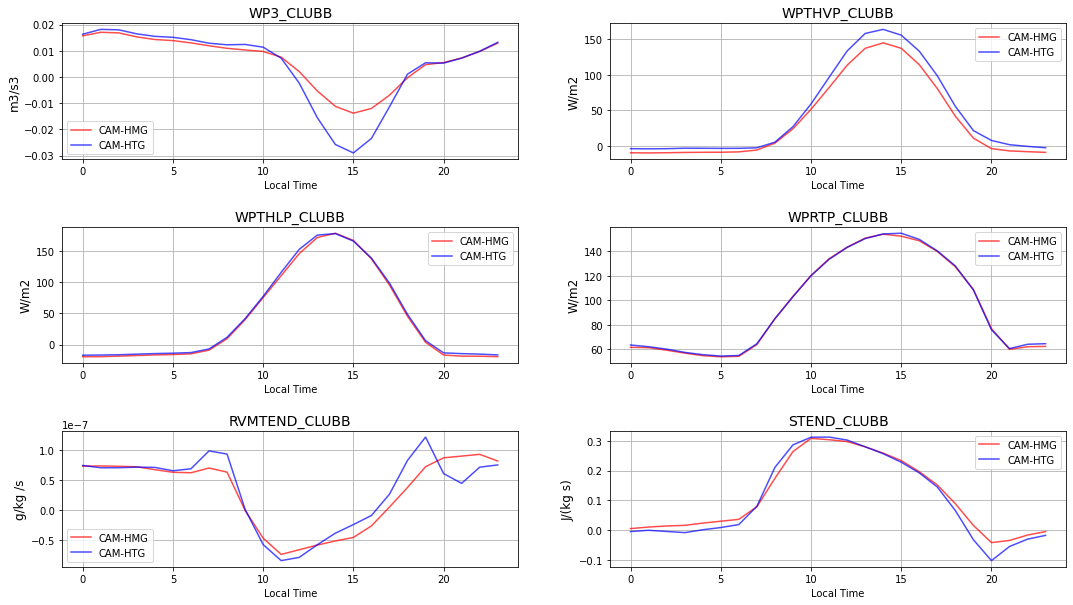

In [25]:
fig,axs = plt.subplots(3,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-2,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-2,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG')
    
    else: 
        axs[iVar].plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values[:,-1,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values[:,-1,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    axs[iVar].grid()
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
        

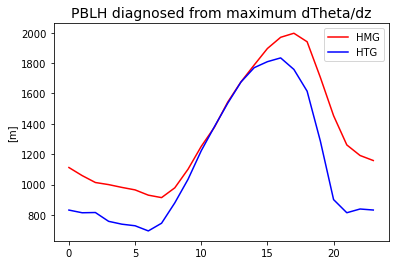

In [26]:
plt.plot(hourlyMean_HMG.hour.values, hourlyMean_HMG.PBLdepth.values, 'r', label='HMG')
plt.plot(hourlyMean_HTG.hour.values, hourlyMean_HTG.PBLdepth.values, 'b', label='HTG')
# plt.title('PBLH diagnosed from maximum dQ/dz',fontsize=14)
plt.title('PBLH diagnosed from maximum dTheta/dz',fontsize=14)
plt.ylabel('[m]')
plt.legend()


Text(0.5, 1.0, 'std(ET) from patch level')

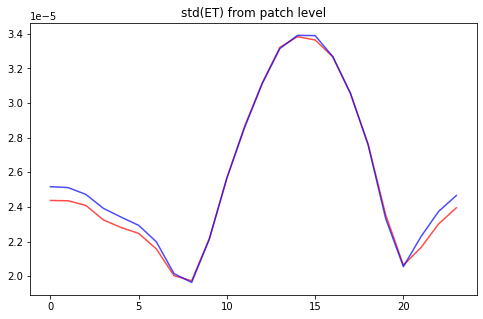

In [27]:
## Are there patches that have peaks in ET that might match above 

fig,axs = plt.subplots(1,1, figsize=(8,5))

axs.plot(hourlyMean_HMG.hour.values, np.squeeze(hourlyMeanCLM_HMG['stdET'].values),
          'r-', alpha=0.7, label='CAM-HMG')
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['stdET'].values),
          'b-', alpha=0.7, label='CAM-HTG')

axs.set_title('std(ET) from patch level')


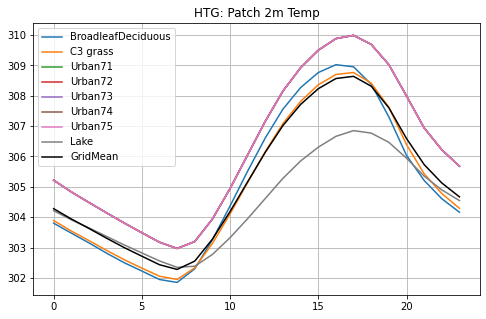

In [32]:
fig,axs = plt.subplots(1,1, figsize=(8,5))

for iPatch in range(len(hourlyMeanCLMpatch_HTG.pft.values)):
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
    
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['TSA'].values),'k-', label='GridMean')

axs.set_title('HTG: Patch 2m Temp')
axs.legend()

axs.grid()


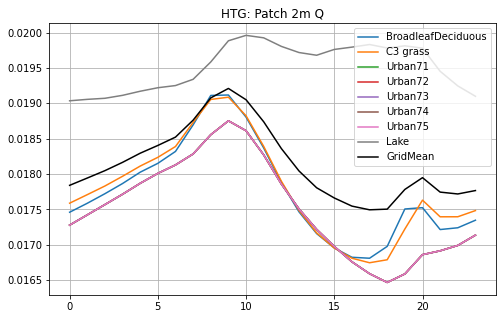

In [33]:
fig,axs = plt.subplots(1,1, figsize=(8,5))

for iPatch in range(len(hourlyMeanCLMpatch_HTG.pft.values)):
    axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLMpatch_HTG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs.plot(hourlyMean_HTG.hour.values, np.squeeze(hourlyMeanCLM_HTG['Q2M'].values),'k-', label='GridMean')

axs.set_title('HTG: Patch 2m Q')
axs.legend()

axs.grid()



Text(0, 0.5, 'hPa')

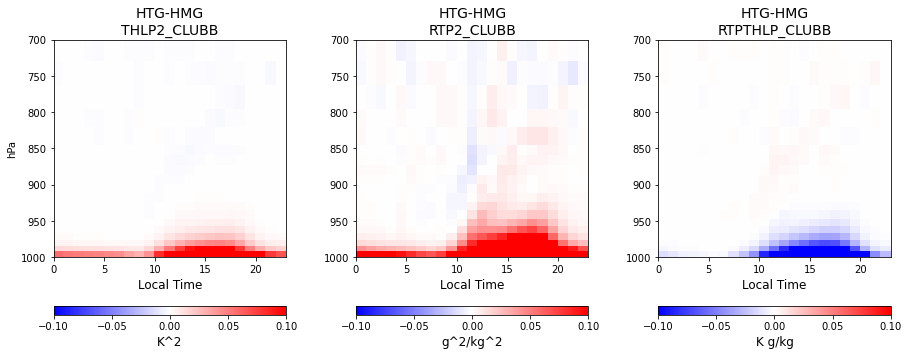

In [38]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])


# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze(diffVar.transpose()),
                             vmin=-0.1, vmax=0.1, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[ATM_varNames[iVar]].units,fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')


Text(0, 0.5, 'hPa')

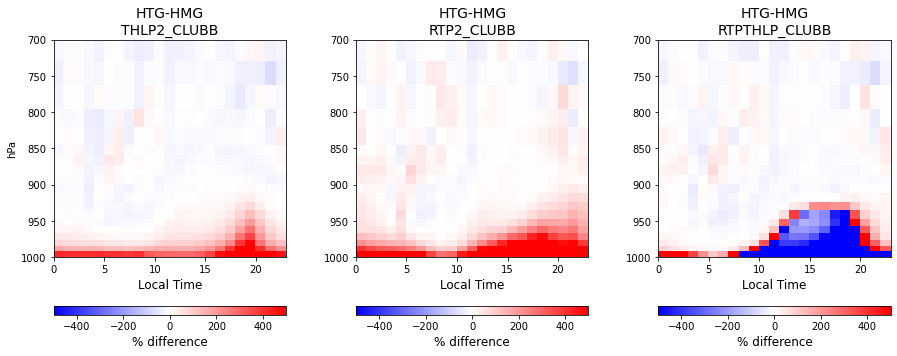

In [40]:
## Plot as percent difference rather than raw difference as above

fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)/hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar*100.0).transpose()),
                             vmin=-500, vmax=500, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label('% difference',fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')



Text(0, 0.5, 'hPa')

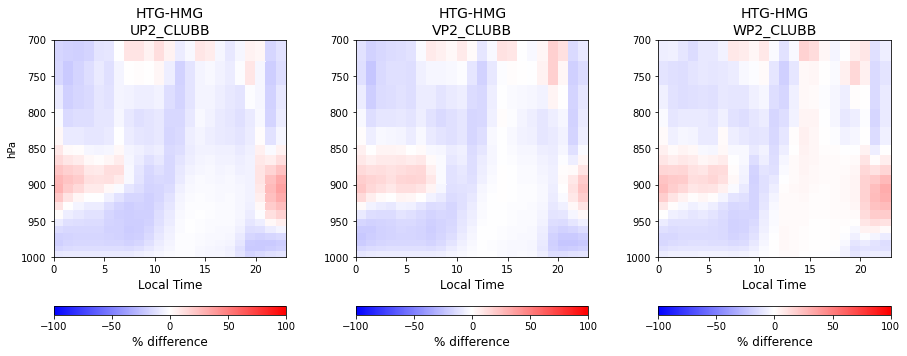

In [42]:
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)/hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar*100.0).transpose()),
                             vmin=-100, vmax=100, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label('% difference',fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')



Text(0, 0.5, 'hPa')

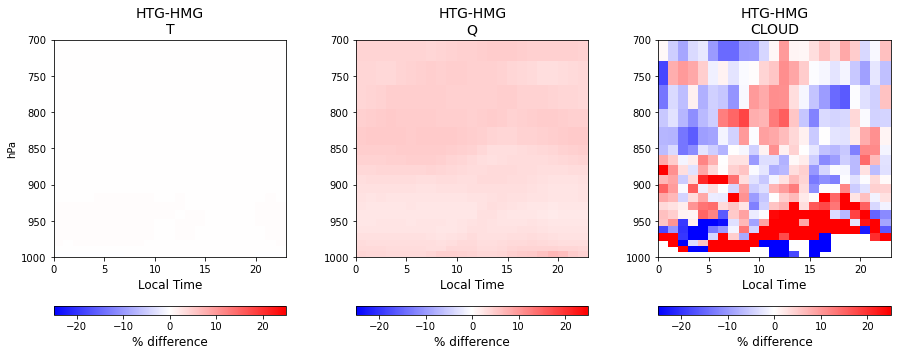

In [29]:
## Plot as percent difference rather than raw difference as above

fig,axs = plt.subplots(1,3, figsize=(15,4))
axs = axs.ravel()
fig.subplots_adjust(wspace=0.3)

# ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
ATM_varNames = np.asarray(['T','Q','CLOUD'])

# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(3):
    diffVar = (hourlyMean_HTG[ATM_varNames[iVar]].values - hourlyMean_HMG[ATM_varNames[iVar]].values)/hourlyMean_HMG[ATM_varNames[iVar]].values

    contour_plot = axs[iVar].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              np.squeeze((diffVar*100.0).transpose()),
                             vmin=-25, vmax=25, cmap='bwr')
    # Add colorbar 
    ax_position = axs[iVar].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.2, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label('% difference',fontsize=12)

    axs[iVar].invert_yaxis()
    axs[iVar].set_xlabel('Local Hour', fontsize=12)
    axs[iVar].set_title('HTG-HMG\n'+ATM_varNames[iVar], fontsize=14)
    axs[iVar].set_xlabel('Local Time',fontsize=12)
    axs[iVar].set_ylim([1000,700])

axs[0].set_ylabel('hPa')




#### Bin by some controlling variable (i.e., precip or soil moisture along x axis), then plot profiles of different things that way

In [38]:
def binByVar_plotProfiles(bins, controlVar, respondVar, startHr, endHr, cmin):
    
    # Select which levels array to use
    if np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.ilev.values): 
        nLevs  = len(HTGcamDS_local.ilev.values)
        levSel = 'ilev'
    elif np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.lev.values):
        nLevs  = len(HTGcamDS_local.lev.values)
        levSel = 'lev'

    binnedRespondVar_HTG = np.full([len(bins)+1,24,nLevs], np.nan)
    binnedRespondVar_HMG = np.full([len(bins)+1,24,nLevs], np.nan)

    ## Get binned data
    for iBin in range(len(bins)+1):
        if iBin==0:
            selBinHTG = np.where(HTGclmDS_local[controlVar].values<bins[0])[0]
            selBinHMG = np.where(HMGclmDS_local[controlVar].values<bins[0])[0]
        elif iBin==len(SMbins):
            selBinHTG = np.where(HTGclmDS_local[controlVar].values>=bins[-1])[0]
            selBinHMG = np.where(HMGclmDS_local[controlVar].values>=bins[-1])[0]
        else: 
            selBinHTG = np.where( (HTGclmDS_local[controlVar].values>=bins[iBin-1]) &
                                  (HTGclmDS_local[controlVar].values<bins[iBin]) )[0]
            selBinHMG = np.where( (HMGclmDS_local[controlVar].values>=bins[iBin-1]) &
                                  (HMGclmDS_local[controlVar].values<bins[iBin]) )[0]

        # Now select the DS for that SM bin: 
        HTGcamDS_local_SMbin = HTGcamDS_local.isel(time=selBinHTG)
        HTGclmDS_local_SMbin = HTGclmDS_local.isel(time=selBinHTG)

        HMGcamDS_local_SMbin = HMGcamDS_local.isel(time=selBinHMG)
        HMGclmDS_local_SMbin = HMGclmDS_local.isel(time=selBinHMG)

        # Get mean values as function of hour of day
        hourlyMean_selBin_HTG = HTGcamDS_local_SMbin.groupby("time.hour").mean()
        hourlyMean_selBin_HMG = HMGcamDS_local_SMbin.groupby("time.hour").mean()

        binnedRespondVar_HTG[iBin,hourlyMean_selBin_HTG.hour.values,:] = np.squeeze(hourlyMean_selBin_HTG[respondVar])
        binnedRespondVar_HMG[iBin,hourlyMean_selBin_HMG.hour.values,:] = np.squeeze(hourlyMean_selBin_HMG[respondVar])

    ## Plot binned data as mean over some period of day    
    binnedRespondVar_HTG_timeSel = np.nanmean(binnedRespondVar_HTG[:,startHr:endHr+1,:], axis=1)
    binnedRespondVar_HMG_timeSel = np.nanmean(binnedRespondVar_HMG[:,startHr:endHr+1,:], axis=1)

    ## Now do the plotting
    binRes = bins[2]-bins[1]
    binEdges = np.insert(bins, 0, bins[0]-binRes)
    binEdges = np.append(binEdges, bins[-1]+binRes)
    
    diffVar = binnedRespondVar_HTG_timeSel - binnedRespondVar_HMG_timeSel
    
    fig,axs = plt.subplots(1,1, figsize=(16,8))
    contour_plot = axs.pcolormesh(binEdges, HTGcamDS_local[levSel].values, diffVar.transpose(),
                                 vmin=cmin, vmax=-cmin, cmap='bwr')
    # Add colorbar 
    ax_position = axs.get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[respondVar].units,fontsize=12)

    # Control x ticks
    tick_labels = np.round(binEdges,2).astype(str)
    tick_labels[0]  = '<'+str(bins[0])
    tick_labels[-1] = '>'+str(bins[-1])
    axs.set_xticks(binEdges)
    axs.set_xticklabels(tick_labels)
    
    axs.invert_yaxis()
    axs.set_xlabel(controlVar+' bin ['+HMGclmDS_local[controlVar].units+']')
    axs.set_ylabel('hPa')
    axs.set_title('HTG-HMG\n'+respondVar+' (Mean over hours '+str(startHr)+'-'+str(endHr)+')')

    plt.show()
    
    return(levSel)

In [39]:
def binByVarDiff_plotProfiles(bins, controlVar, respondVar, startHr, endHr, cmin):
    
    # Select which levels array to use
    if np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.ilev.values): 
        nLevs  = len(HTGcamDS_local.ilev.values)
        levSel = 'ilev'
    elif np.shape(HTGcamDS_local[respondVar].values)[1]==len(HTGcamDS_local.lev.values):
        nLevs  = len(HTGcamDS_local.lev.values)
        levSel = 'lev'

    # Get difference between controlVar in HTG and HMG (does sign matter?)
    diffCtrlVar = np.abs(HTGclmDS_local[controlVar].values - HMGclmDS_local[controlVar].values)

    # Now bin those differences 
    binnedRespondVar_HTG = np.full([len(bins)+1,24,nLevs], np.nan)
    binnedRespondVar_HMG = np.full([len(bins)+1,24,nLevs], np.nan)

    ## Get binned data
    for iBin in range(len(bins)+1):
        if iBin==0:
            selBinHTG = np.where(diffCtrlVar<bins[0])[0]
        elif iBin==len(SMbins):
            selBinHTG = np.where(diffCtrlVar>=bins[-1])[0]
        else: 
            selBinHTG = np.where( (diffCtrlVar>=bins[iBin-1]) &
                                  (diffCtrlVar<bins[iBin]) )[0]

        if len(selBinHTG>0):
            # Now select the DS for that SM bin: 
            HTGcamDS_local_SMbin = HTGcamDS_local.isel(time=selBinHTG)
            HTGclmDS_local_SMbin = HTGclmDS_local.isel(time=selBinHTG)

            HMGcamDS_local_SMbin = HMGcamDS_local.isel(time=selBinHTG)
            HMGclmDS_local_SMbin = HMGclmDS_local.isel(time=selBinHTG)

            # Get mean values as function of hour of day
            hourlyMean_selBin_HTG = HTGcamDS_local_SMbin.groupby("time.hour").mean()
            hourlyMean_selBin_HMG = HMGcamDS_local_SMbin.groupby("time.hour").mean()

            binnedRespondVar_HTG[iBin,hourlyMean_selBin_HTG.hour.values,:] = np.squeeze(hourlyMean_selBin_HTG[respondVar])
            binnedRespondVar_HMG[iBin,hourlyMean_selBin_HMG.hour.values,:] = np.squeeze(hourlyMean_selBin_HMG[respondVar])
        else: 
            binnedRespondVar_HTG[iBin,:,:] = np.nan
            binnedRespondVar_HMG[iBin,:,:] = np.nan



    ## Plot binned data as mean over some period of day    
    binnedRespondVar_HTG_timeSel = np.nanmean(binnedRespondVar_HTG[:,startHr:endHr+1,:], axis=1)
    binnedRespondVar_HMG_timeSel = np.nanmean(binnedRespondVar_HMG[:,startHr:endHr+1,:], axis=1)

    ## Now do the plotting
    binRes = bins[2]-bins[1]
    binEdges = np.insert(bins, 0, bins[0]-binRes)
    binEdges = np.append(binEdges, bins[-1]+binRes)
    
    diffVar = binnedRespondVar_HTG_timeSel - binnedRespondVar_HMG_timeSel
    
    fig,axs = plt.subplots(1,1, figsize=(16,8))
    contour_plot = axs.pcolormesh(binEdges, HTGcamDS_local[levSel].values, diffVar.transpose(),
                                 vmin=cmin, vmax=-cmin, cmap='bwr')
    # Add colorbar 
    ax_position = axs.get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(HMGcamDS_local[respondVar].units,fontsize=12)

    # Control x ticks
    tick_labels = np.round(binEdges,2).astype(str)
    tick_labels[0]  = '<'+str(bins[0])
    tick_labels[-1] = '>'+str(bins[-1])
    axs.set_xticks(binEdges)
    axs.set_xticklabels(tick_labels)
    
    axs.invert_yaxis()
    axs.set_xlabel(controlVar+' (|HTG-HMG|) ['+HMGclmDS_local[controlVar].units+']')
    axs.set_ylabel('hPa')
    axs.set_title('HTG-HMG\n'+respondVar+' (Mean over hours '+str(startHr)+'-'+str(endHr)+')')

    plt.show()
    
    return(levSel)

(array([   0.,    0.,  187.,  589., 1050., 1491., 1798., 1551., 1927.,
        1542., 1613., 1546., 1097.,  981.,  808.,  893.,  549.,  483.,
         362.,  161.,  120.,   33.,    8.,    3.]),
 array([15.  , 16.25, 17.5 , 18.75, 20.  , 21.25, 22.5 , 23.75, 25.  ,
        26.25, 27.5 , 28.75, 30.  , 31.25, 32.5 , 33.75, 35.  , 36.25,
        37.5 , 38.75, 40.  , 41.25, 42.5 , 43.75, 45.  ]),
 <BarContainer object of 24 artists>)

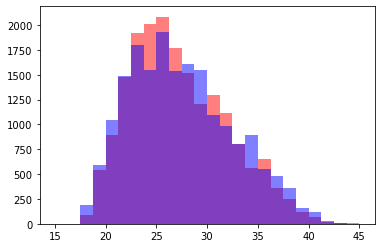

In [44]:
SMbins     = np.linspace(15, 45, 25)
controlVar = 'SOILWATER_10CM'
plt.hist(HMGclmDS_local[controlVar], bins=SMbins, facecolor='r',alpha=0.5,label='HMG')
plt.hist(HTGclmDS_local[controlVar], bins=SMbins, facecolor='b',alpha=0.5,label='HTG')


(array([  61.,  209.,  491.,  827., 1052., 1105., 1129., 1260., 1303.,
        1506., 1830., 1950., 1720., 1212.,  778.,  627.,  517.,  351.,
         260.,  208.,  159.,  123.,   56.,   24.]),
 array([1.00000000e-06, 3.45833333e-06, 5.91666667e-06, 8.37500000e-06,
        1.08333333e-05, 1.32916667e-05, 1.57500000e-05, 1.82083333e-05,
        2.06666667e-05, 2.31250000e-05, 2.55833333e-05, 2.80416667e-05,
        3.05000000e-05, 3.29583333e-05, 3.54166667e-05, 3.78750000e-05,
        4.03333333e-05, 4.27916667e-05, 4.52500000e-05, 4.77083333e-05,
        5.01666667e-05, 5.26250000e-05, 5.50833333e-05, 5.75416667e-05,
        6.00000000e-05]),
 <BarContainer object of 24 artists>)

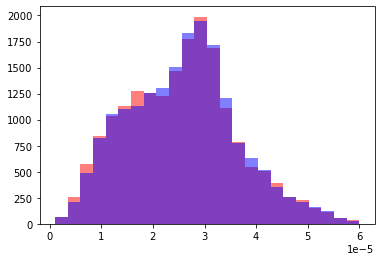

In [42]:
binsET     = np.linspace(0.1e-5, 6e-5, 25)
controlVar = 'stdET'
plt.hist(HMGclmDS_local[controlVar],bins=binsET, facecolor='r',alpha=0.5,label='HMG')
plt.hist(HTGclmDS_local[controlVar],bins=binsET, facecolor='b',alpha=0.5,label='HTG')


In [45]:
SMbins     = np.linspace(15, 45, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'UP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVar_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)


ValueError: hour must not be empty

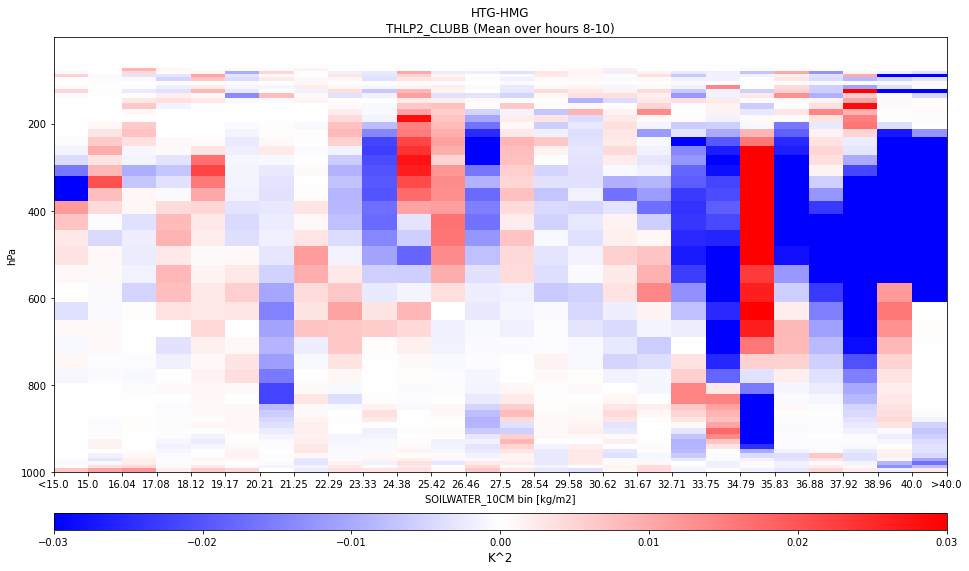

'ilev'

In [566]:
SMbins     = np.linspace(15, 40, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'THLP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.03

binByVar_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)



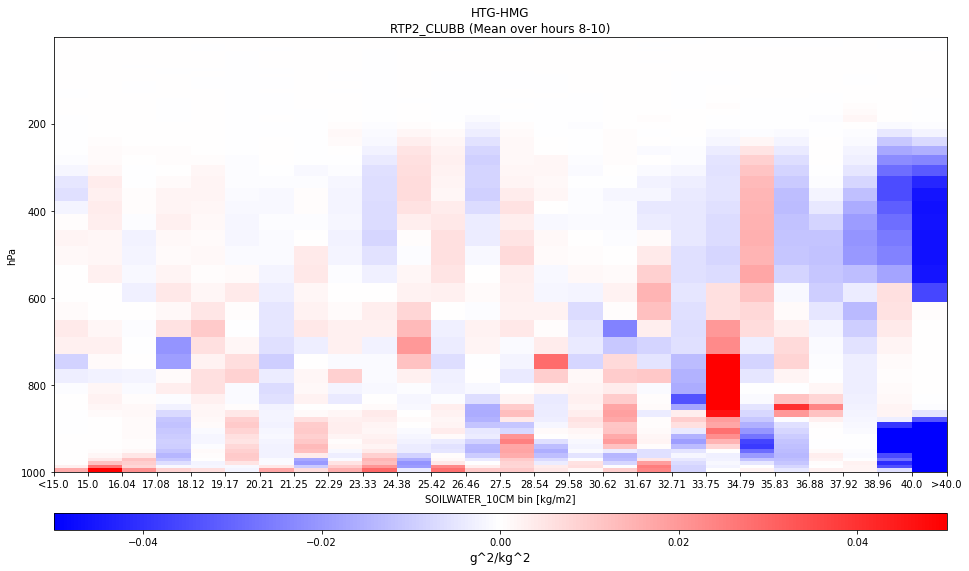

'ilev'

In [567]:
SMbins     = np.linspace(15, 40, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'RTP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVar_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)


**But maybe the bigger interest is where the HTG and HMG control values really diverge...**

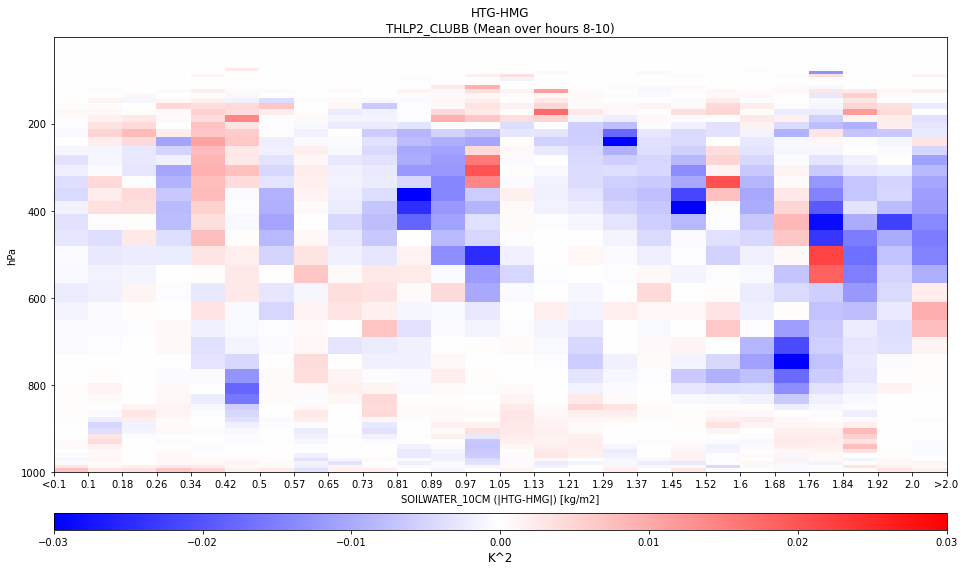

'ilev'

In [100]:
## What if we bin by the *difference* in soil moisture?
SMbins     = np.linspace(0.1, 2, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'THLP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.03

binByVarDiff_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)


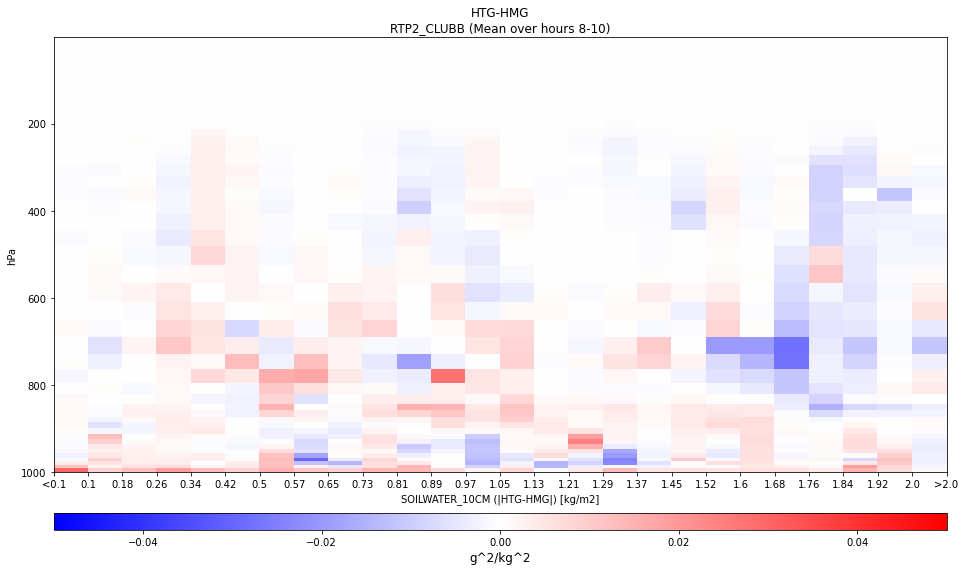

'ilev'

In [101]:
## What if we bin by the *difference* in soil moisture?
SMbins     = np.linspace(0.1, 2, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'RTP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVarDiff_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)

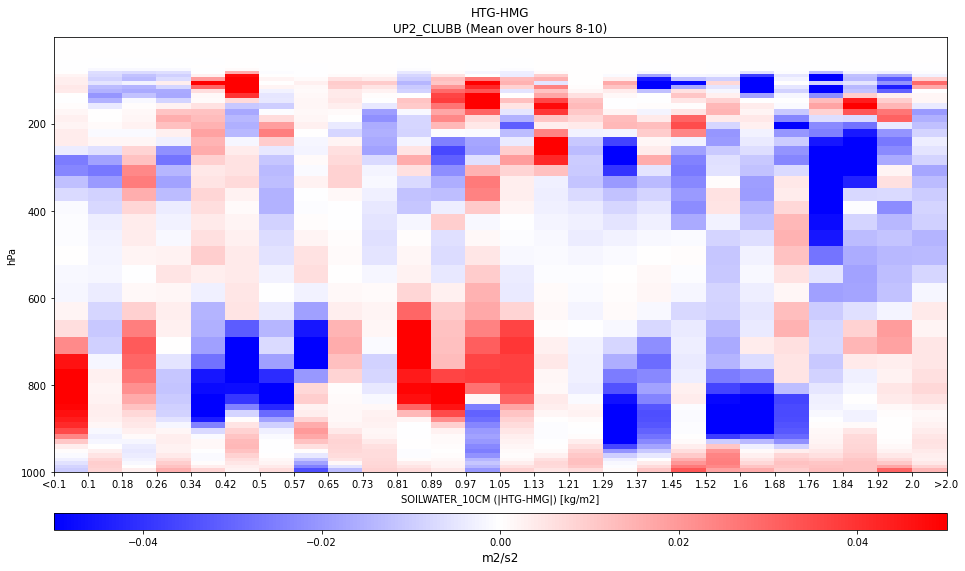

'ilev'

In [102]:
## What if we bin by the *difference* in soil moisture?
SMbins     = np.linspace(0.1, 2, 25)
controlVar = 'SOILWATER_10CM'
respondVar = 'UP2_CLUBB'
startHr    = 8
endHr      = 10 
cmin       = -0.05

binByVarDiff_plotProfiles(SMbins, controlVar, respondVar, startHr, endHr, cmin)

**Would this all view better with actual profiles??** <br>
*Use DAILY MEANS*

In [43]:
## Get daily means
HMGcamDS_localDailyMean = HMGcamDS_local.groupby('year_month_day').mean()
HTGcamDS_localDailyMean = HTGcamDS_local.groupby('year_month_day').mean()

HMGclmDS_localDailyMean = HMGclmDS_local.groupby('year_month_day').mean()
HTGclmDS_localDailyMean = HTGclmDS_local.groupby('year_month_day').mean()

## Add in daily total rain for fun... 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()

# Add to daily mean arrays above
HMGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HMGcamDS_localDailySum['PRECT_mmPerDT'].values)
HTGcamDS_localDailyMean['PRECTdailySum'] = (('year_month_day','lat','lon'), HTGcamDS_localDailySum['PRECT_mmPerDT'].values)


In [44]:
# So what if we take, say, percentiles of a controlVar 
controlVar = 'SOILWATER_10CM'
# controlVar = 'stdET'
pctSel     = np.arange(10,100,10) 

HTG_pctCtrlValues = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSel)
HMG_pctCtrlValues = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSel)

pctSelThirds     = np.asarray([33.33, 66.66]) 
HTG_pctCtrlValuesThirds = np.percentile(HTGclmDS_localDailyMean[controlVar].values, pctSelThirds)
HMG_pctCtrlValuesThirds = np.percentile(HMGclmDS_localDailyMean[controlVar].values, pctSelThirds)

# ## controlVar in CAM
# controlVar = 'PRECTdailySum'
# pctSel     = np.arange(10,100,10) 

# HTG_pctCtrlValues = np.percentile(HTGcamDS_localDailyMean[controlVar].values, pctSel)
# HMG_pctCtrlValues = np.percentile(HMGcamDS_localDailyMean[controlVar].values, pctSel)

# pctSelThirds     = np.asarray([33.33, 66.66]) 
# HTG_pctCtrlValuesThirds = np.percentile(HTGcamDS_localDailyMean[controlVar].values, pctSelThirds)
# HMG_pctCtrlValuesThirds = np.percentile(HMGcamDS_localDailyMean[controlVar].values, pctSelThirds)



In [45]:
## Maybe we do want consistent bin definitions, at least? 
binSelSame = np.full([len(pctSel)], np.nan)
for iBin in range(len(pctSel)):
    binSelSame[iBin] = np.nanmean([HTG_pctCtrlValues[iBin], HMG_pctCtrlValues[iBin]])
    
## Maybe we do want consistent bin definitions, at least? 
# for Thirds...
binSelSameThirds = np.full([len(pctSelThirds)], np.nan)
for iBin in range(len(pctSelThirds)):
    binSelSameThirds[iBin] = np.nanmean([HTG_pctCtrlValuesThirds[iBin], HMG_pctCtrlValuesThirds[iBin]])

print('Bottom third cutoff: %.2f' % (binSelSameThirds[0]))
print('Top third cutoff: %.2f' % (binSelSameThirds[1]))  

Bottom third cutoff: 24.74
Top third cutoff: 29.28


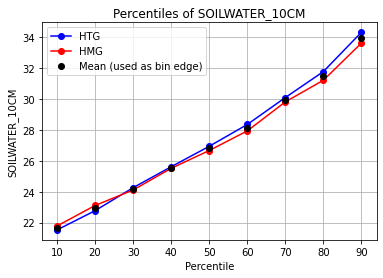

In [46]:
plt.plot(pctSel, HTG_pctCtrlValues, 'b-o', label='HTG')
plt.plot(pctSel, HMG_pctCtrlValues, 'r-o', label='HMG')
plt.plot(pctSel, binSelSame, 'ko', label='Mean (used as bin edge)')
plt.xlabel('Percentile')
plt.ylabel(controlVar)
plt.title('Percentiles of '+controlVar)
plt.legend()
plt.grid()

Now isolate arrays that correspond to those percentiles...

In [47]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnPercentile(fullDS, pctDS):
    iTimes = []
    
    for iTime in range(len(pctDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==pctDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==pctDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==pctDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayPct = fullDS.isel(time=iTimes)
    
    return(DS_dayPct)


In [48]:
# Now get all the times where daily mean controlVar falls into each bin

binSel = binSelSame
# binSel = HTG_pctCtrlValues
HTGbin0 = np.where((HTGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HTGbin1 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[0]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[1]))[0]
HTGbin2 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[1]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[2]))[0]
HTGbin3 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[2]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[3]))[0]
HTGbin4 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[3]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[4]))[0]
HTGbin5 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[4]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[5]))[0]
HTGbin6 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[5]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[6]))[0]
HTGbin7 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[6]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[7]))[0]
HTGbin8 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[7]) &
                   (HTGclmDS_localDailyMean[controlVar].values <= binSel[8]))[0]
HTGbin9 = np.where((HTGclmDS_localDailyMean[controlVar].values >  binSel[8]))[0]


binSel = binSelSame
# binSel = HMG_pctCtrlValues
HMGbin0 = np.where((HMGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]  # bin 0=10th pct
HMGbin1 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[0]) &    # bin 10-20th pct
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[1]))[0]
HMGbin2 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[1]) &    #20-30
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[2]))[0]
HMGbin3 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[2]) &    #30-40
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[3]))[0]
HMGbin4 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[3]) &    #40-50
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[4]))[0]
HMGbin5 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[4]) &    #50-60
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[5]))[0] 
HMGbin6 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[5]) &    #60-70
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[6]))[0]
HMGbin7 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[6]) &    #70-80
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[7]))[0]
HMGbin8 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[7]) &    #80-90
                   (HMGclmDS_localDailyMean[controlVar].values <= binSel[8]))[0]
HMGbin9 = np.where((HMGclmDS_localDailyMean[controlVar].values >  binSel[8]))[0]  #90-100


binSel = binSelSameThirds
HMGbin_bot30 = np.where((HMGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HMGbin_top30 = np.where((HMGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]

HTGbin_bot30 = np.where((HTGclmDS_localDailyMean[controlVar].values <= binSel[0]))[0]
HTGbin_top30 = np.where((HTGclmDS_localDailyMean[controlVar].values > binSel[1]))[0]



In [287]:
# ## ControlVar in CAM 

# binSel = binSelSame
# # binSel = HTG_pctCtrlValues
# HTGbin0 = np.where((HTGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HTGbin1 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[0]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[1]))[0]
# HTGbin2 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[1]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[2]))[0]
# HTGbin3 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[2]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[3]))[0]
# HTGbin4 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[3]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[4]))[0]
# HTGbin5 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[4]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[5]))[0]
# HTGbin6 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[5]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[6]))[0]
# HTGbin7 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[6]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[7]))[0]
# HTGbin8 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[7]) &
#                    (HTGcamDS_localDailyMean[controlVar].values <= binSel[8]))[0]
# HTGbin9 = np.where((HTGcamDS_localDailyMean[controlVar].values >  binSel[8]))[0]


# binSel = binSelSame
# # binSel = HMG_pctCtrlValues
# HMGbin0 = np.where((HMGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HMGbin1 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[0]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[1]))[0]
# HMGbin2 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[1]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[2]))[0]
# HMGbin3 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[2]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[3]))[0]
# HMGbin4 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[3]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[4]))[0]
# HMGbin5 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[4]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[5]))[0]
# HMGbin6 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[5]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[6]))[0]
# HMGbin7 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[6]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[7]))[0]
# HMGbin8 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[7]) &
#                    (HMGcamDS_localDailyMean[controlVar].values <= binSel[8]))[0]
# HMGbin9 = np.where((HMGcamDS_localDailyMean[controlVar].values >  binSel[8]))[0]

# binSel = binSelSameThirds
# HMGbin_bot30 = np.where((HMGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HMGbin_top30 = np.where((HMGcamDS_localDailyMean[controlVar].values > binSel[1]))[0]

# HTGbin_bot30 = np.where((HTGcamDS_localDailyMean[controlVar].values <= binSel[0]))[0]
# HTGbin_top30 = np.where((HTGcamDS_localDailyMean[controlVar].values > binSel[1]))[0]



In [326]:
## Check how well days agree between HMG/HTG bins


A = HTGclmDS_localDailyMean.isel(year_month_day=HTGbin0).year_month_day.values
B = HMGclmDS_localDailyMean.isel(year_month_day=HMGbin0).year_month_day.values

print('HTG day            HMG day')
for iDay in range(len(HTGbin0)):
    print(A[iDay],'     ',B[iDay])


HTG day            HMG day
(2015, 6, 16)       (2015, 6, 15)
(2015, 7, 7)       (2015, 6, 16)
(2015, 7, 9)       (2015, 7, 8)
(2015, 7, 21)       (2015, 7, 9)
(2015, 7, 30)       (2015, 7, 21)
(2015, 8, 5)       (2015, 7, 30)
(2015, 8, 18)       (2015, 8, 5)
(2015, 8, 22)       (2015, 8, 18)
(2015, 8, 23)       (2015, 8, 22)
(2015, 8, 24)       (2015, 8, 23)
(2016, 6, 2)       (2015, 8, 24)
(2016, 6, 13)       (2016, 6, 2)
(2016, 6, 14)       (2016, 6, 13)
(2016, 6, 16)       (2016, 6, 14)
(2016, 7, 9)       (2016, 7, 2)
(2016, 7, 15)       (2016, 7, 9)
(2016, 7, 30)       (2016, 7, 15)
(2016, 7, 31)       (2016, 7, 28)
(2016, 8, 6)       (2016, 7, 31)
(2016, 8, 9)       (2016, 8, 7)
(2016, 8, 13)       (2016, 8, 9)
(2016, 8, 27)       (2016, 8, 26)
(2017, 6, 2)       (2016, 8, 27)
(2017, 6, 4)       (2017, 6, 2)
(2017, 7, 4)       (2017, 7, 4)
(2017, 8, 10)       (2017, 8, 26)
(2017, 8, 28)       (2017, 8, 28)


In [49]:
## Now get those days out of full arrays
HTGclm_10pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin0))
HTGclm_20pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin1))
HTGclm_30pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin2))
HTGclm_40pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin3))
HTGclm_50pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin4))
HTGclm_60pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin5))
HTGclm_70pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin6))
HTGclm_80pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin7))
HTGclm_90pct  = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin8))
HTGclm_100pct = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin9))

HMGclm_10pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin0))
HMGclm_20pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin1))
HMGclm_30pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin2))
HMGclm_40pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin3))
HMGclm_50pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin4))
HMGclm_60pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin5))
HMGclm_70pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin6))
HMGclm_80pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin7))
HMGclm_90pct  = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin8))
HMGclm_100pct = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin9))



HTGcam_10pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0))
HTGcam_20pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1))
HTGcam_30pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2))
HTGcam_40pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3))
HTGcam_50pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4))
HTGcam_60pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5))
HTGcam_70pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6))
HTGcam_80pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7))
HTGcam_90pct  = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8))
HTGcam_100pct = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9))

HMGcam_10pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0))
HMGcam_20pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1))
HMGcam_30pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2))
HMGcam_40pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3))
HMGcam_50pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4))
HMGcam_60pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5))
HMGcam_70pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6))
HMGcam_80pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7))
HMGcam_90pct  = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8))
HMGcam_100pct = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9))



In [50]:
HMGcam_bot30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin_bot30))
HMGclm_bot30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin_bot30))

HTGcam_bot30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin_bot30))
HTGclm_bot30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin_bot30))


HMGcam_top30 = getTimes_basedOnPercentile(HMGcamDS_local, HMGcamDS_localDailyMean.isel(year_month_day=HMGbin_top30))
HMGclm_top30 = getTimes_basedOnPercentile(HMGclmDS_local, HMGclmDS_localDailyMean.isel(year_month_day=HMGbin_top30))

HTGcam_top30 = getTimes_basedOnPercentile(HTGcamDS_local, HTGcamDS_localDailyMean.isel(year_month_day=HTGbin_top30))
HTGclm_top30 = getTimes_basedOnPercentile(HTGclmDS_local, HTGclmDS_localDailyMean.isel(year_month_day=HTGbin_top30))



**What if we look at a few bins for their average daily response**

In [53]:
hourlyMean10_HTG  = HTGcam_10pct.groupby("time.hour").mean()
hourlyMean20_HTG  = HTGcam_20pct.groupby("time.hour").mean()
hourlyMean30_HTG  = HTGcam_30pct.groupby("time.hour").mean()
hourlyMean40_HTG  = HTGcam_40pct.groupby("time.hour").mean()
hourlyMean50_HTG  = HTGcam_50pct.groupby("time.hour").mean()
hourlyMean60_HTG  = HTGcam_60pct.groupby("time.hour").mean()
hourlyMean70_HTG  = HTGcam_70pct.groupby("time.hour").mean()
hourlyMean80_HTG  = HTGcam_80pct.groupby("time.hour").mean()
hourlyMean90_HTG  = HTGcam_90pct.groupby("time.hour").mean()
hourlyMean100_HTG = HTGcam_100pct.groupby("time.hour").mean()

hourlyMean10_HMG  = HMGcam_10pct.groupby("time.hour").mean()
hourlyMean20_HMG  = HMGcam_20pct.groupby("time.hour").mean()
hourlyMean30_HMG  = HMGcam_30pct.groupby("time.hour").mean()
hourlyMean40_HMG  = HMGcam_40pct.groupby("time.hour").mean()
hourlyMean50_HMG  = HMGcam_50pct.groupby("time.hour").mean()
hourlyMean60_HMG  = HMGcam_60pct.groupby("time.hour").mean()
hourlyMean70_HMG  = HMGcam_70pct.groupby("time.hour").mean()
hourlyMean80_HMG  = HMGcam_80pct.groupby("time.hour").mean()
hourlyMean90_HMG  = HMGcam_90pct.groupby("time.hour").mean()
hourlyMean100_HMG = HMGcam_100pct.groupby("time.hour").mean()



In [52]:
hourlyMeanBot30_HTG = HTGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HTG = HTGcam_top30.groupby("time.hour").mean()

hourlyMeanBot30_HMG = HMGcam_bot30.groupby("time.hour").mean()
hourlyMeanTop30_HMG = HMGcam_top30.groupby("time.hour").mean()



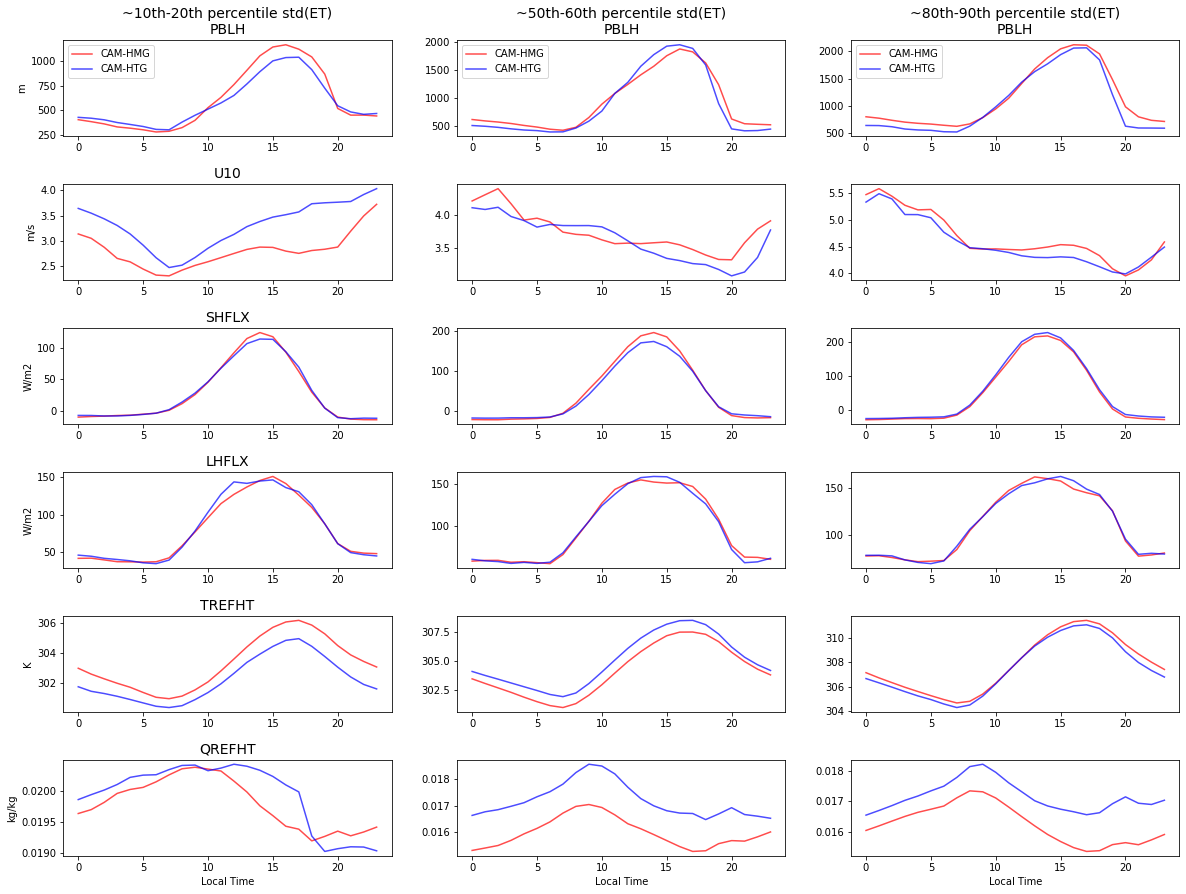

In [54]:
fig,axs = plt.subplots(6,3, figsize=(20,15))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLH','U10','SHFLX','LHFLX','TREFHT','QREFHT'])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 10th-20th percentile bin
    axs[iPlot].plot(hourlyMean20_HMG.hour.values, np.squeeze(hourlyMean20_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMean20_HTG.hour.values, np.squeeze(hourlyMean20_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
    
    ## Plot 50th-60th percentile bin
    axs[iPlot+1].plot(hourlyMean60_HMG.hour.values, np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMean60_HTG.hour.values, np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
    
    ## Plot 80th-90th percentile bin 
    axs[iPlot+2].plot(hourlyMean90_HMG.hour.values, np.squeeze(hourlyMean90_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+2].plot(hourlyMean90_HTG.hour.values, np.squeeze(hourlyMean90_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~10th-20th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~50th-60th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+2].set_title('~80th-90th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
        axs[iPlot+2].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
    
    iPlot = iPlot+3
        

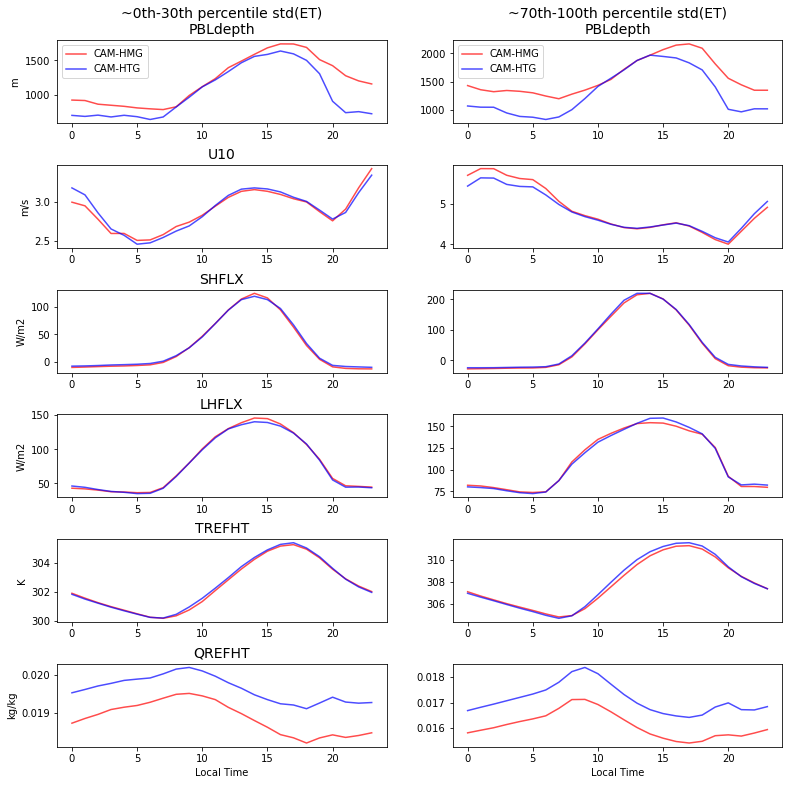

In [189]:
fig,axs = plt.subplots(6,2, figsize=(13,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])

yMax = np.asarray([2400, 7, 300, 300, 315, 0.022])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.012])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

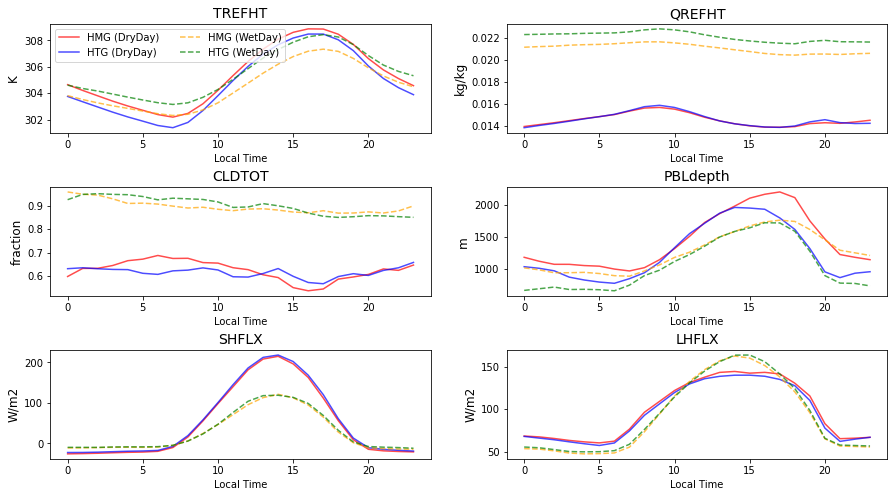

In [58]:
fig,axs = plt.subplots(3,2, figsize=(15,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

# ATM_varNames = np.asarray(['PBLdepth','U10','SHFLX','LHFLX','TREFHT','QREFHT'])
ATM_varNames = np.asarray(['TREFHT','QREFHT','CLDTOT','PBLdepth','SHFLX','LHFLX'])

for iVar in range(6):       
    axs[iVar].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='HMG (DryDay)')
    axs[iVar].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='HTG (DryDay)')
    
    axs[iVar].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                  '--',color='orange', alpha=0.7, label='HMG (WetDay)')
    axs[iVar].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                  '--',color='g', alpha=0.7, label='HTG (WetDay)')
    

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        
axs[0].legend(ncol=2)



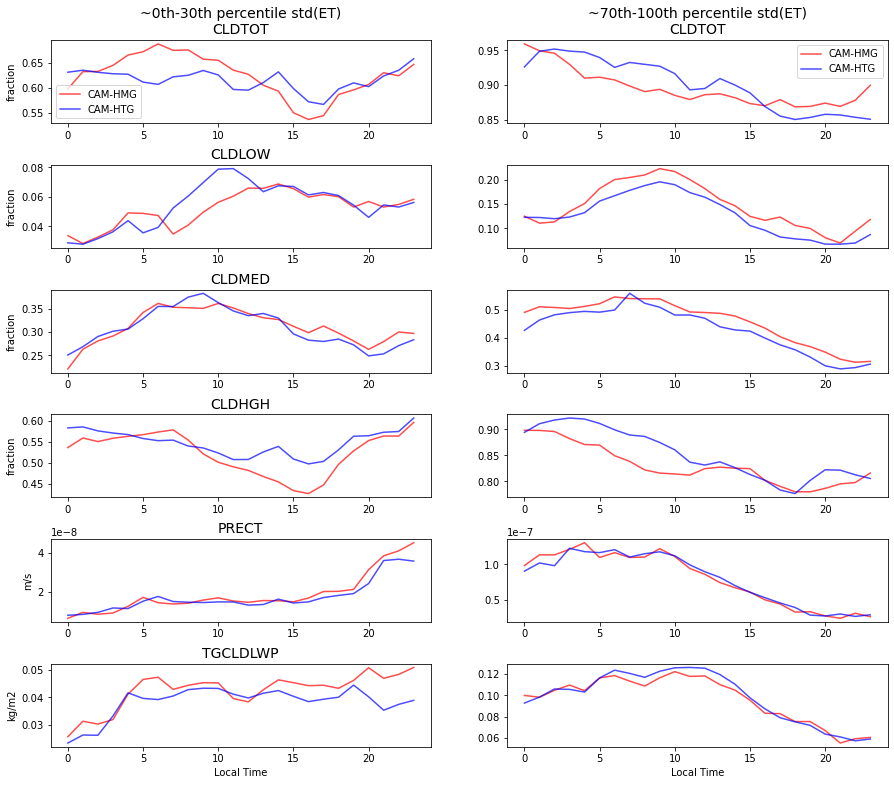

In [59]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['CLDTOT','CLDLOW','CLDMED','CLDHGH','PRECT','TGCLDLWP'])

yMax = np.asarray([2300, 7, 300, 300, 315, 0.025])
yMin = np.asarray([ 100, 2, -40, -40, 295, 0.001])

iPlot = 0
for iVar in range(6): 
    
    ## Plot 0-30th percentile bin
    axs[iPlot].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot].set_ylim([yMin[iVar], yMax[iVar]])
    
    ## Plot 70-100th percentile bin
    axs[iPlot+1].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG') 
#     axs[iPlot+1].set_ylim([yMin[iVar], yMax[iVar]])

    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    if ATM_varNames[iVar]=='PBLdepth':
        axs[iPlot].set_ylabel(HMGcamDS_local['PBLH'].units)
    else:
        axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()

    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
        

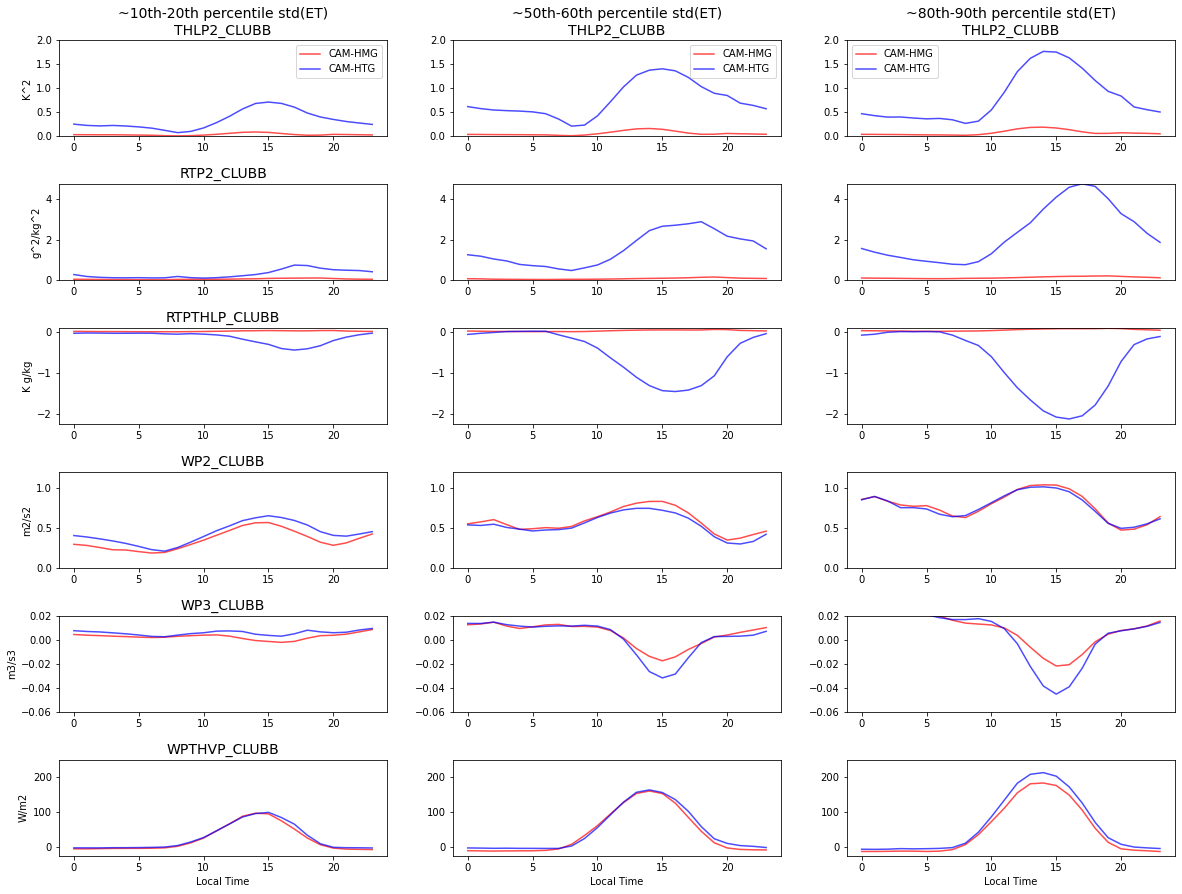

In [63]:
fig,axs = plt.subplots(6,3, figsize=(20,15))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
ylimMax = np.asarray([2.0, 4.75, 0.1, 1.2,  0.02, 250])
ylimMin = np.asarray([0.0, 0.0, -2.25, 0.0, -0.06, -25])

iPlot = 0
for iVar in range(6): 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
    ## Plot 10th-20th percentile bin
    axs[iPlot].plot(hourlyMean20_HMG.hour.values, np.squeeze(hourlyMean20_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMean20_HTG.hour.values, np.squeeze(hourlyMean20_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    ## Plot 50th-60th percentile bin
    axs[iPlot+1].plot(hourlyMean60_HMG.hour.values, np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMean60_HTG.hour.values, np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+1].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    ## Plot 80th-90th percentile bin 
    axs[iPlot+2].plot(hourlyMean90_HMG.hour.values, np.squeeze(hourlyMean90_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+2].plot(hourlyMean90_HTG.hour.values, np.squeeze(hourlyMean90_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+2].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~10th-20th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~50th-60th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+2].set_title('~80th-90th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
        axs[iPlot+2].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
    
    iPlot = iPlot+3
    

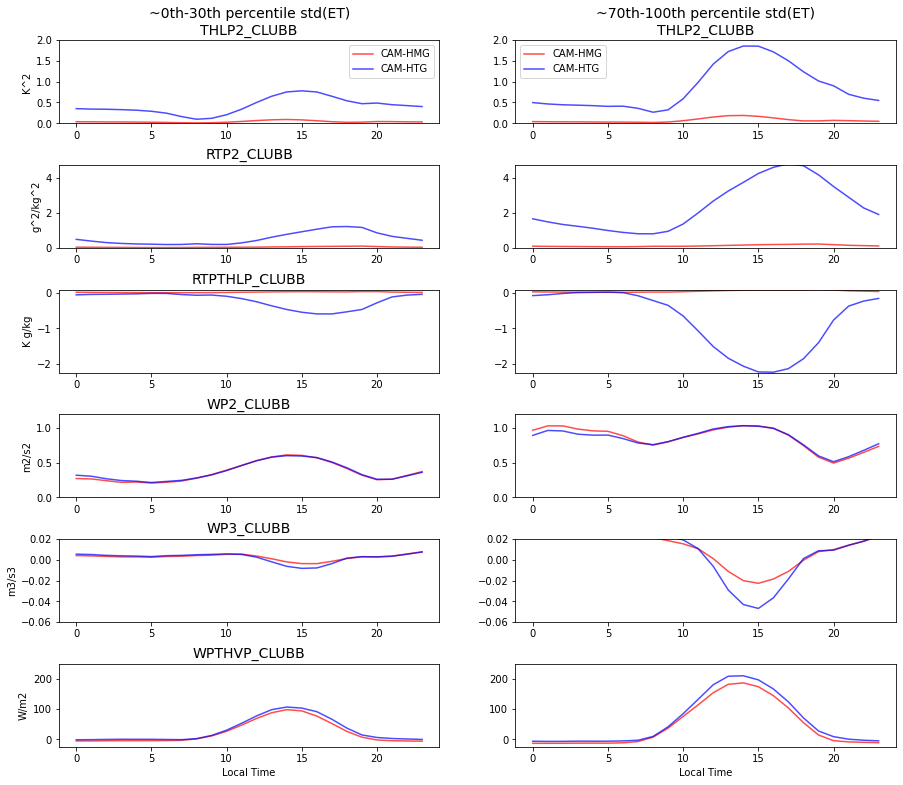

In [192]:
fig,axs = plt.subplots(6,2, figsize=(15,13))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
ylimMax = np.asarray([2.0, 4.75, 0.1, 1.2,  0.02, 250])
ylimMin = np.asarray([0.0, 0.0, -2.25, 0.0, -0.06, -25])

iPlot = 0
for iVar in range(6): 
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
    ## Plot 10th-20th percentile bin
    axs[iPlot].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    ## Plot 50th-60th percentile bin
    axs[iPlot+1].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlot+1].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='CAM-HTG') 
    axs[iPlot+1].set_ylim([ylimMin[iVar], ylimMax[iVar]])
    
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iPlot].set_ylabel(HMGcamDS_local[ATM_varNames[iVar]].units)
    
    
    if iVar==0:
        axs[iPlot].set_title('~0th-30th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~70th-100th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
        axs[iPlot].legend()
        axs[iPlot+1].legend()
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')

    
    iPlot = iPlot+2
    

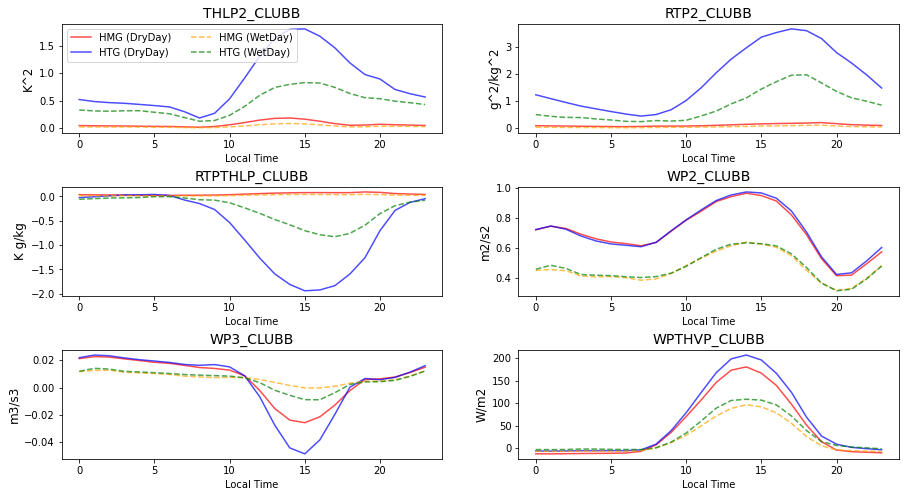

In [60]:
fig,axs = plt.subplots(3,2, figsize=(15,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])


for iVar in range(6):     
    if ATM_varNames[iVar]=='WP3_CLUBB':
        levSel = -2
    else:
        levSel = -1
    
    
    axs[iVar].plot(hourlyMeanBot30_HMG.hour.values, np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'r-', alpha=0.7, label='HMG (DryDay)')
    axs[iVar].plot(hourlyMeanBot30_HTG.hour.values, np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  'b-', alpha=0.7, label='HTG (DryDay)')
    
    axs[iVar].plot(hourlyMeanTop30_HMG.hour.values, np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  '--',color='orange', alpha=0.7, label='HMG (WetDay)')
    axs[iVar].plot(hourlyMeanTop30_HTG.hour.values, np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values[:,levSel,:,:]),
                  '--',color='g', alpha=0.7, label='HTG (WetDay)')
    

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]=='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    elif ATM_varNames[iVar]=='PBLdepth':
        axs[iVar].set_ylabel(HMGcamDS['PBLH'].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
        
axs[0].legend(ncol=2)




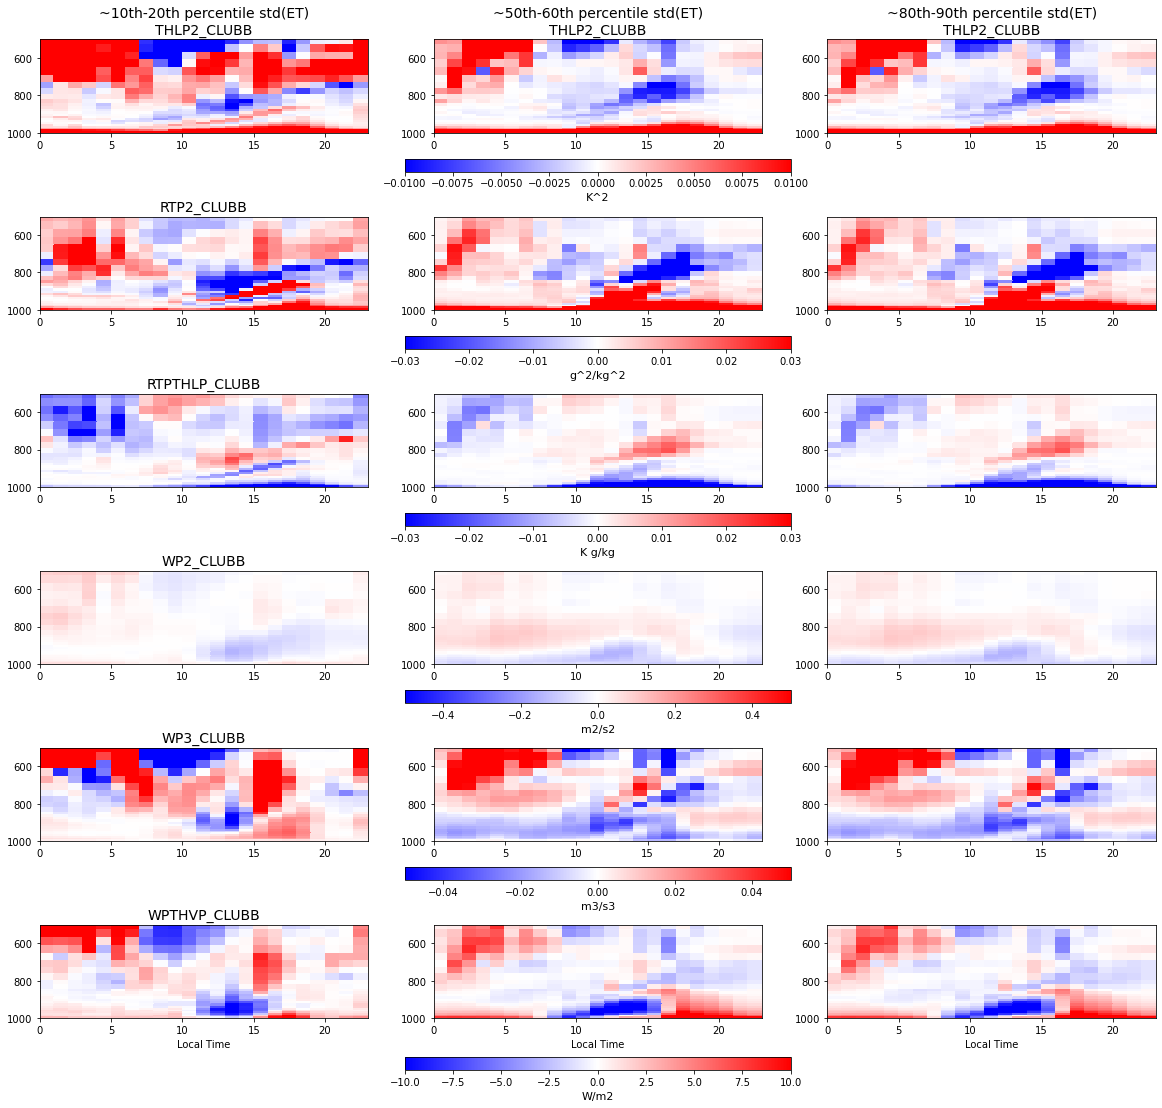

In [64]:
fig,axs = plt.subplots(6,3, figsize=(20,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB','WPTHVP_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.5, 0.05, 10])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMean20_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean20_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.02, ax_position.y0-0.04, ax_position.width+0.04, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.02, ax_position.y0-0.03, ax_position.width+0.04, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## Plot 80th-90th percentile bin 
    diffVar = np.squeeze(hourlyMean60_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean60_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_HMG.hour.values, hourlyMean_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('~10th-20th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('~50th-60th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+2].set_title('~80th-90th percentile std(ET)\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
    
    iPlot = iPlot+3
    

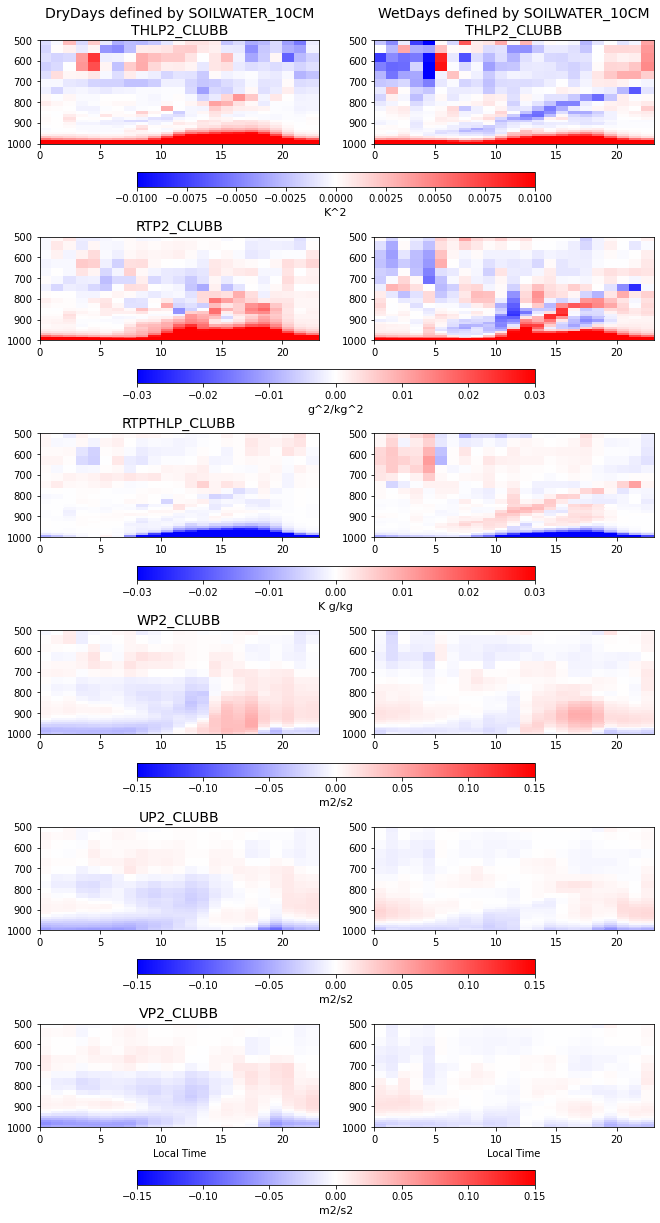

In [61]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.15, 0.15, 0.15])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

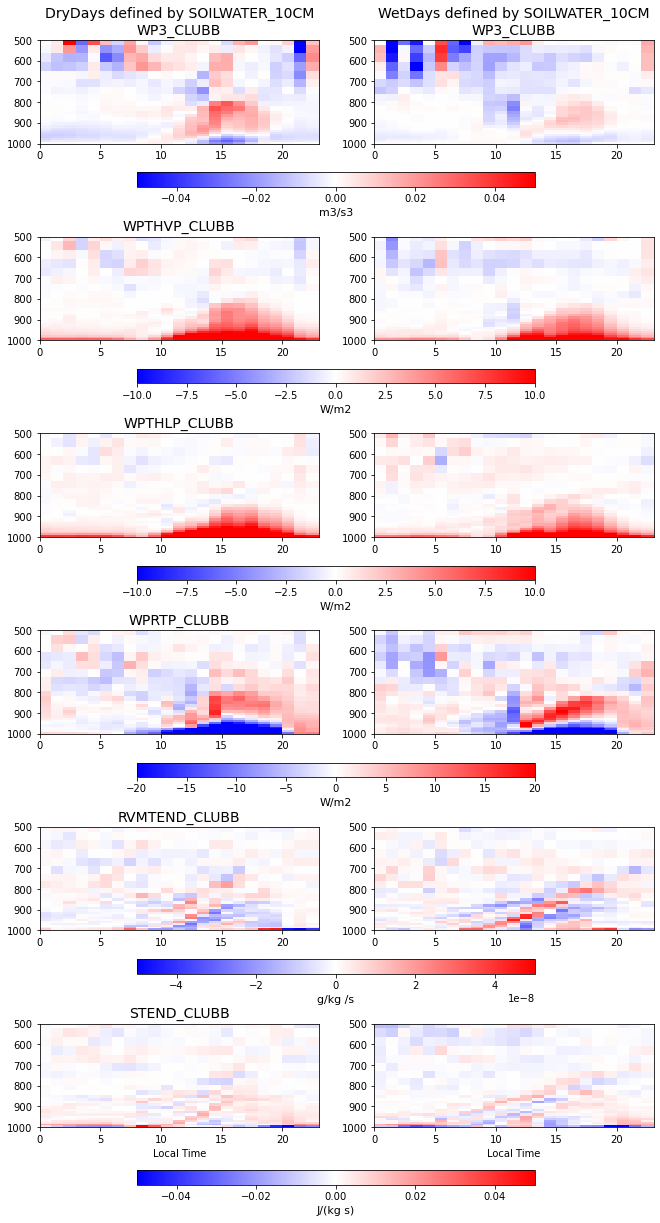

In [62]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+ATM_varNames[iVar],fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

In [63]:
hourlyMeanBot30_HTG


<xarray.Dataset>
Dimensions:             (hour: 24, ilev: 65, lat: 1, lev: 64, lon: 1)
Coordinates:
  * lat                 (lat) float64 36.61
  * lon                 (lon) float64 262.5
  * lev                 (lev) float64 2.949 4.338 6.313 ... 980.7 988.8 996.3
  * ilev                (ilev) float64 2.255 3.643 5.032 ... 985.1 992.6 1e+03
  * hour                (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Data variables:
    ntrk                (hour) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ntrn                (hour) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ntrm                (hour) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    gw                  (hour, lat) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    hyam                (hour, lev) float64 0.002949 0.004338 ... 0.0 0.0
    hybm                (hour, lev) float64 0.0 0.0 0.0 ... 0.9797 0.9888 0.9963
    P0                  (hour) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai                (hour, ilev) float64 0.002255 0.003643 ... 0.0 0.0
    hybi                (hour, ilev) float64 0.0 0.0 0.0 ... 0.9851 0.9926 1.0
    date                (hour) float64 2.016e+07 2.016e+07 ... 2.016e+07
    datesec             (hour) float64 2.098e+04 2.458e+04 ... 1.738e+04
    ndbase              (hour) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nsbase              (hour) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nbdate              (hour) float64 2.016e+07 2.016e+07 ... 2.016e+07
    nbsec               (hour) float64 8.458e+04 8.458e+04 ... 8.458e+04
    mdt                 (hour) float64 1.2e+03 1.2e+03 ... 1.2e+03 1.2e+03
    ndcur               (hour) float64 30.49 30.49 30.49 ... 30.83 30.83 30.83
    nscur               (hour) float64 2.28e+04 2.64e+04 ... 1.56e+04 1.92e+04
    co2vmr              (hour) float64 0.0003699 0.0003699 ... 0.0003698
    ch4vmr              (hour) float64 1.835e-06 1.835e-06 ... 1.835e-06
    n2ovmr              (hour) float64 3.159e-07 3.159e-07 ... 3.159e-07
    f11vmr              (hour) float64 7.078e-10 7.078e-10 ... 7.078e-10
    f12vmr              (hour) float64 5.413e-10 5.413e-10 ... 5.413e-10
    sol_tsi             (hour) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    nsteph              (hour) float64 2.215e+03 2.218e+03 ... 2.236e+03
    ADRAIN              (hour, lev, lat, lon) float32 0.0 0.0 ... 0.000128
    ADSNOW              (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AEROD_v             (hour, lat, lon) float32 nan nan nan nan ... nan nan nan
    ANRAIN              (hour, lev, lat, lon) float32 0.0 0.0 ... 0.5986 0.6504
    ANSNOW              (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AODDUST             (hour, lat, lon) float32 nan nan nan nan ... nan nan nan
    AODDUST1            (hour, lat, lon) float32 nan nan nan nan ... nan nan nan
    AODDUST3            (hour, lat, lon) float32 nan nan nan nan ... nan nan nan
    AODVIS              (hour, lat, lon) float32 nan nan nan nan ... nan nan nan
    AQRAIN              (hour, lev, lat, lon) float32 0.0 0.0 ... 7.637e-08
    AQSNOW              (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AREI                (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AREL                (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AWNC                (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    AWNI                (hour, lev, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    CAPE                (hour, lat, lon) float32 56.15 60.76 ... 118.5 111.8
    CCN3                (hour, lev, lat, lon) float32 0.0005718 ... 428.5
    CDNUMC              (hour, lat, lon) float32 6.759e+09 ... 9.088e+09
    CLDBOT              (hour, lat, lon) float32 16.06 17.0 ... 21.57 19.71
    CLDHGH              (hour, lat, lon) float32 0.5832 0.5856 ... 0.5745 0.6068
    CLDICE              (hour, lev, lat, lon) float32 7.296e-23 ... 3.59e-27
    CLDLIQ    

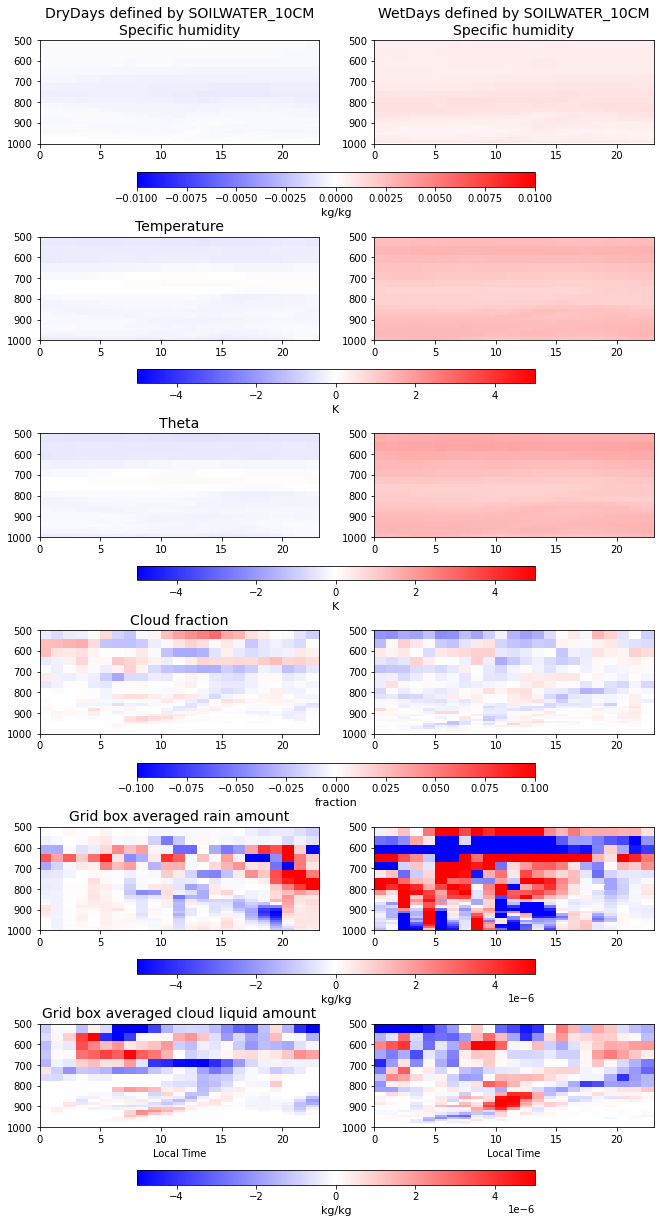

In [70]:
fig,axs = plt.subplots(6,2, figsize=(11,20))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['Q','T','theta','CLOUD','RAINQM','CLDLIQ'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 5, 5, 0.1, 0.000005, 0.000005])
yLim = 500

iPlot = 0
for iVar in range(6): 
        
    ## Plot 10th-20th percentile bin
    diffVar = np.squeeze(hourlyMeanBot30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanBot30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMeanBot30_HMG.hour.values, hourlyMeanBot30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## Plot 50th-60th percentile bin
    diffVar = np.squeeze(hourlyMeanTop30_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMeanTop30_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMeanTop30_HMG.hour.values, hourlyMeanTop30_HMG.lev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.04, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.03, ax_position.width+0.15, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        if ATM_varNames[iVar]=='theta':
            cbar.set_label('K',fontsize=11)
        else:
            cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    if ATM_varNames[iVar]=='theta':
        axs[iPlot].set_title('Theta',fontsize=14)
    else: 
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)

    if iVar==0:
        axs[iPlot].set_title('DryDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        axs[iPlot+1].set_title('WetDays defined by '+controlVar+'\n'+HTGcamDS_all[ATM_varNames[iVar]].long_name,fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
    
    iPlot = iPlot+2
    

**Now look at the percentiles' mean profiles averaged over a certain time of day**

In [65]:
def getMeanOverHours(DS, startHr, endHr):
    hourlyMean = DS.groupby("time.hour").mean()
    
    # Get mean over some hours 
    iHours    = np.where((hourlyMean.hour>=startHr) & (hourlyMean.hour<=endHr))[0]
    DShrSel   = hourlyMean.isel(hour=iHours)
    
    return(DShrSel.mean(dim='hour'))

In [66]:
# Get means over hours selected (on 0-23h scale)
startHr    = 8
endHr      = 10
# startHr    = 13
# endHr      = 15


hrMeansHTG_10pct  = getMeanOverHours(HTGcam_10pct, startHr, endHr)
hrMeansHTG_20pct  = getMeanOverHours(HTGcam_20pct, startHr, endHr)
hrMeansHTG_30pct  = getMeanOverHours(HTGcam_30pct, startHr, endHr)
hrMeansHTG_40pct  = getMeanOverHours(HTGcam_40pct, startHr, endHr)
hrMeansHTG_50pct  = getMeanOverHours(HTGcam_50pct, startHr, endHr)
hrMeansHTG_60pct  = getMeanOverHours(HTGcam_60pct, startHr, endHr)
hrMeansHTG_70pct  = getMeanOverHours(HTGcam_70pct, startHr, endHr)
hrMeansHTG_80pct  = getMeanOverHours(HTGcam_80pct, startHr, endHr)
hrMeansHTG_90pct  = getMeanOverHours(HTGcam_90pct, startHr, endHr)
hrMeansHTG_100pct = getMeanOverHours(HTGcam_100pct, startHr, endHr)

hrMeansHMG_10pct  = getMeanOverHours(HMGcam_10pct, startHr, endHr)
hrMeansHMG_20pct  = getMeanOverHours(HMGcam_20pct, startHr, endHr)
hrMeansHMG_30pct  = getMeanOverHours(HMGcam_30pct, startHr, endHr)
hrMeansHMG_40pct  = getMeanOverHours(HMGcam_40pct, startHr, endHr)
hrMeansHMG_50pct  = getMeanOverHours(HMGcam_50pct, startHr, endHr)
hrMeansHMG_60pct  = getMeanOverHours(HMGcam_60pct, startHr, endHr)
hrMeansHMG_70pct  = getMeanOverHours(HMGcam_70pct, startHr, endHr)
hrMeansHMG_80pct  = getMeanOverHours(HMGcam_80pct, startHr, endHr)
hrMeansHMG_90pct  = getMeanOverHours(HMGcam_90pct, startHr, endHr)
hrMeansHMG_100pct = getMeanOverHours(HMGcam_100pct, startHr, endHr)



In [67]:
def plotPctBasedProfiles(respondVar, xMin, xMax, levMax):
    fig,axs = plt.subplots(1,10, figsize=(18,5))
    axs     = axs.ravel()
    
    if np.shape(np.squeeze(hrMeansHMG_10pct[respondVar].values))[0]==len(HTGcamDS_all.ilev.values):
        levSel='ilev'
    elif np.shape(np.squeeze(hrMeansHMG_10pct[respondVar].values))[0]==len(HTGcamDS_all.lev.values):
        levSel='lev'

    ## Plot percentiles 
    axs[0].plot(np.squeeze(hrMeansHMG_10pct[respondVar].values), HMGcam_10pct[levSel].values, 'r-o', label='HMG')
    axs[0].plot(np.squeeze(hrMeansHTG_10pct[respondVar].values), HTGcam_10pct[levSel].values, 'b-o', label='HTG')
    axs[0].legend()
#     axs[0].set_title(respondVar+'\n0-10th Pct '+controlVar)
    axs[0].set_title(respondVar+'\n0-10th Pct '+controlVar)

    axs[1].plot(np.squeeze(hrMeansHMG_20pct[respondVar].values), HMGcam_20pct[levSel].values, 'r-o', label='HMG')
    axs[1].plot(np.squeeze(hrMeansHTG_20pct[respondVar].values), HTGcam_20pct[levSel].values, 'b-o', label='HTG')
    axs[1].set_title('\n10-20th Pct')

    axs[2].plot(np.squeeze(hrMeansHMG_30pct[respondVar].values), HMGcam_30pct[levSel].values, 'r-o', label='HMG')
    axs[2].plot(np.squeeze(hrMeansHTG_30pct[respondVar].values), HTGcam_30pct[levSel].values, 'b-o', label='HMG')
    axs[2].set_title('\n20-30th Pct')

    axs[3].plot(np.squeeze(hrMeansHMG_40pct[respondVar].values), HMGcam_40pct[levSel].values, 'r-o', label='HMG')
    axs[3].plot(np.squeeze(hrMeansHTG_40pct[respondVar].values), HTGcam_40pct[levSel].values, 'b-o', label='HMG')
    axs[3].set_title('\n30-40th Pct')

    axs[4].plot(np.squeeze(hrMeansHMG_50pct[respondVar].values), HMGcam_50pct[levSel].values, 'r-o', label='HMG')
    axs[4].plot(np.squeeze(hrMeansHTG_50pct[respondVar].values), HTGcam_50pct[levSel].values, 'b-o', label='HMG')
    axs[4].set_title('\n40-50th Pct')

    axs[5].plot(np.squeeze(hrMeansHMG_60pct[respondVar].values), HMGcam_60pct[levSel].values, 'r-o', label='HMG')
    axs[5].plot(np.squeeze(hrMeansHTG_60pct[respondVar].values), HTGcam_60pct[levSel].values, 'b-o', label='HMG')
    axs[5].set_title('\n50-60th Pct')

    axs[6].plot(np.squeeze(hrMeansHMG_70pct[respondVar].values), HMGcam_70pct[levSel].values, 'r-o', label='HMG')
    axs[6].plot(np.squeeze(hrMeansHTG_70pct[respondVar].values), HTGcam_70pct[levSel].values, 'b-o', label='HMG')
    axs[6].set_title('\n60-70th Pct')

    axs[7].plot(np.squeeze(hrMeansHMG_80pct[respondVar].values), HMGcam_80pct[levSel].values, 'r-o', label='HMG')
    axs[7].plot(np.squeeze(hrMeansHTG_80pct[respondVar].values), HTGcam_80pct[levSel].values, 'b-o', label='HMG')
    axs[7].set_title('\n70-80th Pct')

    axs[8].plot(np.squeeze(hrMeansHMG_90pct[respondVar].values), HMGcam_90pct[levSel].values, 'r-o', label='HMG')
    axs[8].plot(np.squeeze(hrMeansHTG_90pct[respondVar].values), HTGcam_90pct[levSel].values, 'b-o', label='HMG')
    axs[8].set_title('\n80-90th Pct')

    axs[9].plot(np.squeeze(hrMeansHMG_100pct[respondVar].values), HMGcam_100pct[levSel].values, 'r-o', label='HMG')
    axs[9].plot(np.squeeze(hrMeansHTG_100pct[respondVar].values), HTGcam_100pct[levSel].values, 'b-o', label='HMG')
    axs[9].set_title('\n90-100th Pct')


    ## Remove y-tick labels on other plots
    axs[1].get_yaxis().set_ticklabels([])
    axs[2].get_yaxis().set_ticklabels([])
    axs[3].get_yaxis().set_ticklabels([])
    axs[4].get_yaxis().set_ticklabels([])
    axs[5].get_yaxis().set_ticklabels([])
    axs[6].get_yaxis().set_ticklabels([])
    axs[7].get_yaxis().set_ticklabels([])
    axs[8].get_yaxis().set_ticklabels([])
    axs[9].get_yaxis().set_ticklabels([])

    ## Flip y axis 
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    axs[4].invert_yaxis()
    axs[5].invert_yaxis()
    axs[6].invert_yaxis()
    axs[7].invert_yaxis()
    axs[8].invert_yaxis()
    axs[9].invert_yaxis()
    
    ## Set y-axis limits
    axs[0].set_ylim([1000, levMax])
    axs[1].set_ylim([1000, levMax])
    axs[2].set_ylim([1000, levMax])
    axs[3].set_ylim([1000, levMax])
    axs[4].set_ylim([1000, levMax])
    axs[5].set_ylim([1000, levMax])
    axs[6].set_ylim([1000, levMax])
    axs[7].set_ylim([1000, levMax])
    axs[8].set_ylim([1000, levMax])
    axs[9].set_ylim([1000, levMax])

    ## Set x-axis limits
    axs[0].set_xlim([xMin, xMax])
    axs[1].set_xlim([xMin, xMax])
    axs[2].set_xlim([xMin, xMax])
    axs[3].set_xlim([xMin, xMax])
    axs[4].set_xlim([xMin, xMax])
    axs[5].set_xlim([xMin, xMax])
    axs[6].set_xlim([xMin, xMax])
    axs[7].set_xlim([xMin, xMax])
    axs[8].set_xlim([xMin, xMax])
    axs[9].set_xlim([xMin, xMax])

    ## Set axis labels
    axs[0].set_ylabel('hPa')
    axs[0].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[1].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[2].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[3].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[4].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[5].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[6].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[7].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[8].set_xlabel(HTGcamDS_local[respondVar].units)
    axs[9].set_xlabel(HTGcamDS_local[respondVar].units)
        
    plt.show()
    
    

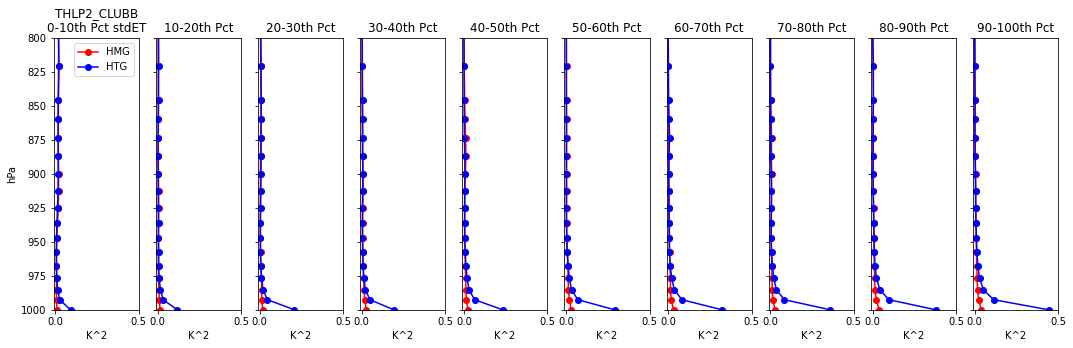

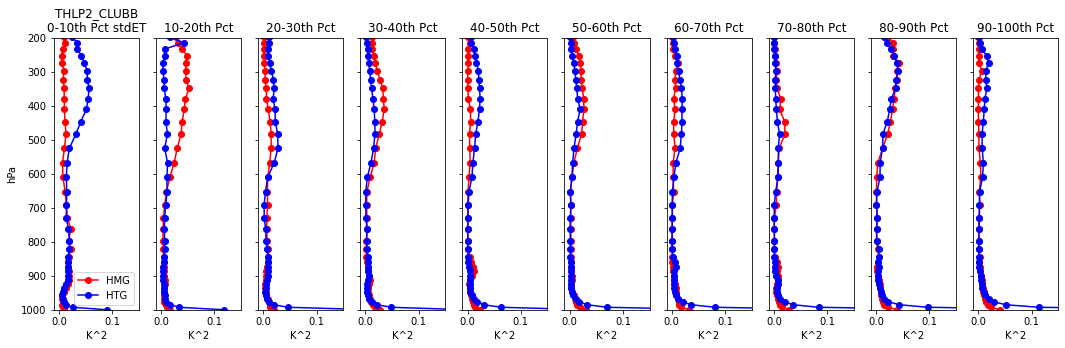

In [70]:
plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.5, 800) ## Used for Soil Moisture percentiles
# plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.6, 800)  ## Used for std(ET) percentiles

plotPctBasedProfiles('THLP2_CLUBB', -0.01, 0.15, 200)  ## Used for std(ET) percentiles


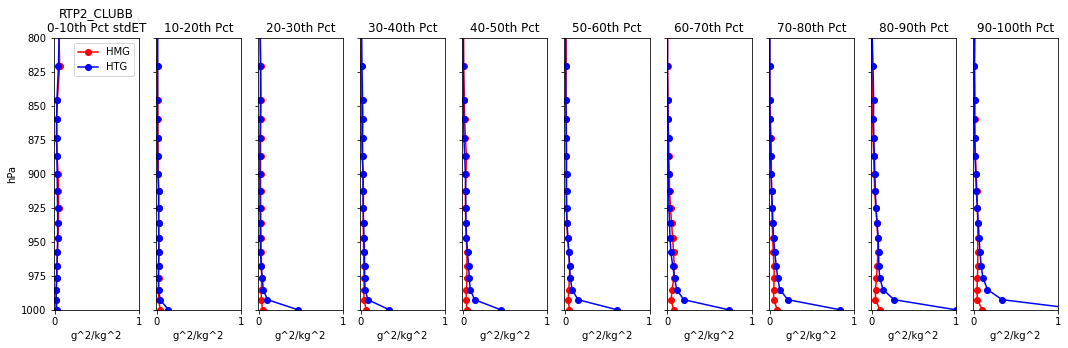

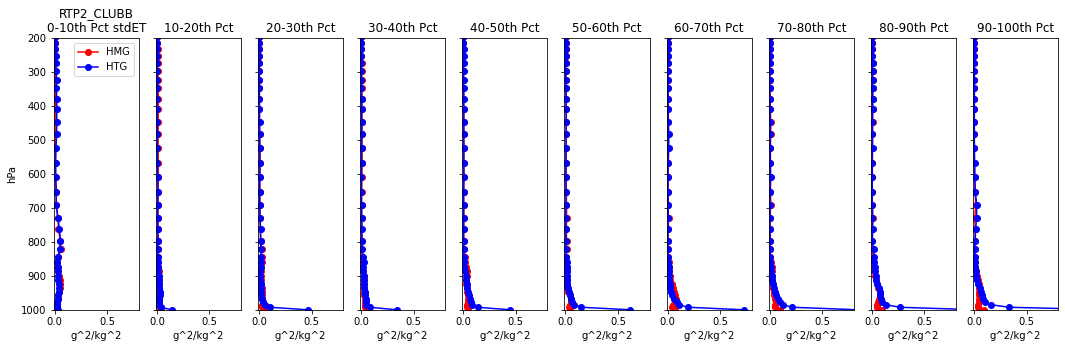

In [73]:
# plotPctBasedProfiles('RTP2_CLUBB', -0.01, 0.35, 800) ## Used for percentiles of soil moisture 
plotPctBasedProfiles('RTP2_CLUBB', -0.01, 1.0, 800) ## Used for percentiles of std(ET)
plotPctBasedProfiles('RTP2_CLUBB', -0.01, 0.8, 200) ## Used for percentiles of std(ET)


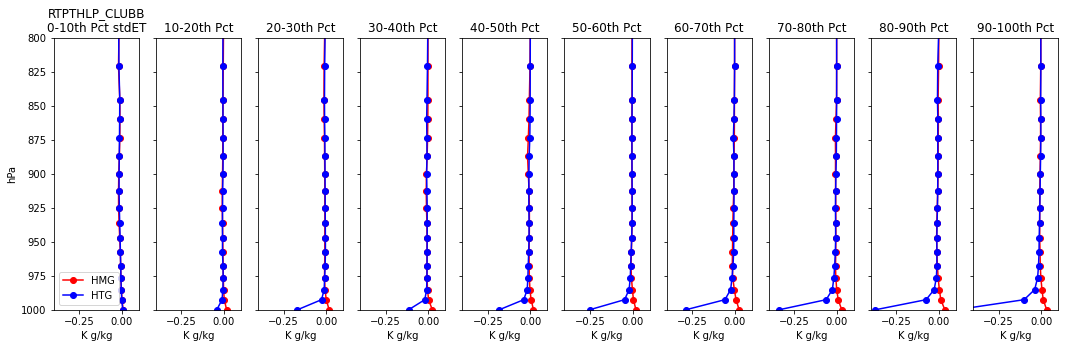

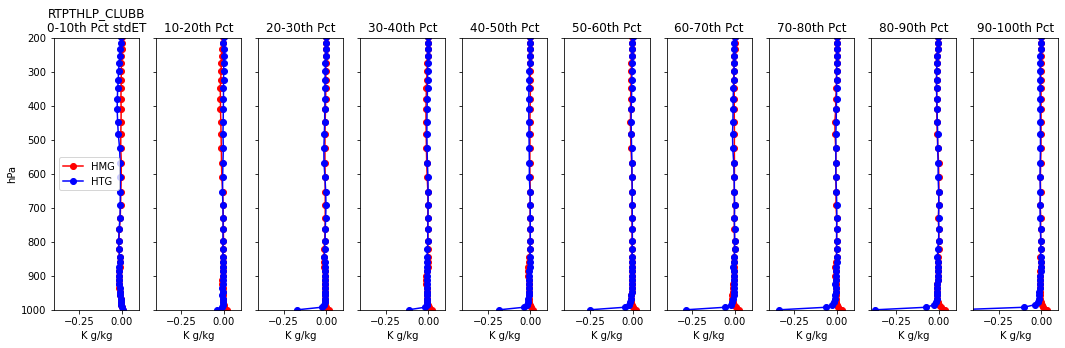

In [75]:
# plotPctBasedProfiles('RTPTHLP_CLUBB', -0.1, 0.08, 800) ## Used for percentiles of soil moisture 
plotPctBasedProfiles('RTPTHLP_CLUBB', -0.4, 0.1, 800) ## Used for percentiles of std(ET)
plotPctBasedProfiles('RTPTHLP_CLUBB', -0.4, 0.1, 200) ## Used for percentiles of std(ET)


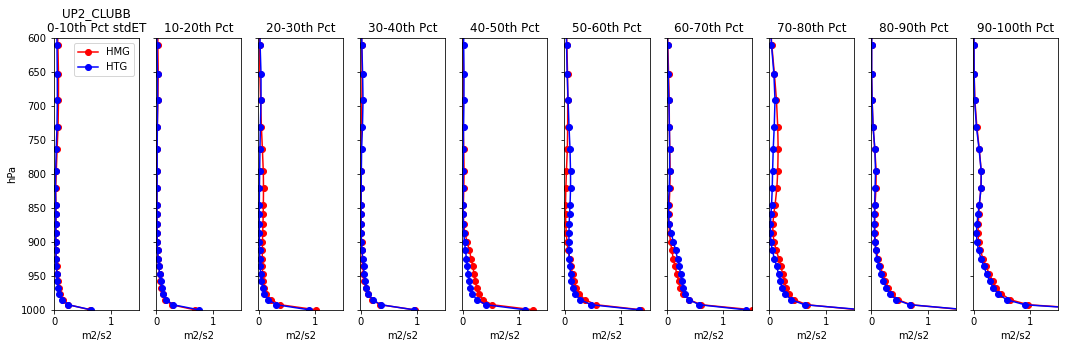

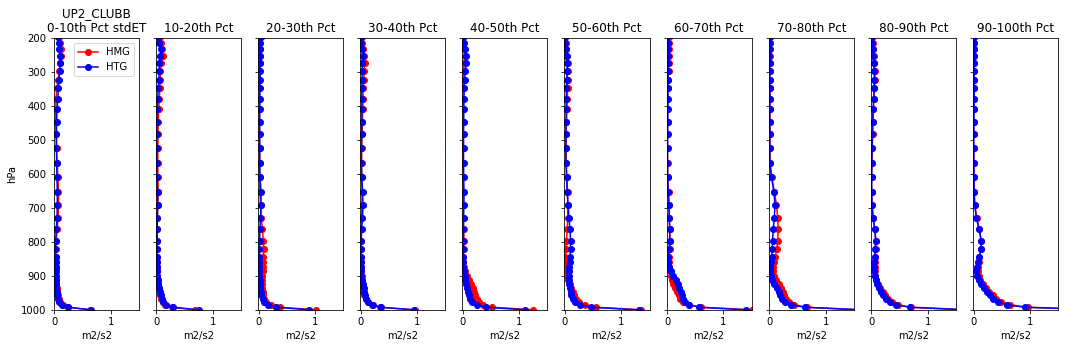

In [76]:
plotPctBasedProfiles('UP2_CLUBB', -0.01, 1.5, 600) ## Used for percentiles of soil moisture and std(ET)
plotPctBasedProfiles('UP2_CLUBB', -0.01, 1.5, 200) ## Used for percentiles of soil moisture and std(ET)

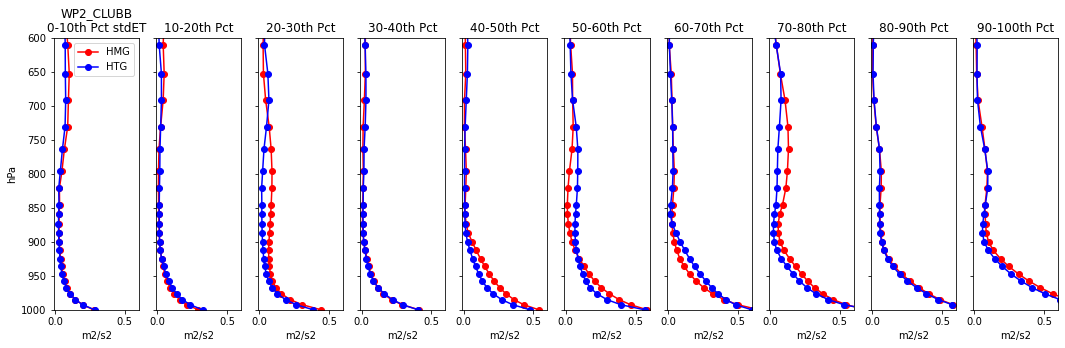

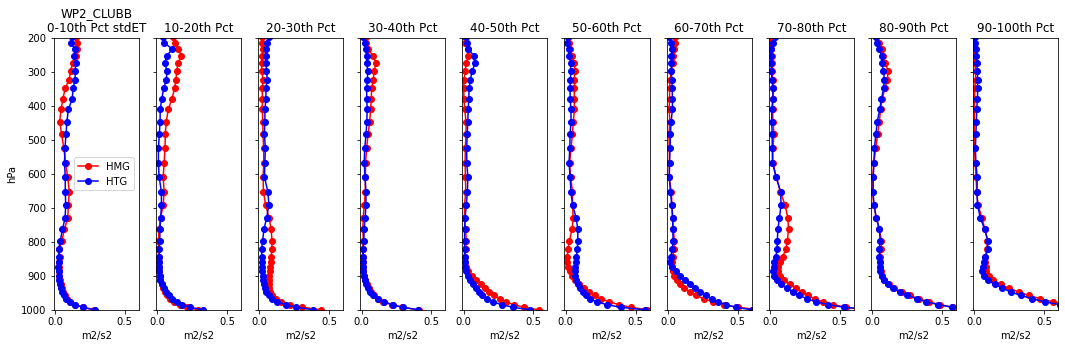

In [77]:
plotPctBasedProfiles('WP2_CLUBB', -0.01, 0.6, 600)
plotPctBasedProfiles('WP2_CLUBB', -0.01, 0.6, 200)


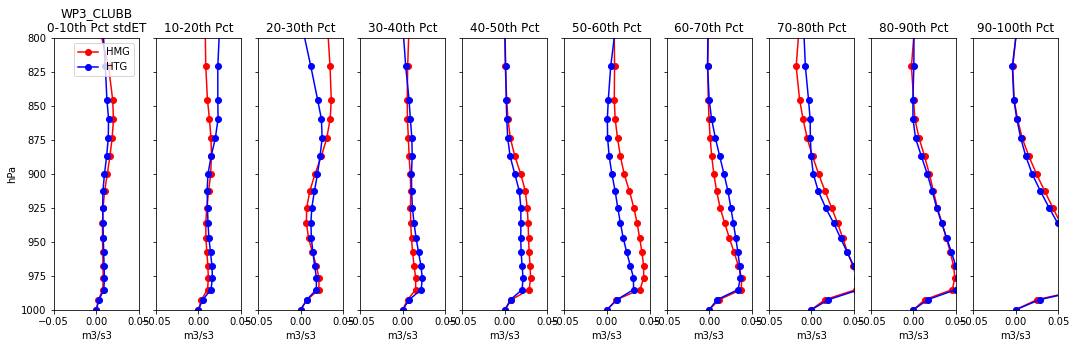

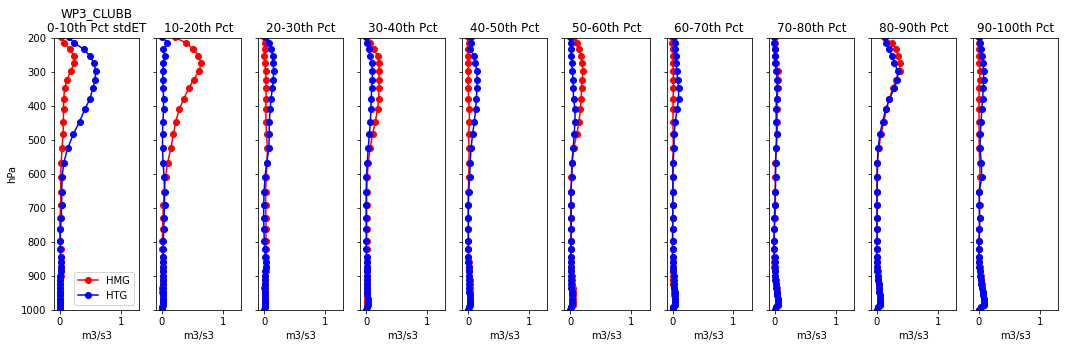

In [78]:
plotPctBasedProfiles('WP3_CLUBB', -0.05, 0.05, 800) ## Used for soil moisture percentiles and std(ET)
plotPctBasedProfiles('WP3_CLUBB', -0.1, 1.3, 200) ## Used for std(ET) percentiles


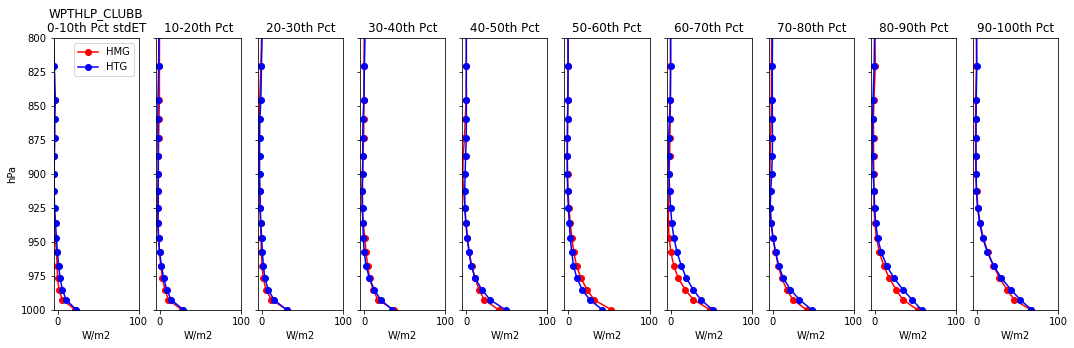

In [79]:
# plotPctBasedProfiles('WPTHLP_CLUBB', -5, 80, 800) ## Used for SM percnetiles 
plotPctBasedProfiles('WPTHLP_CLUBB', -5, 100, 800) ## Used for std(ET) percnetiles 

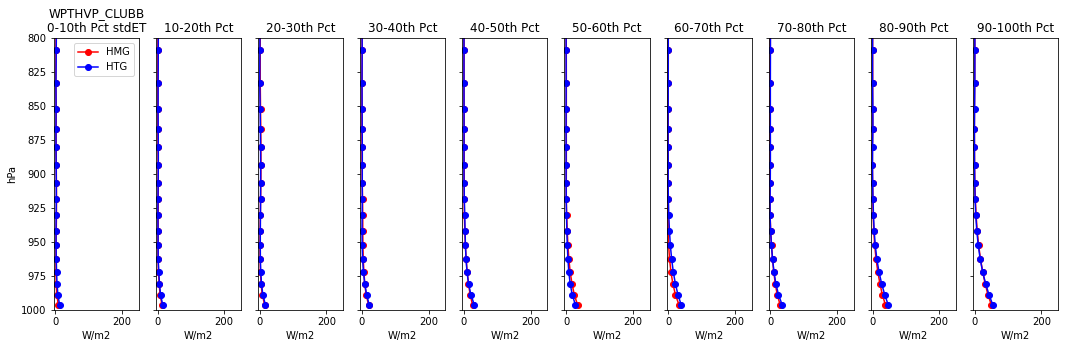

In [80]:
# plotPctBasedProfiles('WPTHLP_CLUBB', -5, 80, 800) ## Used for SM percnetiles 
plotPctBasedProfiles('WPTHVP_CLUBB', -5, 250, 800) ## Used for std(ET) percnetiles 

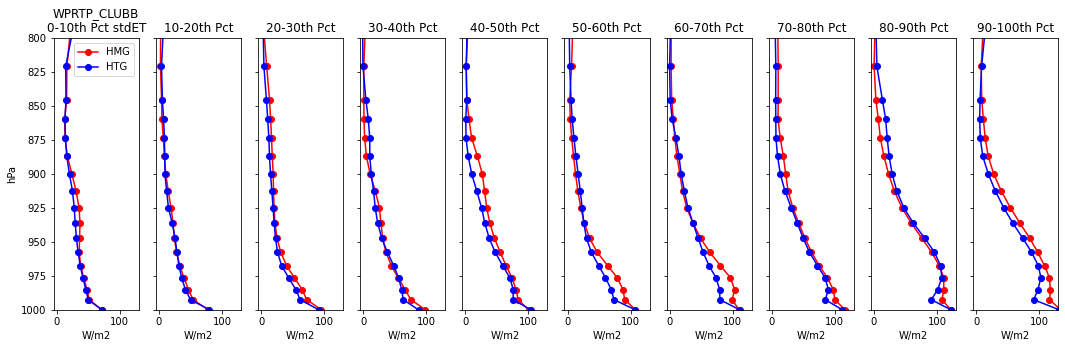

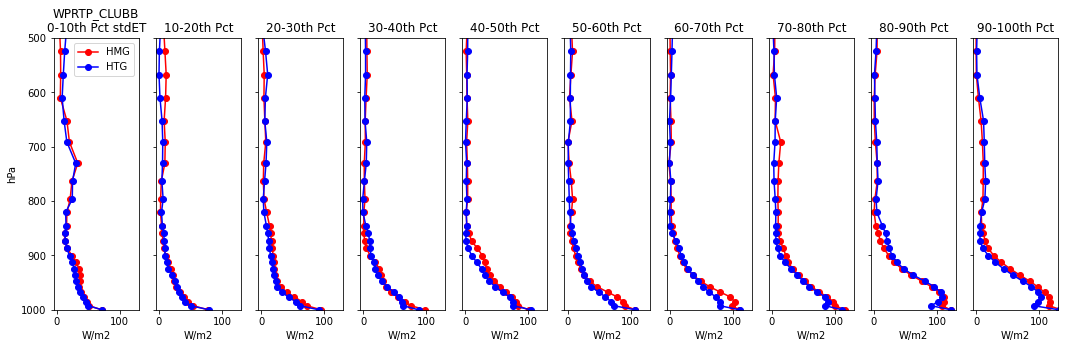

In [81]:
plotPctBasedProfiles('WPRTP_CLUBB', -5, 130, 800)  ## Used for SM percentiles  & std(ET)
plotPctBasedProfiles('WPRTP_CLUBB', -5, 130, 500)  ## Used for SM percentiles  & std(ET)


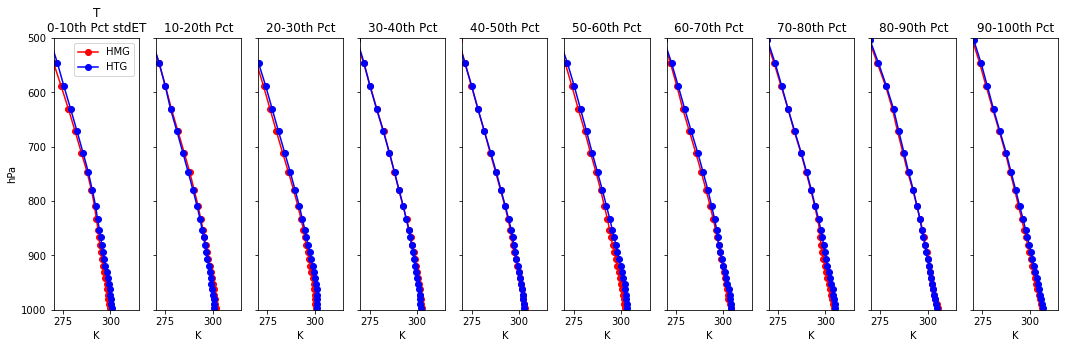

In [82]:
plotPctBasedProfiles('T', 270, 315, 500)

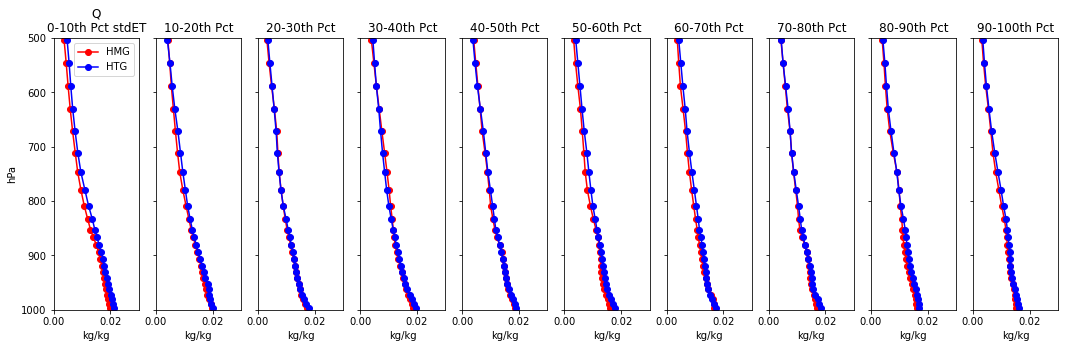

In [83]:
plotPctBasedProfiles('Q', 0, 3e-2, 500)

What characterizes those days with low HTG?

Text(0, 0.5, 'Mean PRECT (m/s)')

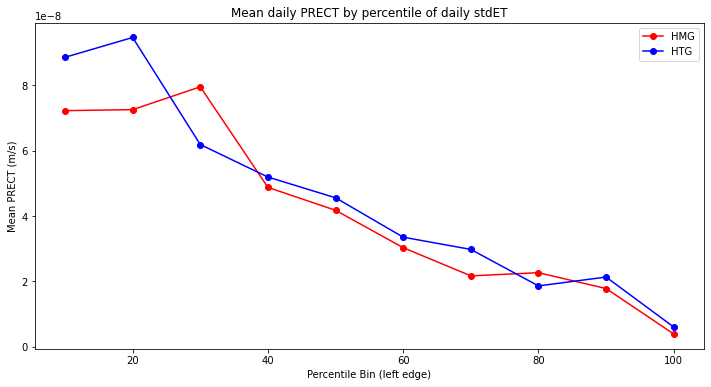

In [193]:
varSel = 'PRECT'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')


Text(0, 0.5, 'Mean PRECTdailySum (mm/day)')

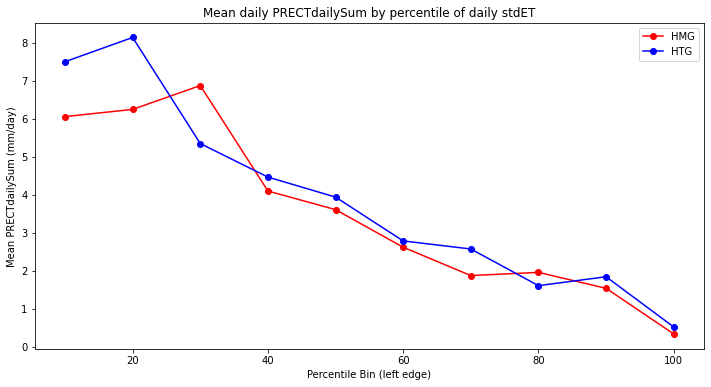

In [194]:
varSel = 'PRECTdailySum'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' (mm/day)')



Text(0, 0.5, 'Mean CLDTOT (fraction)')

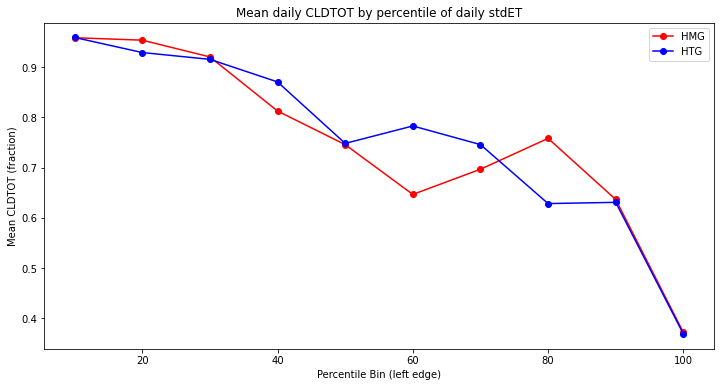

In [195]:
varSel = 'CLDTOT'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values


fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')



Text(0, 0.5, 'Mean CLDLOW (fraction)')

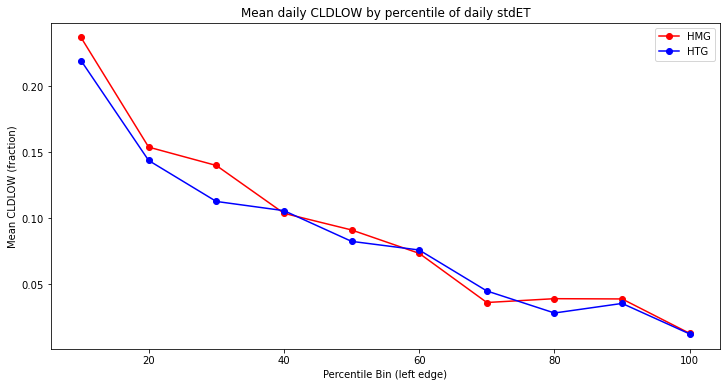

In [196]:
varSel = 'CLDLOW'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values


fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')




Text(0, 0.5, 'Mean LHFLX (W/m2)')

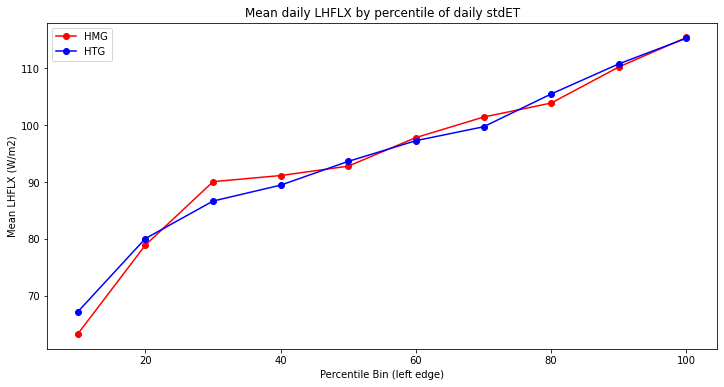

In [88]:
varSel = 'LHFLX'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')

Text(0, 0.5, 'Mean SHFLX (W/m2)')

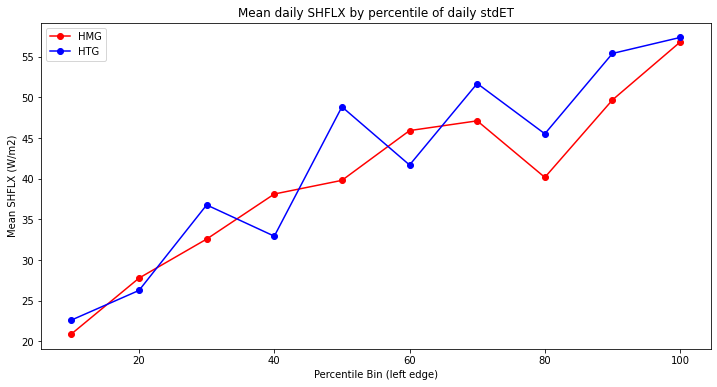

In [89]:
varSel = 'SHFLX'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values


fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')


Text(0, 0.5, 'Mean PBLH (m)')

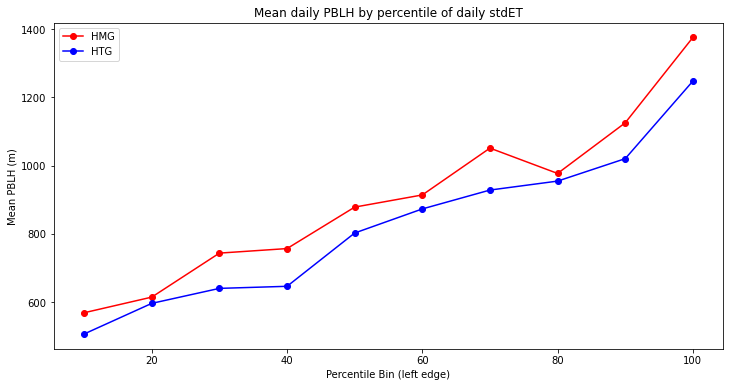

In [90]:
varSel = 'PBLH'

HMGpctSeries_1Dvar    = np.full([10], np.nan)
HMGpctSeries_1Dvar[0] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin0).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[1] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin1).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[2] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin2).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[3] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin3).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[4] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin4).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[5] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin5).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[6] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin6).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[7] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin7).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[8] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin8).mean(dim='year_month_day'))[varSel].values
HMGpctSeries_1Dvar[9] = (HMGcamDS_localDailyMean.isel(year_month_day=HMGbin9).mean(dim='year_month_day'))[varSel].values

HTGpctSeries_1Dvar    = np.full([10], np.nan)
HTGpctSeries_1Dvar[0] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin0).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[1] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin1).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[2] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin2).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[3] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin3).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[4] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin4).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[5] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin5).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[6] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin6).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[7] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin7).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[8] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin8).mean(dim='year_month_day'))[varSel].values
HTGpctSeries_1Dvar[9] = (HTGcamDS_localDailyMean.isel(year_month_day=HTGbin9).mean(dim='year_month_day'))[varSel].values

fig, ax1 = plt.subplots(1,1, figsize=(12, 6))
ax1.plot(np.arange(10,110,10), HMGpctSeries_1Dvar, 'r-o', label='HMG')
ax1.plot(np.arange(10,110,10), HTGpctSeries_1Dvar, 'b-o', label='HTG')
ax1.legend()
ax1.set_title('Mean daily '+varSel+' by percentile of daily '+controlVar)
ax1.set_xlabel('Percentile Bin (left edge)')
ax1.set_ylabel('Mean '+varSel+' ('+HTGcamDS_local[varSel].units+')')

#### What about wD/wW/dD/dW day classifications? 

In [30]:
'''
Function to send back which classification each day falls into, 
based on precipitation amount, similar to Burns et al. (2015; 2018).
This version of the function assumes a single column run/input, 
in that only one dimension exists for precip. 

Inputs: 
   time:   An array of times to worry about. 
           Should be a pandas datetime.
   precip: Daily precipitation (summed). Units can be in mm or m, 
           but need to be consistent with the threshold the user
           defines (i.e., no unit conversions done here).
   wetDef: User-defined threshold for defining days as wet vs. dry. 
Outputs:
    classificationArr: Array with one fewer length than time, where
                       the classification falls into four categories:
                       1 :: wWet   (wet day following a wet day)
                       2 :: wDry   (dry day following a wet day)
                       3 :: dWet   (wet day following a dry day)
                       4 :: dDry   (dry day following a dry day)
                       
                       Difference in length due to the first day not having a 
                       "before" day to reference. So time[0] on the 
                       classification array corresponds to time[1]. 

'''

def classifyPrectDays_SCAM(time,precip,wetDef): 
    
    # Define empty arrays of the appropriate length
    nTimes               = len(time)
    classificationArr    = np.empty([len(time)]).astype('str')
    classificationArr[0] = 'n/a'
    
    for iDay in range(nTimes-1): 
        
        # Wet day...
        if precip[iDay]>=wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'wWet'  # Wet day following wet 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'wDry' # Dry day following wet 
        # Dry day...
        elif precip[iDay]<wetDef:
            if precip[iDay+1]>=wetDef:
                classificationArr[iDay+1] = 'dWet'  # Wet day following dry 
            elif precip[iDay+1]<wetDef : 
                classificationArr[iDay+1] = 'dDry' # Dry day following dry 

    return(classificationArr)


In [31]:
## First, need to get daily rain amounts 

# PRECT defined as mean [m/s] over 20m timestep, 
#   so multiply by seconds in a 20m timestep and by 1000 mm/m to turn into  [mm/20 min]
HMGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HMGcamDS_local.PRECT.values*1200.0*1000.0)
HTGcamDS_local['PRECT_mmPerDT'] = (('time','lat','lon'), HTGcamDS_local.PRECT.values*1200.0*1000.0)
# Now sum over the day to get total amount of rainfall
HMGcamDS_localDailySum = HMGcamDS_local.groupby('year_month_day').sum()
HTGcamDS_localDailySum = HTGcamDS_local.groupby('year_month_day').sum()



In [32]:
# Define cutoff for classifying a "dry day" [mm/day] 
prectCutoff = 1

print('Number of total days in record:   %i' % (len(HMGcamDS_localDailySum.year_month_day.values)) )
print('Number of dry days (< %.3f):     %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values<prectCutoff)[0])))
print('Number of wet days (>= %.3f):    %i' % (prectCutoff, len(np.where(HMGcamDS_localDailySum.PRECT_mmPerDT.values>=prectCutoff)[0])))


Number of total days in record:   264
Number of dry days (< 1.000):     129
Number of wet days (>= 1.000):    135


In [33]:
# Define classification by day... 

classArr_HTG = classifyPrectDays_SCAM(HTGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HTGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 
classArr_HMG = classifyPrectDays_SCAM(HMGcamDS_localDailySum.year_month_day.values, # Time array 
                                      HMGcamDS_localDailySum.PRECT_mmPerDT.values,  # Precip array 
                                      prectCutoff)                        # Threshold that defines wet/dry days 

# Add that classification to larger datasets
HTGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HTG)
HMGcamDS_localDailySum['dayClass'] = (('year_month_day'), classArr_HMG)

# Select based on each classification:
idDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HTG = np.where(HTGcamDS_localDailySum['dayClass'].values=='wWet')[0]

HTG_dDry = HTGcamDS_localDailySum.isel(year_month_day = idDry_HTG)
HTG_dWet = HTGcamDS_localDailySum.isel(year_month_day = idWet_HTG)
HTG_wDry = HTGcamDS_localDailySum.isel(year_month_day = iwDry_HTG)
HTG_wWet = HTGcamDS_localDailySum.isel(year_month_day = iwWet_HTG)


idDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dDry')[0]
idWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='dWet')[0]
iwDry_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wDry')[0]
iwWet_HMG = np.where(HMGcamDS_localDailySum['dayClass'].values=='wWet')[0]

HMG_dDry = HMGcamDS_localDailySum.isel(year_month_day = idDry_HMG)
HMG_dWet = HMGcamDS_localDailySum.isel(year_month_day = idWet_HMG)
HMG_wDry = HMGcamDS_localDailySum.isel(year_month_day = iwDry_HMG)
HMG_wWet = HMGcamDS_localDailySum.isel(year_month_day = iwWet_HMG)


In [34]:
print('   Number of days in each category   ')
print('         HMG              HTG   ')
print('dDry: %6i %16i' % (len(HMG_dDry.year_month_day.values), len(HTG_dDry.year_month_day.values)) )
print('dWet: %6i %16i' % (len(HMG_dWet.year_month_day.values), len(HTG_dWet.year_month_day.values)) )
print('wDry: %6i %16i' % (len(HMG_wDry.year_month_day.values), len(HTG_wDry.year_month_day.values)) )
print('wWet: %6i %16i' % (len(HMG_wWet.year_month_day.values), len(HTG_wWet.year_month_day.values)) )


   Number of days in each category   
         HMG              HTG   
dDry:     83               85
dWet:     46               45
wDry:     45               44
wWet:     89               89


In [35]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDayClass(fullDS, dayClassDS):
    iTimes = []
    
    for iTime in range(len(dayClassDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==dayClassDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==dayClassDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==dayClassDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [36]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dDry)
wDryDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wDry)
dWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_dWet)
wWetDays_HTG = getTimes_basedOnDayClass(HTGcamDS_local, HTG_wWet)

dDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dDry)
wDryDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wDry)
dWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_dWet)
wWetDays_HMG = getTimes_basedOnDayClass(HMGcamDS_local, HMG_wWet)


In [37]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dDry)
wDryDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wDry)
dWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_dWet)
wWetDaysCLM_HTG = getTimes_basedOnDayClass(HTGclmDS_local, HTG_wWet)

dDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dDry)
wDryDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wDry)
dWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_dWet)
wWetDaysCLM_HMG = getTimes_basedOnDayClass(HMGclmDS_local, HMG_wWet)

In [38]:
# Next, get all the times in the full array that line up with each of those classifications above 

dDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dDry)
wDryDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wDry)
dWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_dWet)
wWetDaysPatch_HTG = getTimes_basedOnDayClass(HTGclmDS_patch_local, HTG_wWet)

dDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dDry)
wDryDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wDry)
dWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_dWet)
wWetDaysPatch_HMG = getTimes_basedOnDayClass(HMGclmDS_patch_local, HMG_wWet)

In [39]:
# Get means a function of hour of day
hourlyMean_dDry_HMG = dDryDays_HMG.groupby("time.hour").mean()
hourlyMean_dDry_HTG = dDryDays_HTG.groupby("time.hour").mean()

hourlyMean_wDry_HMG = wDryDays_HMG.groupby("time.hour").mean()
hourlyMean_wDry_HTG = wDryDays_HTG.groupby("time.hour").mean()

hourlyMean_dWet_HMG = dWetDays_HMG.groupby("time.hour").mean()
hourlyMean_dWet_HTG = dWetDays_HTG.groupby("time.hour").mean()

hourlyMean_wWet_HMG = wWetDays_HMG.groupby("time.hour").mean()
hourlyMean_wWet_HTG = wWetDays_HTG.groupby("time.hour").mean()


In [40]:
# Get means a function of hour of day
hourlyMeanCLM_dDry_HMG = dDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dDry_HTG = dDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wDry_HMG = wDryDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wDry_HTG = wDryDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_dWet_HMG = dWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_dWet_HTG = dWetDaysCLM_HTG.groupby("time.hour").mean()

hourlyMeanCLM_wWet_HMG = wWetDaysCLM_HMG.groupby("time.hour").mean()
hourlyMeanCLM_wWet_HTG = wWetDaysCLM_HTG.groupby("time.hour").mean()

In [41]:
# Get means a function of hour of day
hourlyMeanPatch_dDry_HMG = dDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dDry_HTG = dDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wDry_HMG = wDryDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wDry_HTG = wDryDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_dWet_HMG = dWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_dWet_HTG = dWetDaysPatch_HTG.groupby("time.hour").mean()

hourlyMeanPatch_wWet_HMG = wWetDaysPatch_HMG.groupby("time.hour").mean()
hourlyMeanPatch_wWet_HTG = wWetDaysPatch_HTG.groupby("time.hour").mean()



In [67]:
HTGcamDS_local.TGCLDLWP

<xarray.DataArray 'TGCLDLWP' (time: 18792, lat: 1, lon: 1)>
array([[[0.08672693]],

       [[0.08361347]],

       [[0.08244278]],

       ...,

       [[0.09055335]],

       [[0.09028795]],

       [[0.08837643]]], dtype=float32)
Coordinates:
  * lat             (lat) float64 36.61
  * lon             (lon) float64 262.5
  * time            (time) datetime64[ns] 2015-06-02T18:39:45 ... 2017-08-28T...
    year_month_day  (time) object (2015, 6, 2) (2015, 6, 2) ... (2017, 8, 28)
Attributes:
    units:         kg/m2
    long_name:     Total grid-box cloud liquid water path
    cell_methods:  time: mean

In [66]:
## Print some summary daily means for each case 

print('                   dDry      wDry      dWet      wWet')
print('                   -----     -----     -----     -----')
print('Daily rain (HMG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HMG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HMG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HMG_wWet.PRECT_mmPerDT.values)))
print('           (HTG): %6.2f %8.2f %9.2f %9.2f' % (np.nanmean(HTG_dDry.PRECT_mmPerDT.values), 
                                                     np.nanmean(HTG_wDry.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_dWet.PRECT_mmPerDT.values),
                                                     np.nanmean(HTG_wWet.PRECT_mmPerDT.values)))
print()
varSel = 'TGCLDLWP'
print('Daily TGCLDLWP (HMG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('               (HTG): %4.2e %8.2e %9.2e %9.2e' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDTOT'
print('Daily CLDTOT (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDLOW'
print('Daily CLDLOW (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))

print()
varSel = 'CLDMED'
print('Daily CLDMED (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'CLDHGH'
print('Daily CLDHGH (HMG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HMG[varSel].values)))
print('             (HTG): %4.2f %8.2f %9.2f %9.2f' % (np.nanmean(hourlyMean_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMean_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMean_wWet_HTG[varSel].values)))
print()
varSel = 'QFLX_EVAP_TOT'
print('Daily ET (HMG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('         (HTG): %9.2e %10.2e %10.2e %10.2e' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))

print()
varSel = 'SOILWATER_10CM'
print('Daily SM_10CM (HMG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HMG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HMG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HMG[varSel].values)))
print('              (HTG): %4.2f %8.2f %8.2f %8.2f' % (np.nanmean(hourlyMeanCLM_dDry_HTG[varSel].values), 
                                                       np.nanmean(hourlyMeanCLM_wDry_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_dWet_HTG[varSel].values),
                                                       np.nanmean(hourlyMeanCLM_wWet_HTG[varSel].values)))





                   dDry      wDry      dWet      wWet
                   -----     -----     -----     -----
Daily rain (HMG):   0.23     0.29      4.51      7.95
           (HTG):   0.24     0.34      4.33      8.45

Daily TGCLDLWP (HMG): 2.54e-02 3.07e-02  7.99e-02  1.08e-01
               (HTG): 2.04e-02 3.11e-02  7.83e-02  1.15e-01

Daily CLDTOT (HMG): 0.55     0.66      0.87      0.92
             (HTG): 0.50     0.76      0.85      0.93

Daily CLDLOW (HMG): 0.02     0.08      0.08      0.18
             (HTG): 0.02     0.07      0.09      0.15

Daily CLDMED (HMG): 0.24     0.22      0.52      0.47
             (HTG): 0.20     0.26      0.51      0.47

Daily CLDHGH (HMG): 0.47     0.57      0.80      0.88
             (HTG): 0.44     0.68      0.79      0.90

Daily ET (HMG):  3.89e-05   3.49e-05   4.16e-05   3.63e-05
         (HTG):  3.82e-05   3.47e-05   4.19e-05   3.75e-05

Daily SM_10CM (HMG): 24.10    27.78    25.96    30.61
              (HTG): 24.19    28.59    26.32    30.7

(300.0, 320.0)

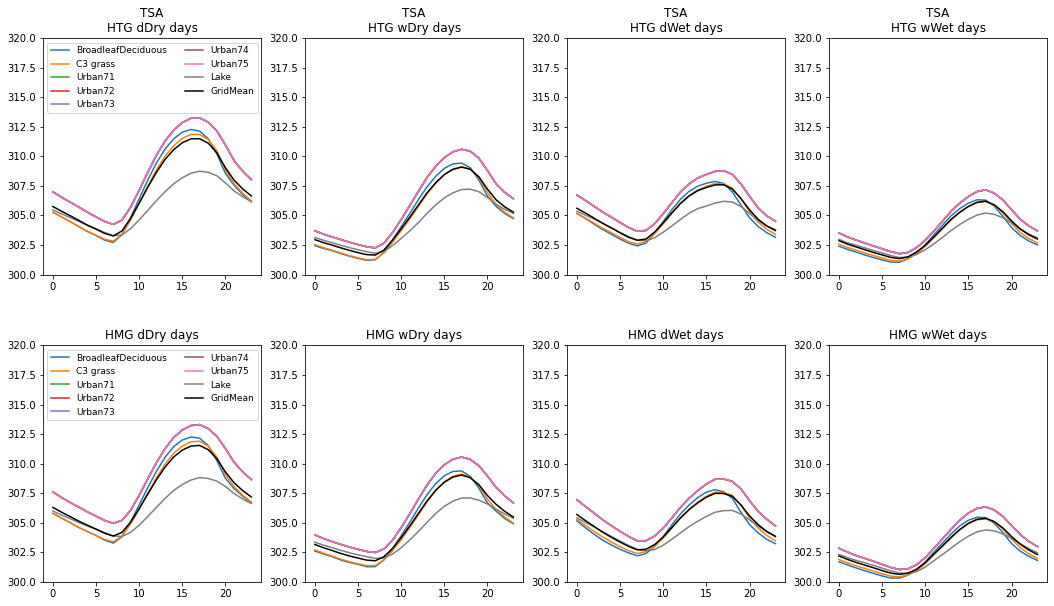

In [43]:
varSel = np.asarray(['TSA'])
yMax = np.asarray([320])
yMin = np.asarray([300])

fig,axs = plt.subplots(2,4, figsize=(18,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

## dDry days 
for iPatch in range(len(patchLabels)):
    axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG['TSA'].values, 'k-',label='GridMean')
axs[0].legend(loc='upper left',ncol=2,fontsize=9)
axs[0].set_title(varSel[0]+'\nHTG dDry days')
axs[0].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[0+4].plot(hourlyMeanPatch_dDry_HMG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HMG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[0+4].plot(hourlyMeanCLM_dDry_HMG.hour.values, hourlyMeanCLM_dDry_HMG['TSA'].values, 'k-',label='GridMean')
axs[0+4].legend(loc='upper left',ncol=2,fontsize=9)
axs[0+4].set_title('\nHMG dDry days')
axs[0+4].set_ylim([yMin[0], yMax[0]])

## wDry days 
for iPatch in range(len(patchLabels)):
    axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, hourlyMeanCLM_wDry_HTG['TSA'].values, 'k-',label='GridMean')
axs[1].set_title(varSel[0]+'\nHTG wDry days')
axs[1].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[1+4].plot(hourlyMeanPatch_wDry_HMG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HMG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[1+4].plot(hourlyMeanCLM_wDry_HMG.hour.values, hourlyMeanCLM_wDry_HMG['TSA'].values, 'k-',label='GridMean')
axs[1+4].set_title('\nHMG wDry days')
axs[1+4].set_ylim([yMin[0], yMax[0]])

## dWet days 
for iPatch in range(len(patchLabels)):
    axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, hourlyMeanCLM_dWet_HTG['TSA'].values, 'k-',label='GridMean')
axs[2].set_title(varSel[0]+'\nHTG dWet days')
axs[2].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[2+4].plot(hourlyMeanPatch_dWet_HMG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HMG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[2+4].plot(hourlyMeanCLM_dWet_HMG.hour.values, hourlyMeanCLM_dWet_HMG['TSA'].values, 'k-',label='GridMean')
axs[2+4].set_title('\nHMG dWet days')
axs[2+4].set_ylim([yMin[0], yMax[0]])


## wWet days 
for iPatch in range(len(patchLabels)):
    axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG['TSA'].values, 'k-',label='GridMean')
axs[3].set_title(varSel[0]+'\nHTG wWet days')
axs[3].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[3+4].plot(hourlyMeanPatch_wWet_HMG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HMG['TSA'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[3+4].plot(hourlyMeanCLM_wWet_HMG.hour.values, hourlyMeanCLM_wWet_HMG['TSA'].values, 'k-',label='GridMean')
axs[3+4].set_title('\nHMG wWet days')
axs[3+4].set_ylim([yMin[0], yMax[0]])


(0.012, 0.025)

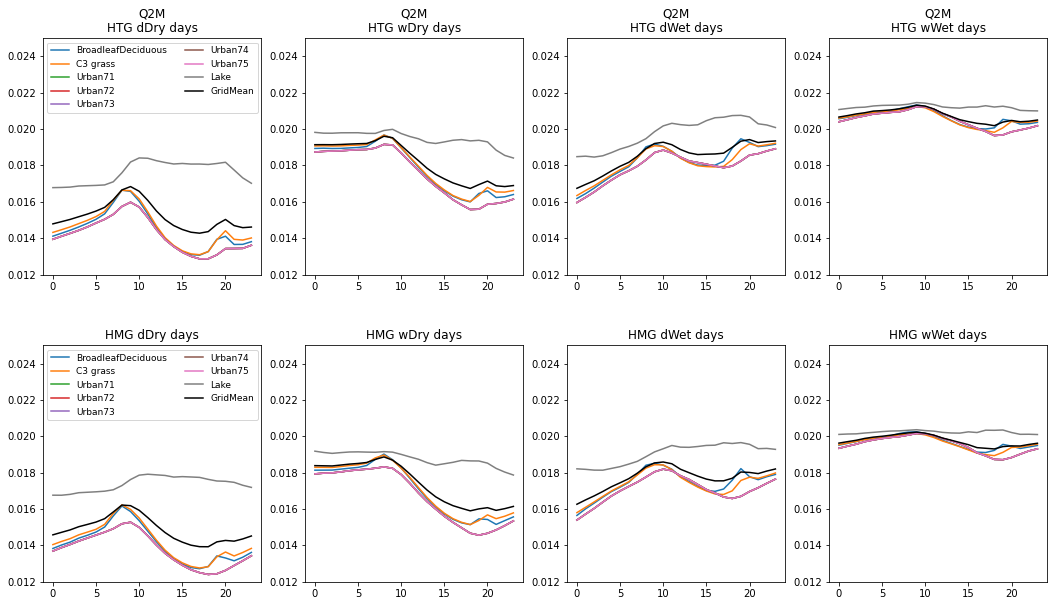

In [44]:
varSel = np.asarray(['Q2M'])
yMax = np.asarray([0.025])
yMin = np.asarray([0.012])

fig,axs = plt.subplots(2,4, figsize=(18,10))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

## dDry days 
for iPatch in range(len(patchLabels)):
    axs[0].plot(hourlyMeanPatch_dDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HTG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[0].plot(hourlyMeanCLM_dDry_HTG.hour.values, hourlyMeanCLM_dDry_HTG['Q2M'].values, 'k-',label='GridMean')
axs[0].legend(loc='upper left',ncol=2,fontsize=9)
axs[0].set_title(varSel[0]+'\nHTG dDry days')
axs[0].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[0+4].plot(hourlyMeanPatch_dDry_HMG.hour.values, np.squeeze(hourlyMeanPatch_dDry_HMG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[0+4].plot(hourlyMeanCLM_dDry_HMG.hour.values, hourlyMeanCLM_dDry_HMG['Q2M'].values, 'k-',label='GridMean')
axs[0+4].legend(loc='upper left',ncol=2,fontsize=9)
axs[0+4].set_title('\nHMG dDry days')
axs[0+4].set_ylim([yMin[0], yMax[0]])

## wDry days 
for iPatch in range(len(patchLabels)):
    axs[1].plot(hourlyMeanPatch_wDry_HTG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HTG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[1].plot(hourlyMeanCLM_wDry_HTG.hour.values, hourlyMeanCLM_wDry_HTG['Q2M'].values, 'k-',label='GridMean')
axs[1].set_title(varSel[0]+'\nHTG wDry days')
axs[1].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[1+4].plot(hourlyMeanPatch_wDry_HMG.hour.values, np.squeeze(hourlyMeanPatch_wDry_HMG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[1+4].plot(hourlyMeanCLM_wDry_HMG.hour.values, hourlyMeanCLM_wDry_HMG['Q2M'].values, 'k-',label='GridMean')
axs[1+4].set_title('\nHMG wDry days')
axs[1+4].set_ylim([yMin[0], yMax[0]])

## dWet days 
for iPatch in range(len(patchLabels)):
    axs[2].plot(hourlyMeanPatch_dWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HTG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[2].plot(hourlyMeanCLM_dWet_HTG.hour.values, hourlyMeanCLM_dWet_HTG['Q2M'].values, 'k-',label='GridMean')
axs[2].set_title(varSel[0]+'\nHTG dWet days')
axs[2].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[2+4].plot(hourlyMeanPatch_dWet_HMG.hour.values, np.squeeze(hourlyMeanPatch_dWet_HMG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[2+4].plot(hourlyMeanCLM_dWet_HMG.hour.values, hourlyMeanCLM_dWet_HMG['Q2M'].values, 'k-',label='GridMean')
axs[2+4].set_title('\nHMG dWet days')
axs[2+4].set_ylim([yMin[0], yMax[0]])


## wWet days 
for iPatch in range(len(patchLabels)):
    axs[3].plot(hourlyMeanPatch_wWet_HTG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HTG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[3].plot(hourlyMeanCLM_wWet_HTG.hour.values, hourlyMeanCLM_wWet_HTG['Q2M'].values, 'k-',label='GridMean')
axs[3].set_title(varSel[0]+'\nHTG wWet days')
axs[3].set_ylim([yMin[0], yMax[0]])

for iPatch in range(len(patchLabels)):
    axs[3+4].plot(hourlyMeanPatch_wWet_HMG.hour.values, np.squeeze(hourlyMeanPatch_wWet_HMG['Q2M'].values[:, iPatch]),
             label=patchLabels[iPatch])
axs[3+4].plot(hourlyMeanCLM_wWet_HMG.hour.values, hourlyMeanCLM_wWet_HMG['Q2M'].values, 'k-',label='GridMean')
axs[3+4].set_title('\nHMG wWet days')
axs[3+4].set_ylim([yMin[0], yMax[0]])



In [155]:
HTGclmDS_local.FSDS.long_name

'atmospheric incident solar radiation'

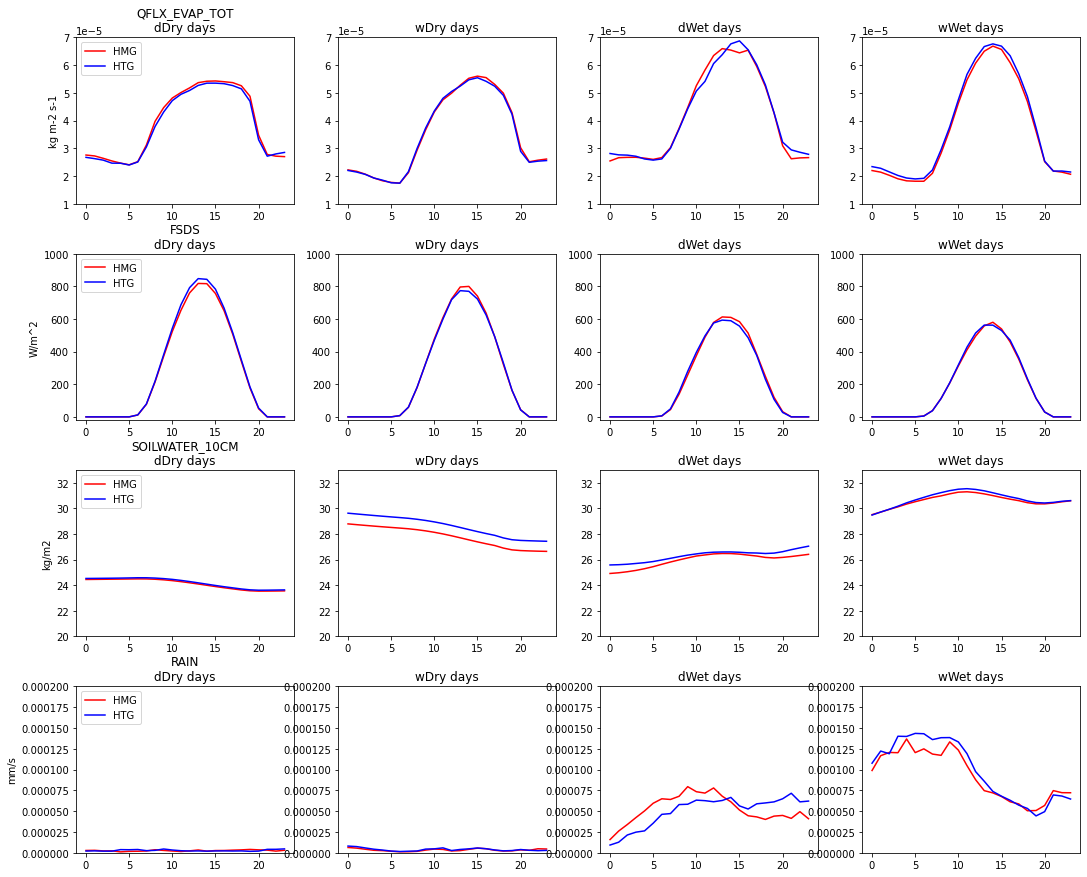

In [45]:
varSel = np.asarray(['QFLX_EVAP_TOT', 'FSDS','SOILWATER_10CM','RAIN'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([7e-5, 1000, 33, 2e-4])
yMin = np.asarray([1e-5, -20,  20, 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMeanCLM_dDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HMG[varSel[iVar]].values), 'r-', label='HMG')
    axs[iPlot+0].plot(hourlyMeanCLM_dDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_dDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[iPlot+0].set_ylabel(HTGclmDS_local['PBLH'].units)
    else: 
        axs[iPlot+0].set_ylabel(HTGclmDS_local[varSel[iVar]].units)
    

    axs[iPlot+1].plot(hourlyMeanCLM_wDry_HMG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMeanCLM_wDry_HTG.hour.values, np.squeeze(hourlyMeanCLM_wDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMeanCLM_dWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMeanCLM_dWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_dWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMeanCLM_wWet_HMG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMeanCLM_wWet_HTG.hour.values, np.squeeze(hourlyMeanCLM_wWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4



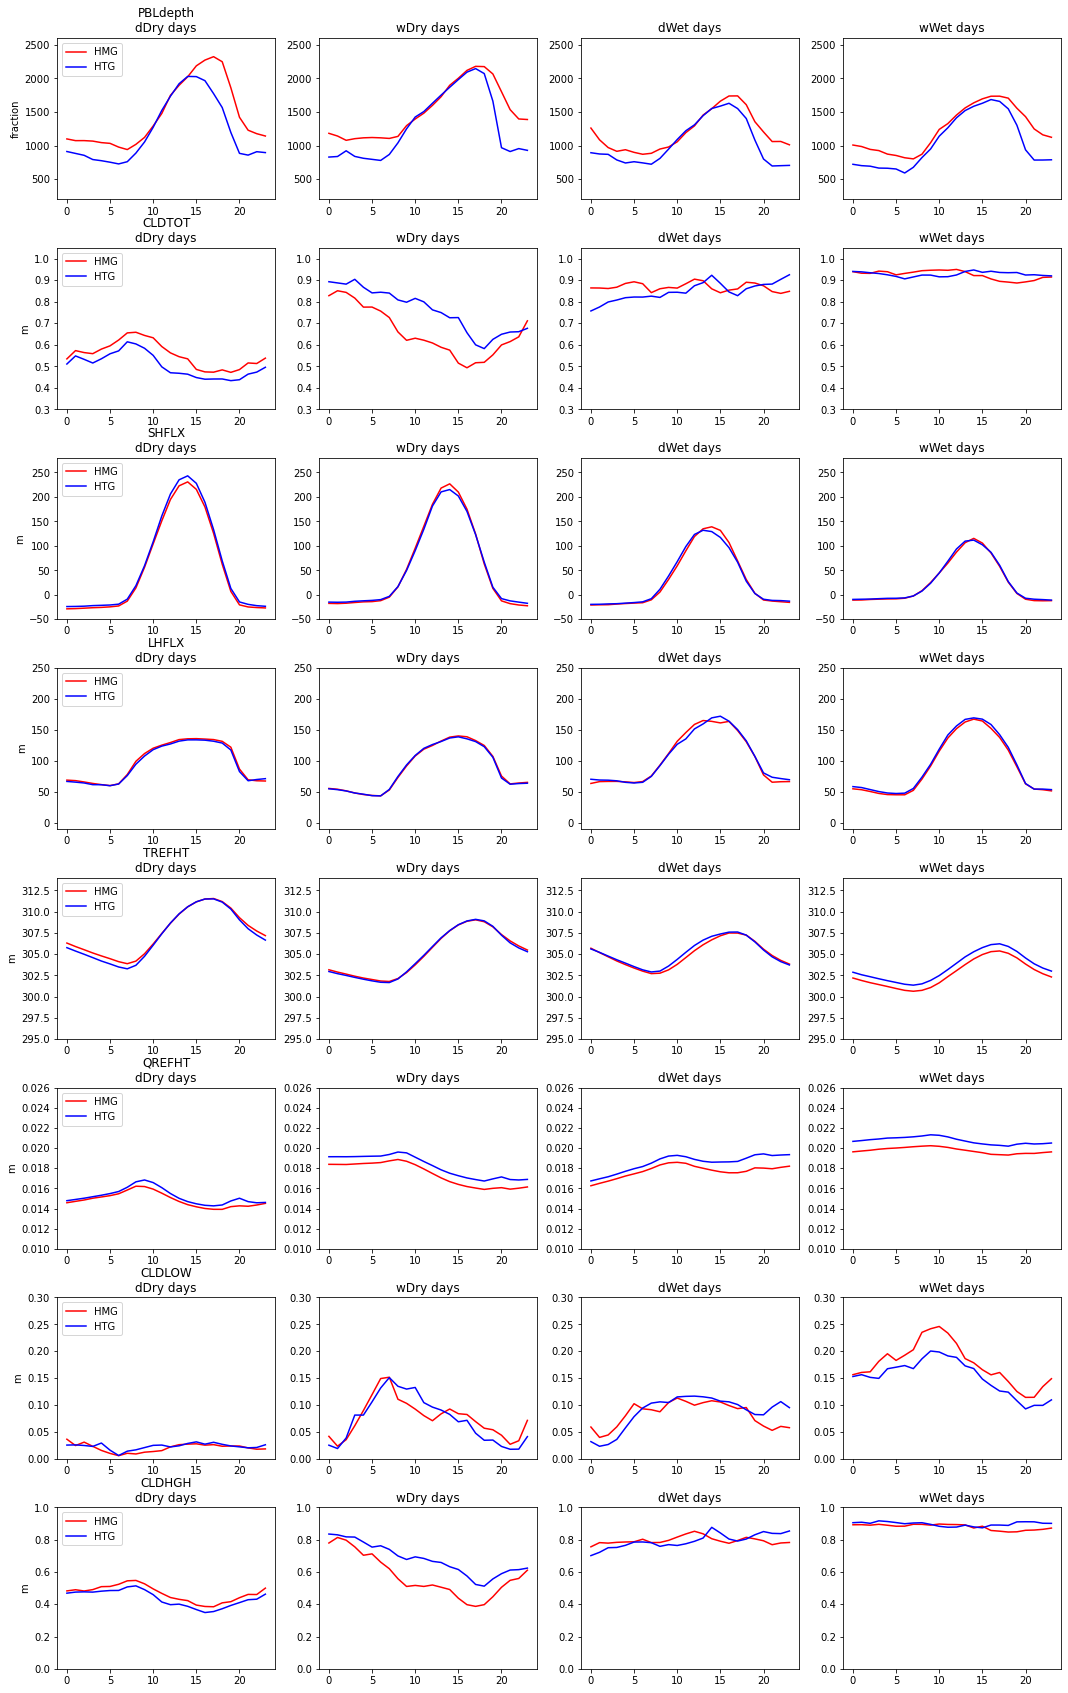

In [46]:
varSel = np.asarray(['PBLdepth','CLDTOT','SHFLX','LHFLX','TREFHT','QREFHT','CLDLOW','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,30))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2600, 1.05, 280, 250, 314, 0.0260, 0.3, 1.0])
yMin = np.asarray([ 200, 0.3,  -50, -10, 295, 0.0100, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 'r-', label='HMG')
    axs[iPlot+0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4




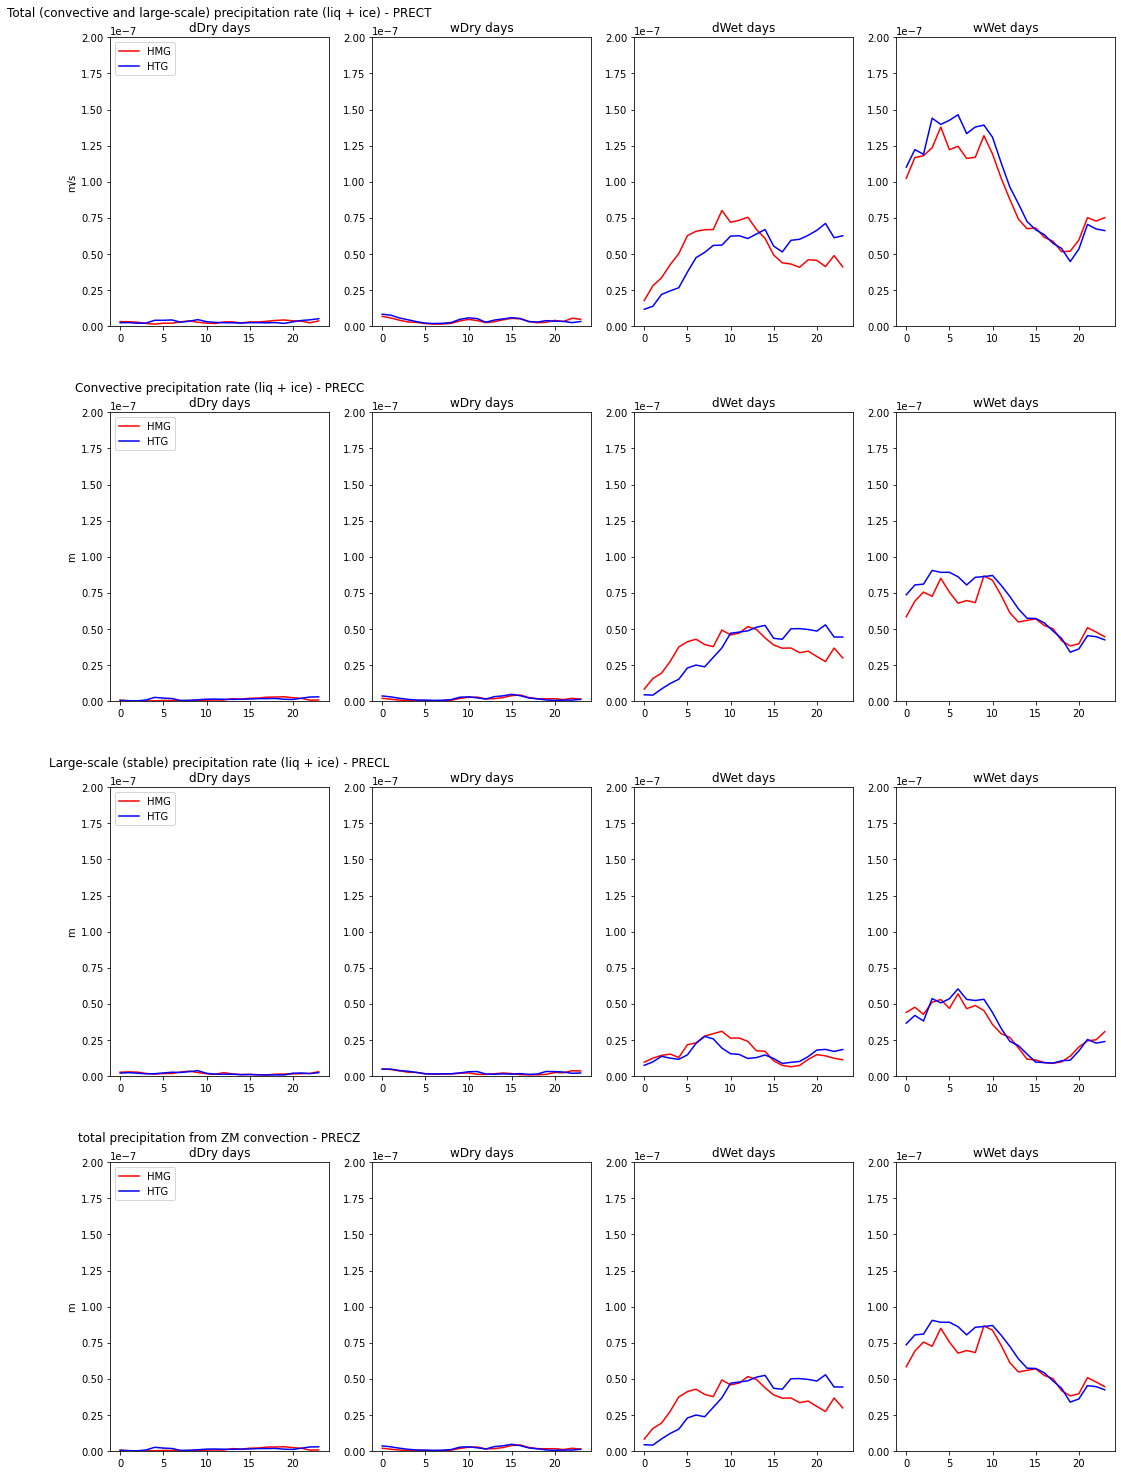

In [62]:
varSel = np.asarray(['PRECT','PRECC','PRECL','PRECZ'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2e-7, 2e-7, 2e-7, 2e-7])
yMin = np.asarray([ 0.0,  0.0,  0, 0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 'r-', label='HMG')
    axs[iPlot+0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(HTGcamDS_local[varSel[iVar]].long_name+' - '+varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






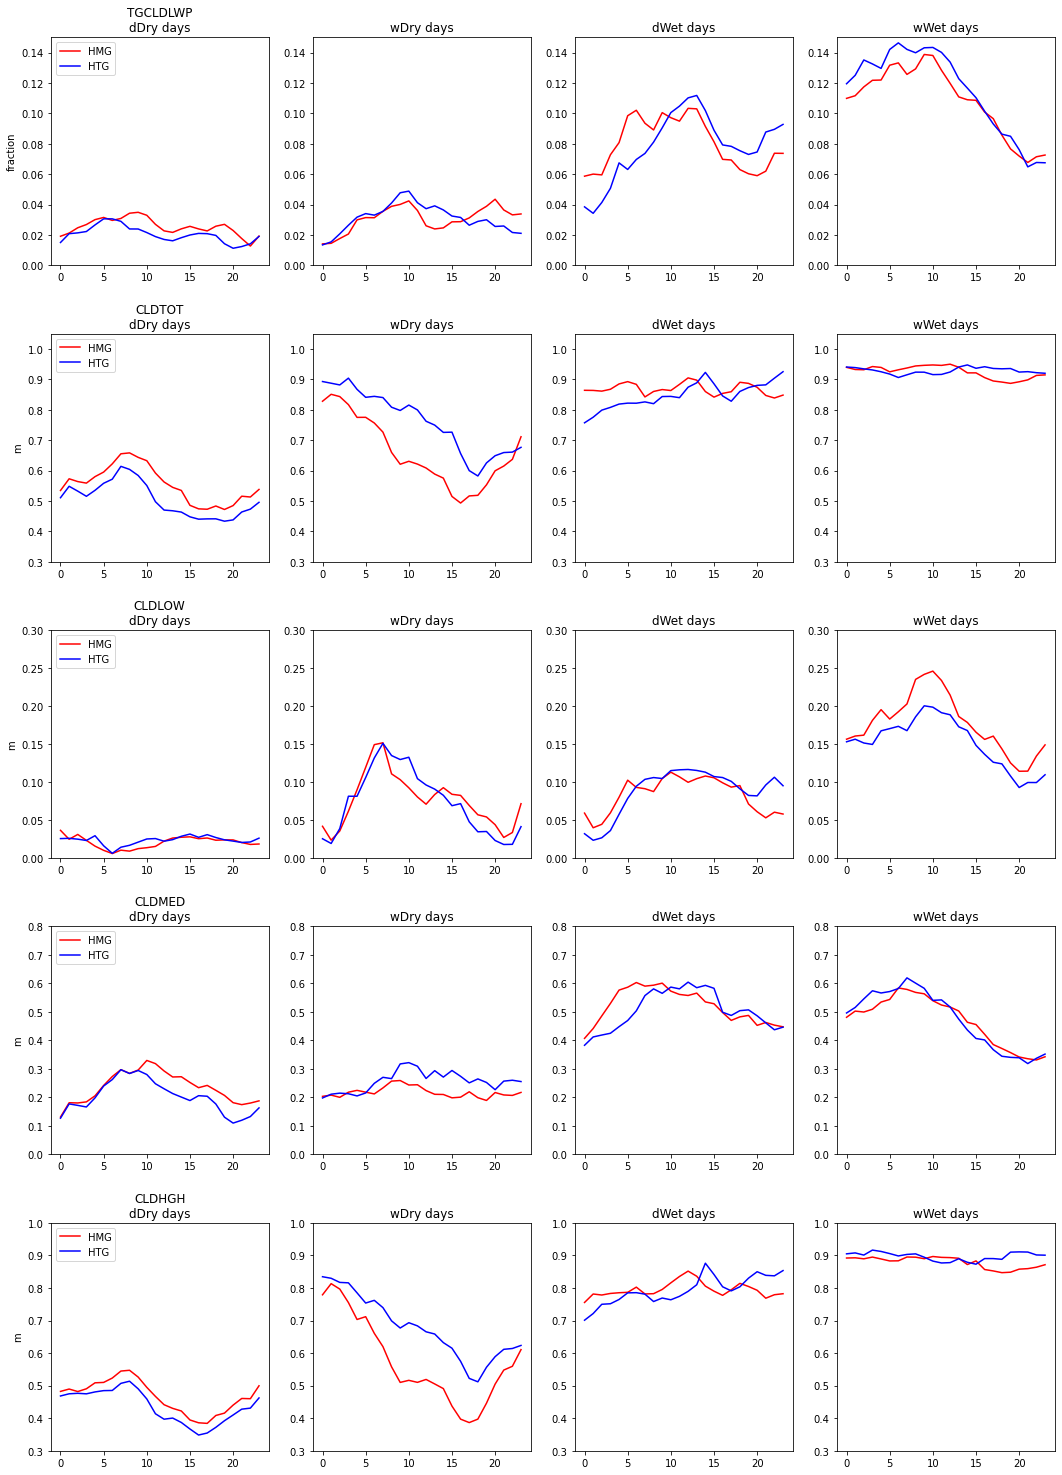

In [58]:
varSel = np.asarray(['TGCLDLWP','CLDTOT','CLDLOW','CLDMED','CLDHGH'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,26))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([0.15, 1.05, 0.3, 0.8, 1])
yMin = np.asarray([ 0.0,  0.3,  0, 0, 0.3])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values), 'r-', label='HMG')
    axs[iPlot+0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





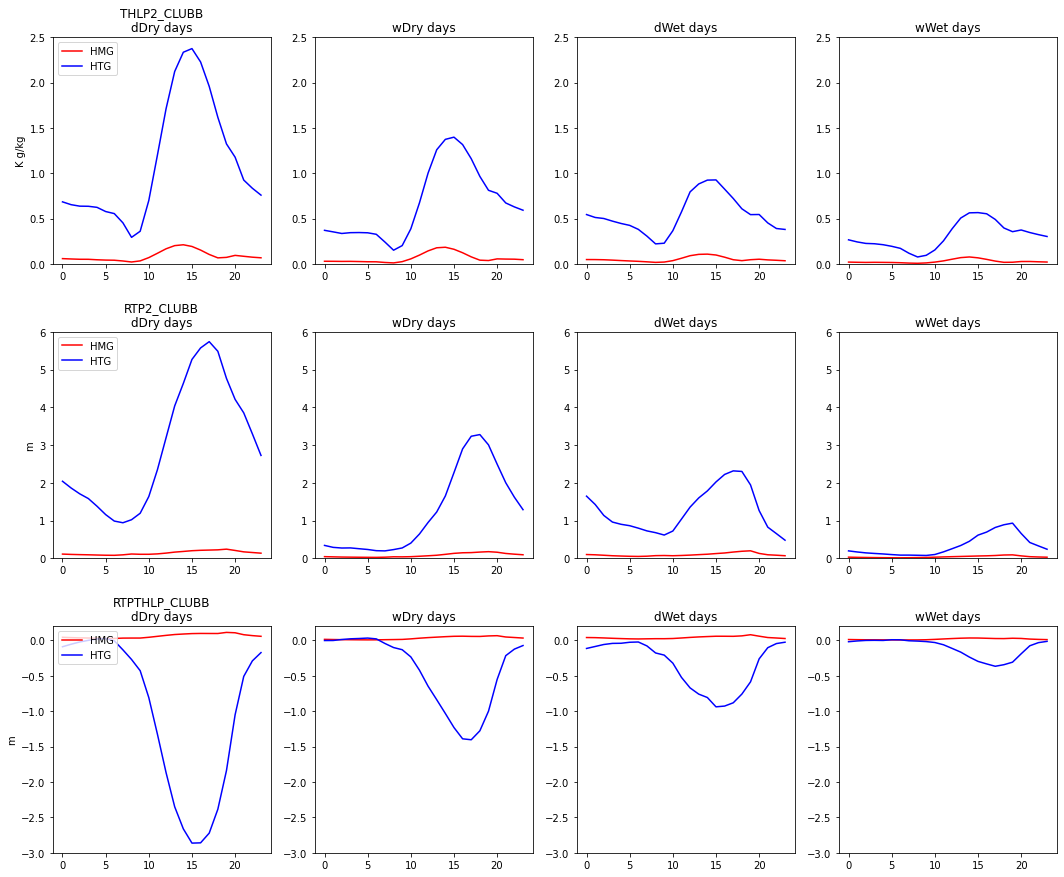

In [47]:
varSel = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([2.5, 6.0,  0.2])
yMin = np.asarray([0.0, 0.0, -3.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4





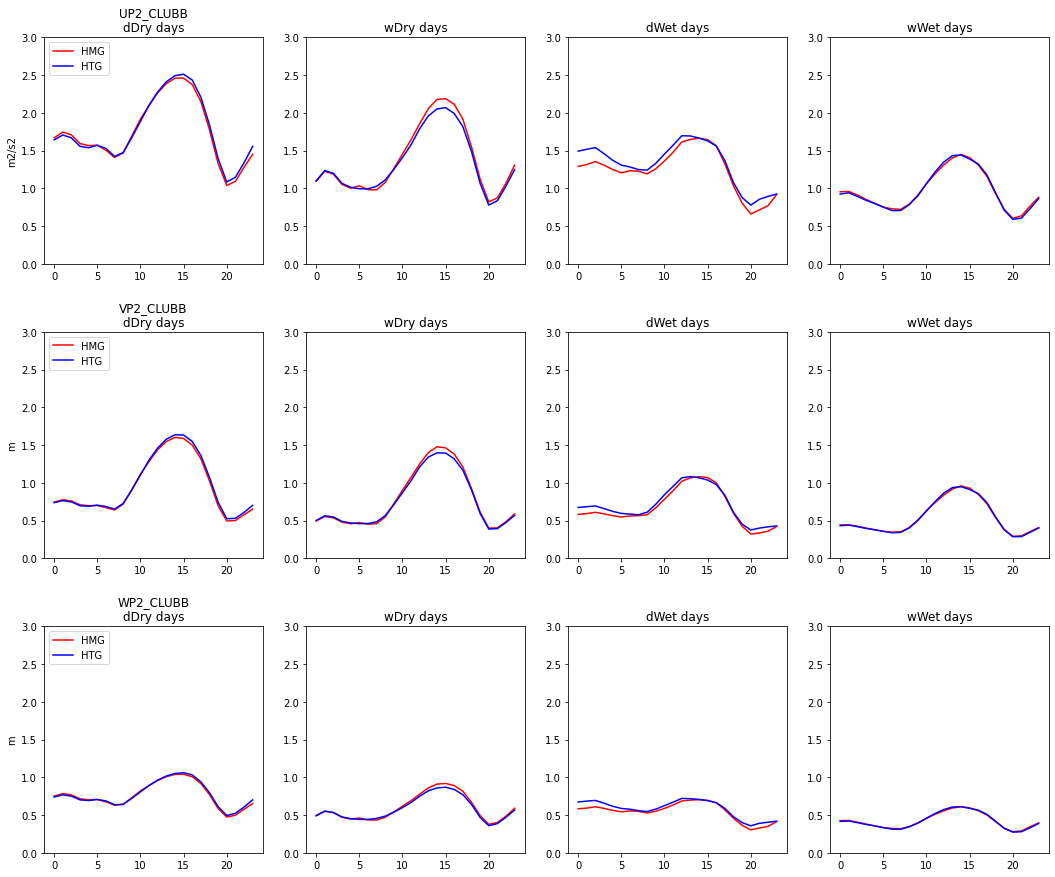

In [68]:
varSel = np.asarray(['UP2_CLUBB','VP2_CLUBB','WP2_CLUBB'])

fig,axs = plt.subplots(len(varSel),4, figsize=(18,15))
axs     = axs.ravel()
fig.subplots_adjust(hspace = 0.3)

# yMax = np.asarray([2600, 280, 250, 314, 0.0210, 1.05, 0.3, 1.0])
# yMin = np.asarray([ 200, -50, -10, 295, 0.0120, 0.3, 0.0, 0.0])
yMax = np.asarray([3, 3,  3])
yMin = np.asarray([0.0, 0.0, 0.0])

iPlot=0
for iVar in range(len(varSel)):
    axs[iPlot+0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+0].legend(loc='upper left')
    axs[iPlot+0].set_title(varSel[iVar]+'\ndDry days')
    if varSel[iVar]=='PBLdepth':
        axs[0].set_ylabel(HTGcamDS_local['PBLH'].units)
    else: 
        axs[0].set_ylabel(HTGcamDS_local[varSel[iVar]].units)
    axs[iPlot+0].set_ylabel('m')

    axs[iPlot+1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+1].set_title('\nwDry days')

    axs[iPlot+2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+2].set_title('\ndWet days')

    axs[iPlot+3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel[iVar]].values[:,-1,:,:]), 'r', label='HMG')
    axs[iPlot+3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel[iVar]].values[:,-1,:,:]), 'b', label='HTG')
    axs[iPlot+3].set_title('\nwWet days')
    
    axs[iPlot+0].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+1].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+2].set_ylim([yMin[iVar],yMax[iVar]])
    axs[iPlot+3].set_ylim([yMin[iVar],yMax[iVar]])
    
    iPlot = iPlot+4






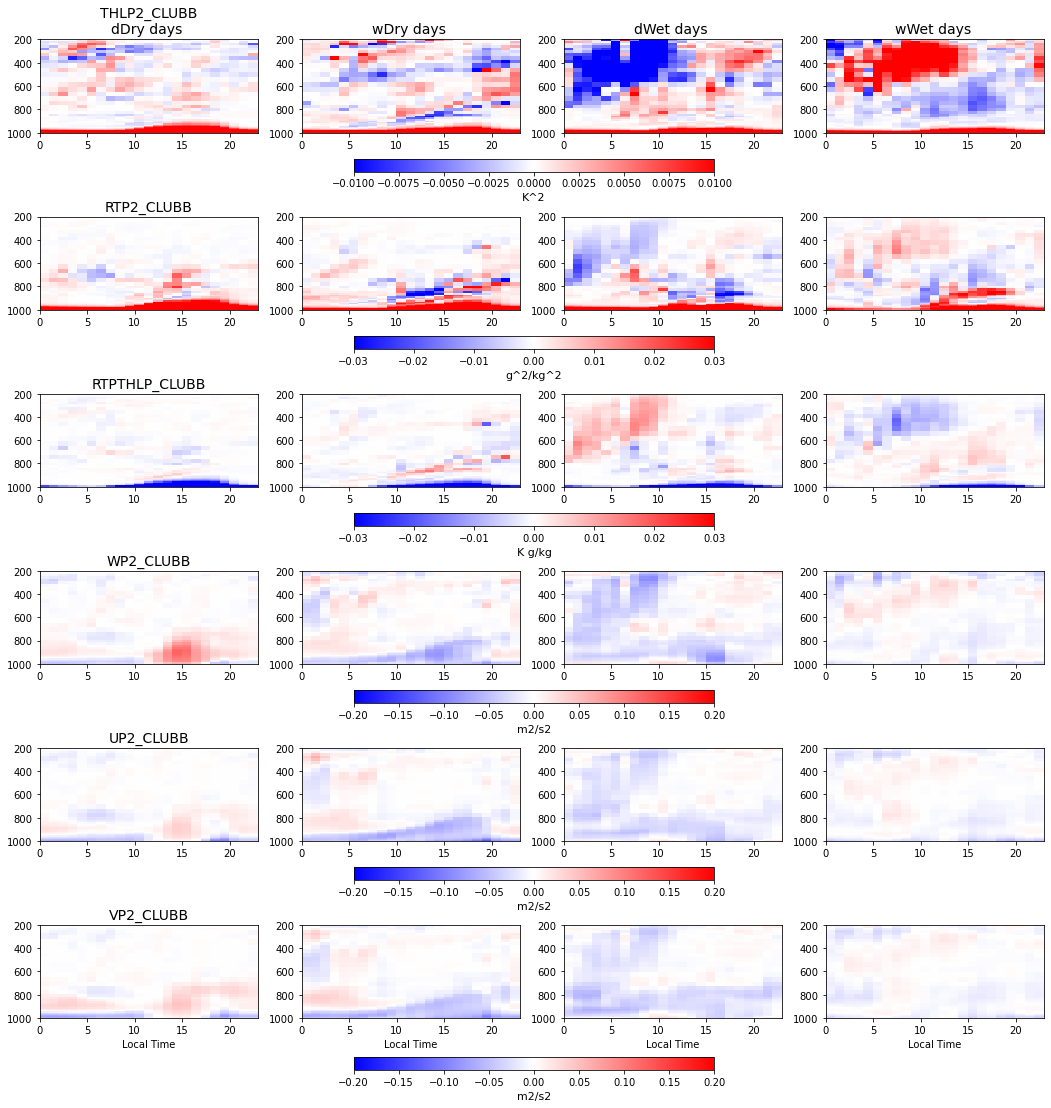

In [51]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB','VP2_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.01, 0.03, 0.03, 0.2, 0.2, 0.2])
yLim = 200

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(ATM_varNames[iVar],fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(ATM_varNames[iVar]+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

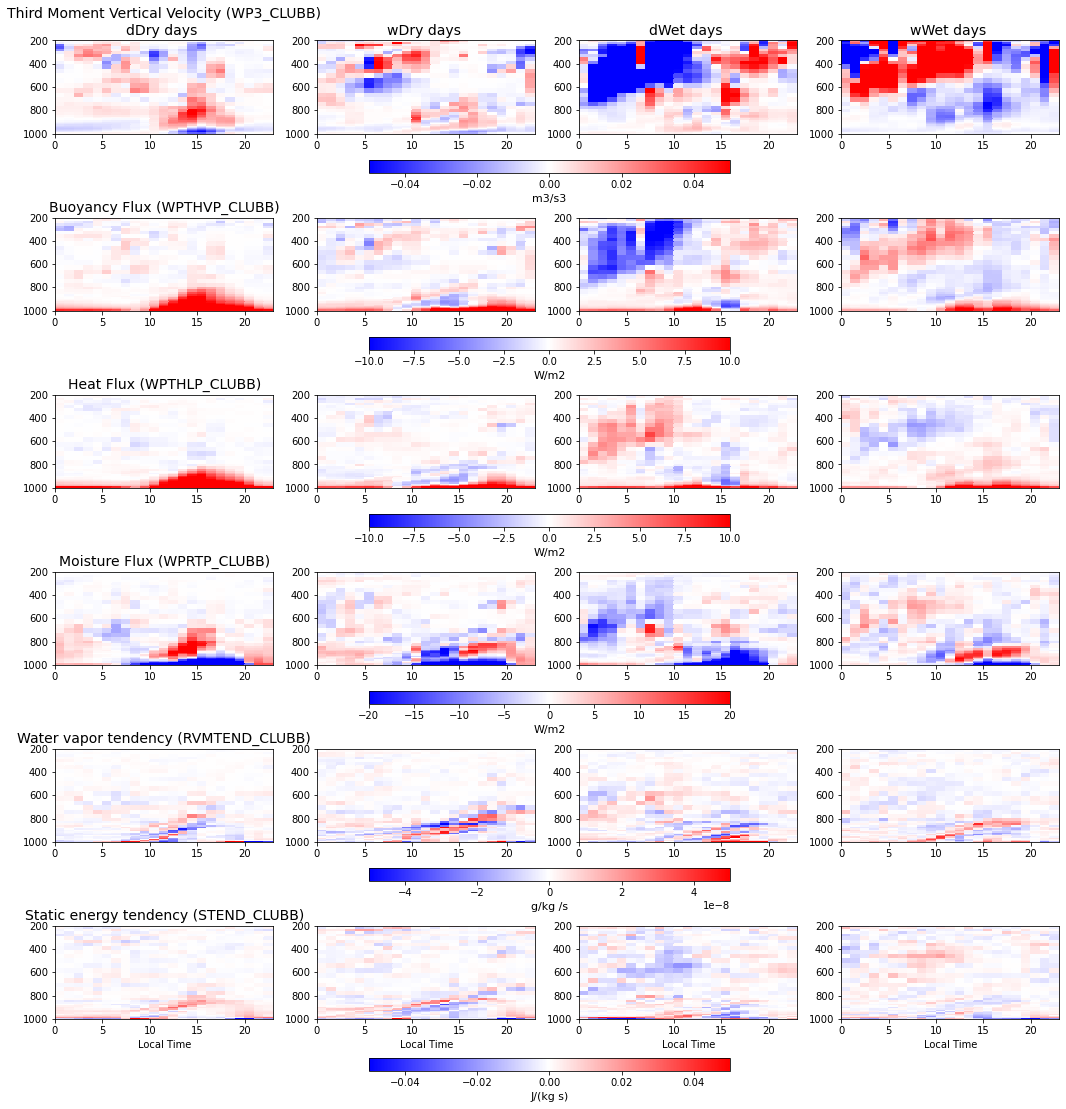

In [50]:
fig,axs = plt.subplots(6,4, figsize=(18,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.9)

ATM_varNames = np.asarray(['WP3_CLUBB','WPTHVP_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB'])
# Define limits on y-axis by variable
cMax = np.asarray([0.05, 10, 10, 20, 5e-8, 5e-2])
yLim = 200

iPlot = 0
for iVar in range(6): 
        
    ## dD days 
    diffVar = np.squeeze(hourlyMean_dDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot].pcolormesh(hourlyMean_dDry_HMG.hour.values, hourlyMean_dDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot].invert_yaxis()
    axs[iPlot].set_ylim([1000, yLim])
    
    
    ## wD days 
    diffVar = np.squeeze(hourlyMean_wDry_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wDry_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+1].pcolormesh(hourlyMean_wDry_HMG.hour.values, hourlyMean_wDry_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+1].invert_yaxis()
    axs[iPlot+1].set_ylim([1000, yLim])
    if iVar==5:
        # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.04, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)
    else: 
         # Add colorbar 
        ax_position = axs[iPlot+1].get_position()
        cbar_ax = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width+0.11, 0.01])
        cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(HTGcamDS_all[ATM_varNames[iVar]].units,fontsize=11)

    
    ## dW days 
    diffVar = np.squeeze(hourlyMean_dWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_dWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+2].pcolormesh(hourlyMean_dWet_HMG.hour.values, hourlyMean_dWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+2].invert_yaxis()
    axs[iPlot+2].set_ylim([1000, yLim])   
    
    ## wW days 
    diffVar = np.squeeze(hourlyMean_wWet_HTG[ATM_varNames[iVar]].values) - np.squeeze(hourlyMean_wWet_HMG[ATM_varNames[iVar]].values)
    contour_plot = axs[iPlot+3].pcolormesh(hourlyMean_wWet_HMG.hour.values, hourlyMean_wWet_HMG.ilev.values, 
                              diffVar.transpose(),
                             vmin=-cMax[iVar], vmax=cMax[iVar], cmap='bwr')
    axs[iPlot+3].invert_yaxis()
    axs[iPlot+3].set_ylim([1000, yLim])   
    
    axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')',fontsize=14)

    if iVar==0:
        axs[iPlot].set_title(HTGcamDS_all[ATM_varNames[iVar]].long_name+' ('+ATM_varNames[iVar]+')'+'\ndDry days ',fontsize=14)
        axs[iPlot+1].set_title('wDry days ',fontsize=14)
        axs[iPlot+2].set_title('dWet days ',fontsize=14)
        axs[iPlot+3].set_title('wWet days ',fontsize=14)
        
    if iVar==5:
        axs[iPlot].set_xlabel('Local Time')
        axs[iPlot+1].set_xlabel('Local Time')
        axs[iPlot+2].set_xlabel('Local Time')
        axs[iPlot+3].set_xlabel('Local Time')
    
    iPlot = iPlot+4
    

(200.0, 2700.0)

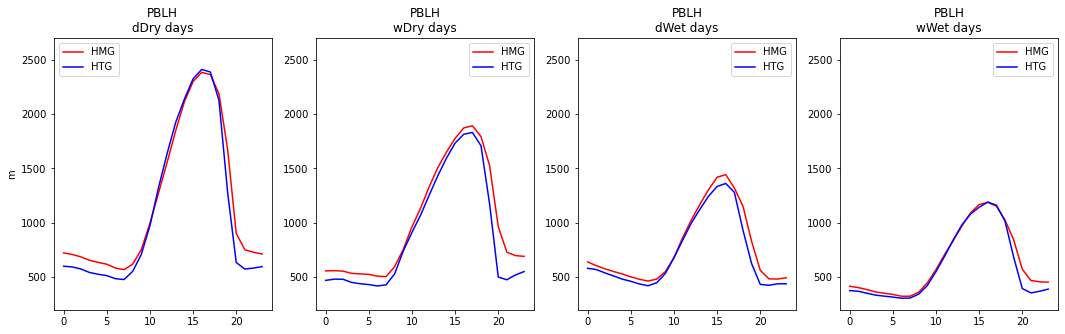

In [205]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'PBLH'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([200,2700])
axs[1].set_ylim([200,2700])
axs[2].set_ylim([200,2700])
axs[3].set_ylim([200,2700])


(200.0, 2700.0)

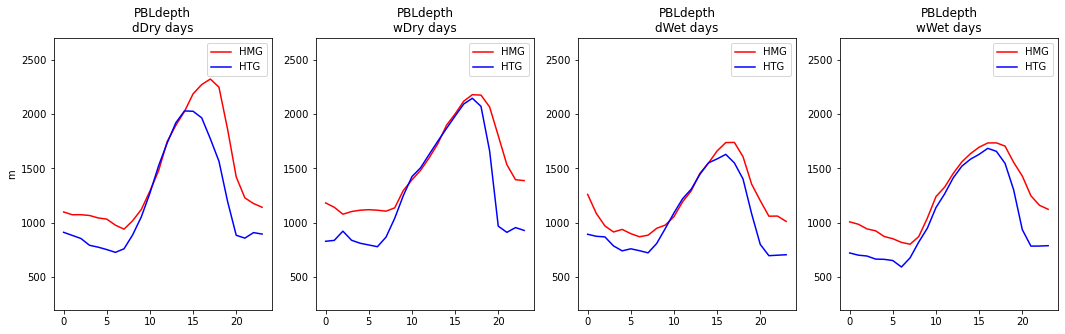

In [206]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'PBLdepth'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
#axs[0].set_ylabel(HTGcamDS_local[varSel].units)
axs[0].set_ylabel('m')

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([200,2700])
axs[1].set_ylim([200,2700])
axs[2].set_ylim([200,2700])
axs[3].set_ylim([200,2700])



(0.0, 0.15)

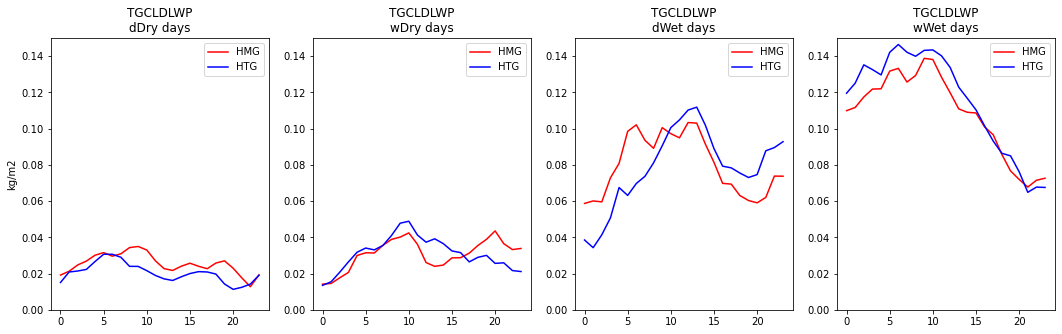

In [207]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'TGCLDLWP'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0,0.15])
axs[1].set_ylim([0,0.15])
axs[2].set_ylim([0,0.15])
axs[3].set_ylim([0,0.15])


(295.0, 315.0)

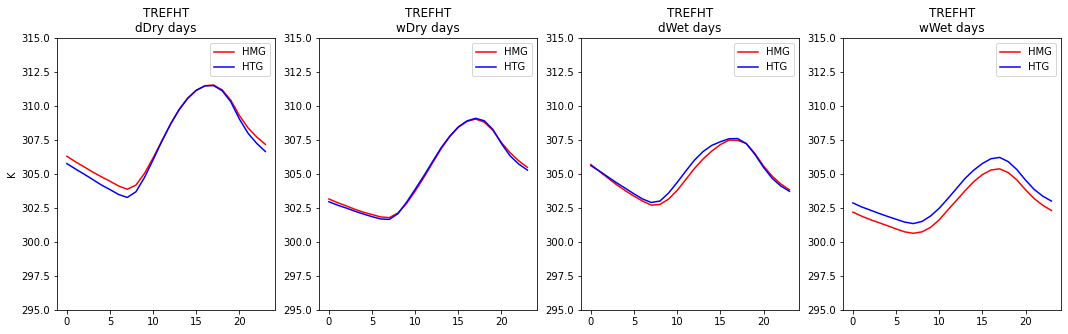

In [208]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'TREFHT'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([295,315])
axs[1].set_ylim([295,315])
axs[2].set_ylim([295,315])
axs[3].set_ylim([295,315])



(0.012, 0.023)

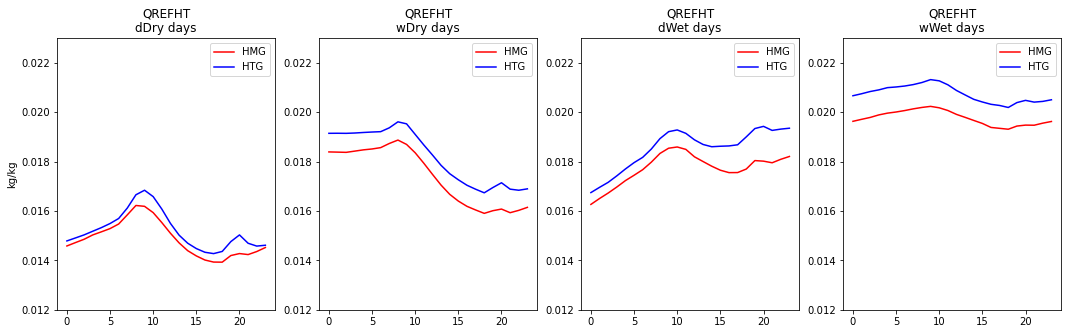

In [209]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'QREFHT'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0.012,0.023])
axs[1].set_ylim([0.012,0.023])
axs[2].set_ylim([0.012,0.023])
axs[3].set_ylim([0.012,0.023])


(-40.0, 275.0)

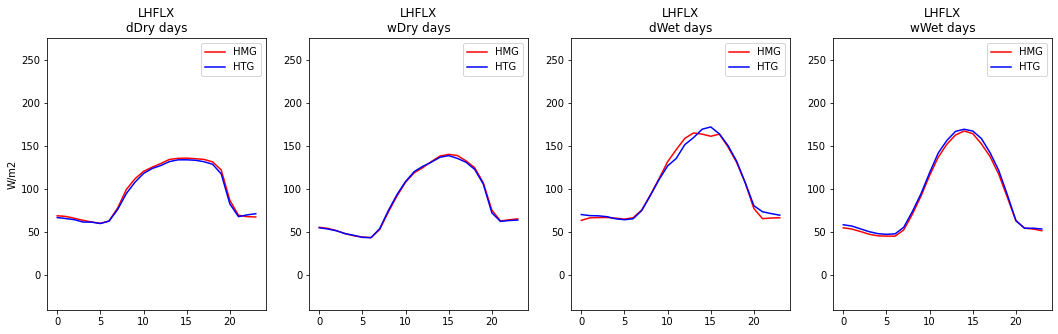

In [210]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'LHFLX'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([-40,275])
axs[1].set_ylim([-40,275])
axs[2].set_ylim([-40,275])
axs[3].set_ylim([-40,275])



(-40.0, 275.0)

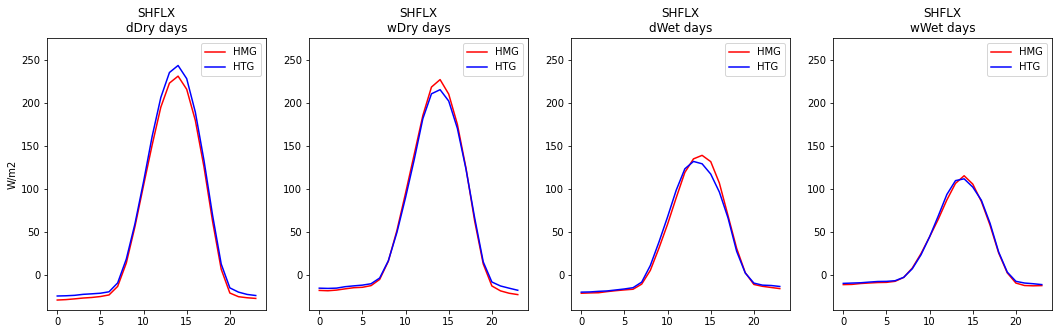

In [211]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'SHFLX'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([-40,275])
axs[1].set_ylim([-40,275])
axs[2].set_ylim([-40,275])
axs[3].set_ylim([-40,275])




(0.0, 2e-07)

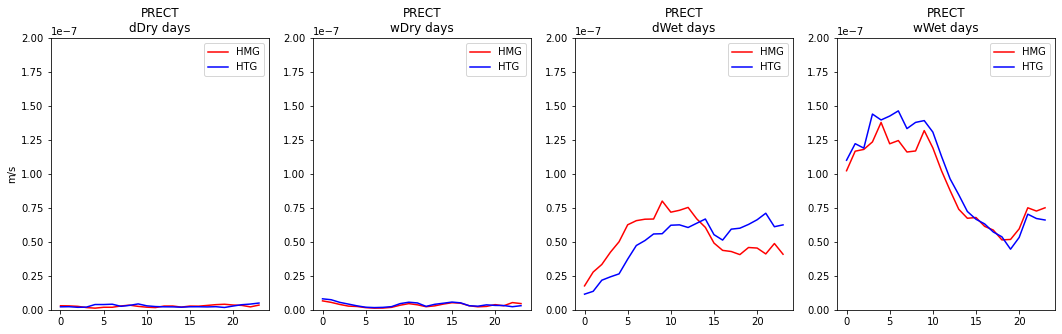

In [144]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'PRECT'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0,2e-7])
axs[1].set_ylim([0,2e-7])
axs[2].set_ylim([0,2e-7])
axs[3].set_ylim([0,2e-7])


(0.0, 2.5)

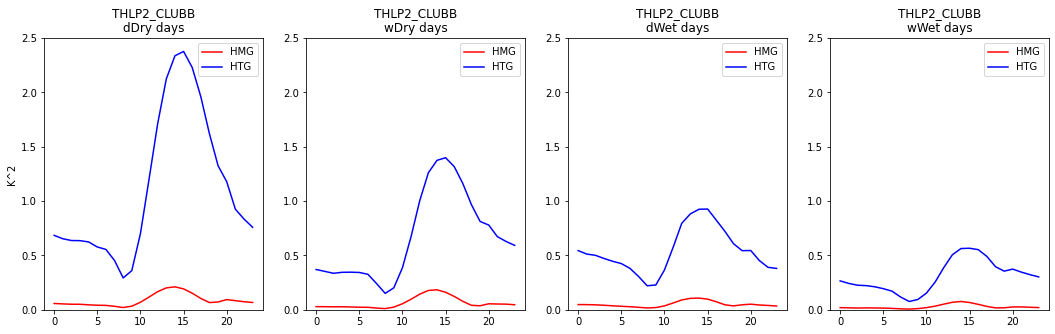

In [212]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'THLP2_CLUBB'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0,2.5])
axs[1].set_ylim([0,2.5])
axs[2].set_ylim([0,2.5])
axs[3].set_ylim([0,2.5])


(0.0, 6.0)

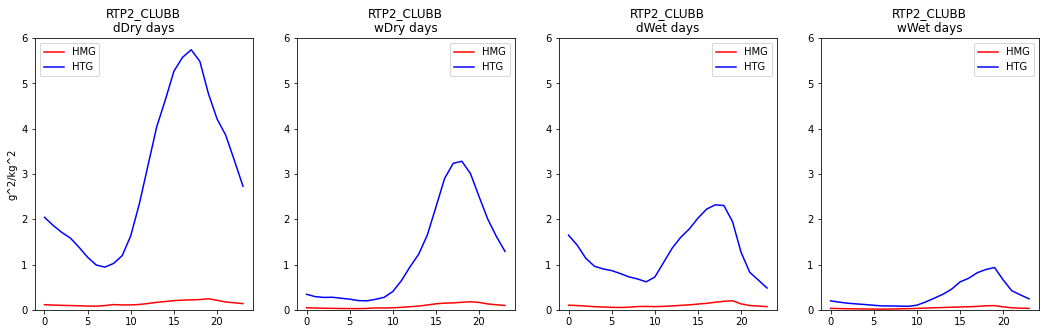

In [213]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'RTP2_CLUBB'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0,6])
axs[1].set_ylim([0,6])
axs[2].set_ylim([0,6])
axs[3].set_ylim([0,6])


(-3.0, 0.2)

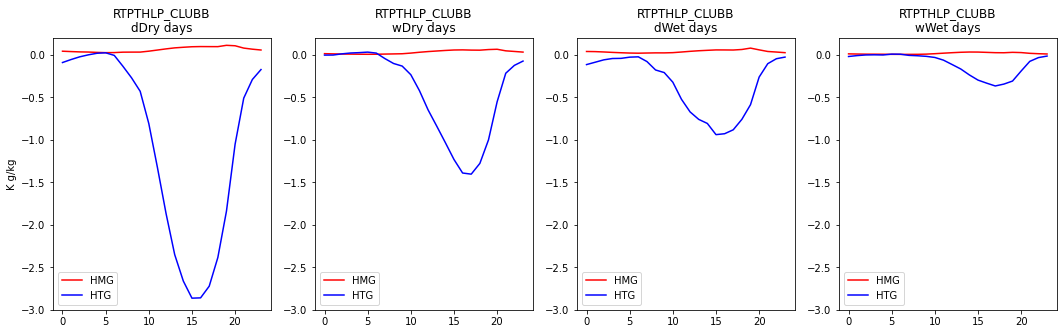

In [214]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'RTPTHLP_CLUBB'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([-3.0,0.2])
axs[1].set_ylim([-3.0,0.2])
axs[2].set_ylim([-3.0,0.2])
axs[3].set_ylim([-3.0,0.2])



(-0.08, 0.03)

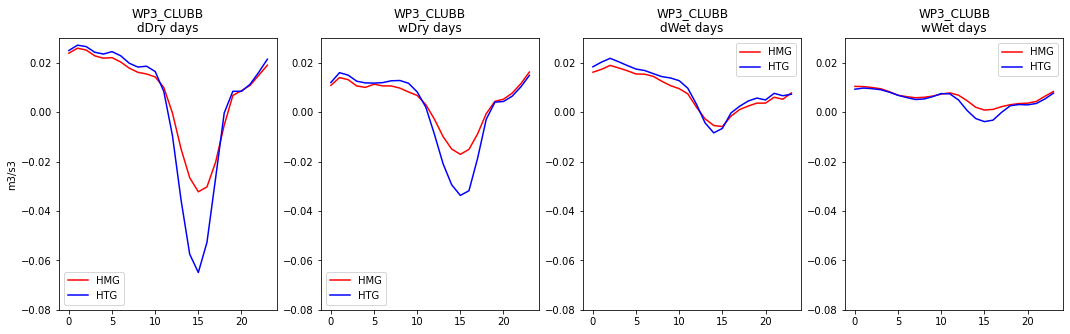

In [215]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'WP3_CLUBB'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values[:,-2,:,:]), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values[:,-2,:,:]), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values[:,-2,:,:]), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values[:,-2,:,:]), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values[:,-2,:,:]), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values[:,-2,:,:]), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values[:,-2,:,:]), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values[:,-2,:,:]), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([-0.08,0.03])
axs[1].set_ylim([-0.08,0.03])
axs[2].set_ylim([-0.08,0.03])
axs[3].set_ylim([-0.08,0.03])



(0.0, 1.3)

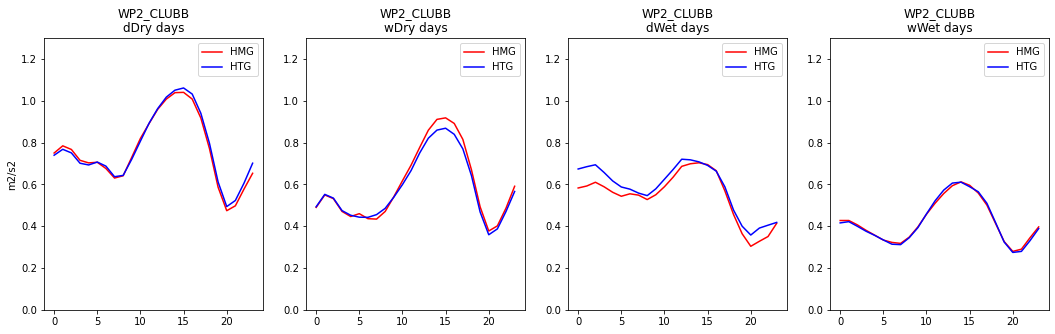

In [128]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'WP2_CLUBB'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0.0,1.3])
axs[1].set_ylim([0.0,1.3])
axs[2].set_ylim([0.0,1.3])
axs[3].set_ylim([0.0,1.3])


(0.0, 3.0)

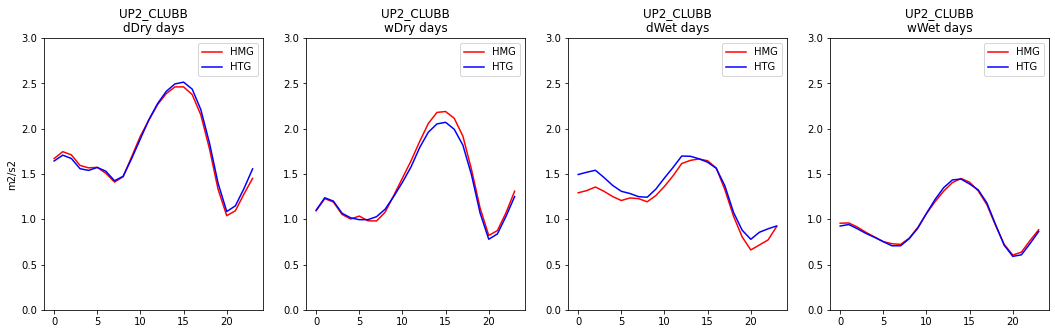

In [130]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs     = axs.ravel()

varSel = 'UP2_CLUBB'

axs[0].plot(hourlyMean_dDry_HMG.hour.values, np.squeeze(hourlyMean_dDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[0].plot(hourlyMean_dDry_HTG.hour.values, np.squeeze(hourlyMean_dDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[0].legend()
axs[0].set_title(varSel+'\ndDry days')
axs[0].set_ylabel(HTGcamDS_local[varSel].units)

axs[1].plot(hourlyMean_wDry_HMG.hour.values, np.squeeze(hourlyMean_wDry_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[1].plot(hourlyMean_wDry_HTG.hour.values, np.squeeze(hourlyMean_wDry_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[1].legend()
axs[1].set_title(varSel+'\nwDry days')

axs[2].plot(hourlyMean_dWet_HMG.hour.values, np.squeeze(hourlyMean_dWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[2].plot(hourlyMean_dWet_HTG.hour.values, np.squeeze(hourlyMean_dWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[2].legend()
axs[2].set_title(varSel+'\ndWet days')

axs[3].plot(hourlyMean_wWet_HMG.hour.values, np.squeeze(hourlyMean_wWet_HMG[varSel].values[:,-1,:,:]), 'r', label='HMG')
axs[3].plot(hourlyMean_wWet_HTG.hour.values, np.squeeze(hourlyMean_wWet_HTG[varSel].values[:,-1,:,:]), 'b', label='HTG')
axs[3].legend()
axs[3].set_title(varSel+'\nwWet days')

axs[0].set_ylim([0.0,3.0])
axs[1].set_ylim([0.0,3.0])
axs[2].set_ylim([0.0,3.0])
axs[3].set_ylim([0.0,3.0])



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nTHLP2_CLUBB')

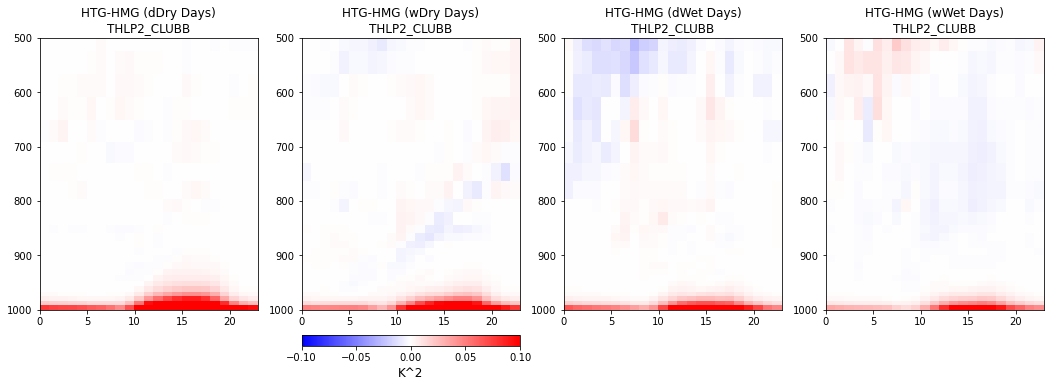

In [136]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'THLP2_CLUBB' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nRTP2_CLUBB')

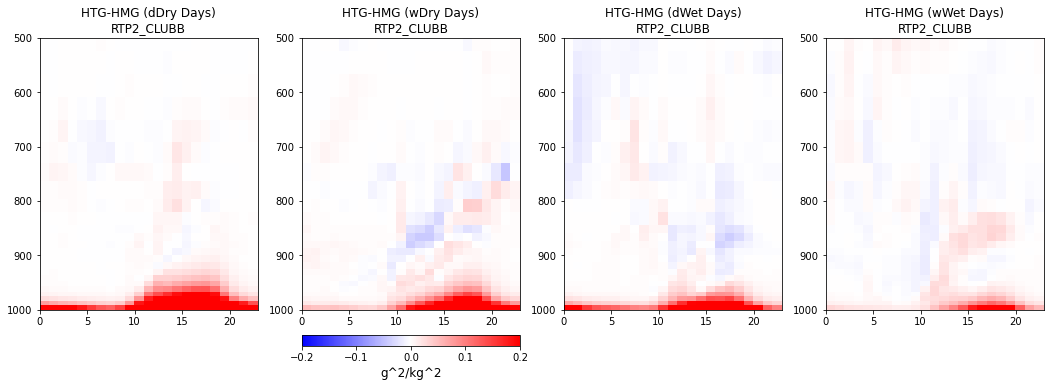

In [138]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'RTP2_CLUBB' 
cMin = -0.2
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nRTPTHLP_CLUBB')

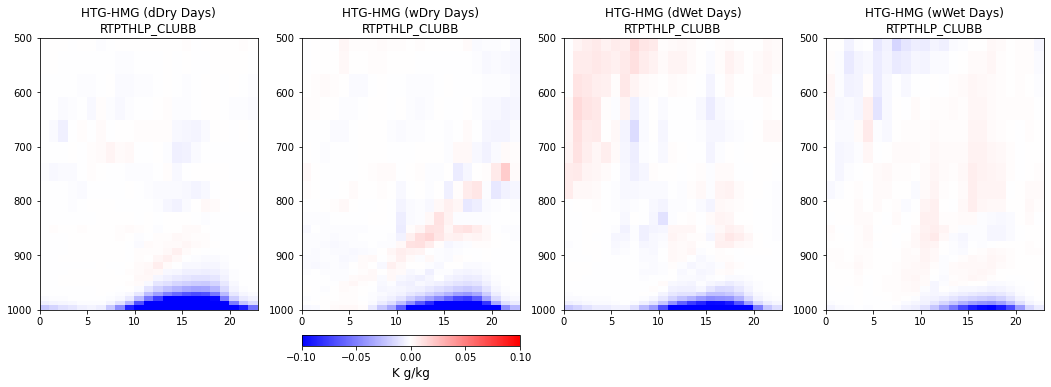

In [139]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'RTPTHLP_CLUBB' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nUP2_CLUBB')

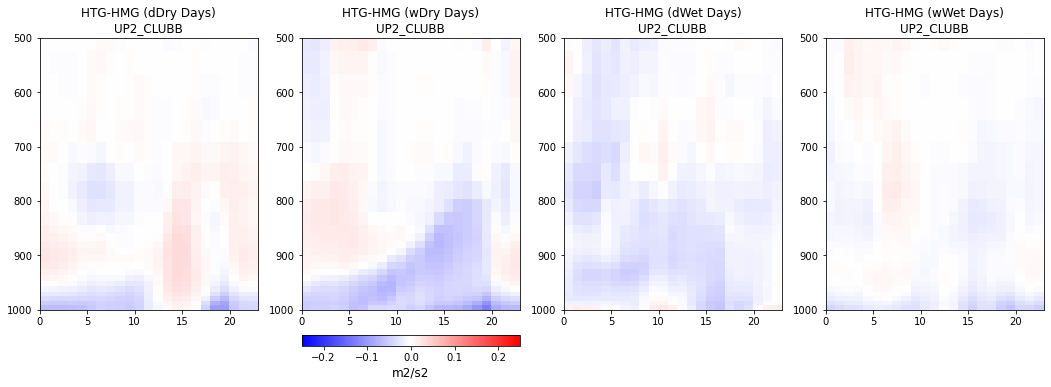

In [216]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'UP2_CLUBB' 
cMin = -0.25
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nWP2_CLUBB')

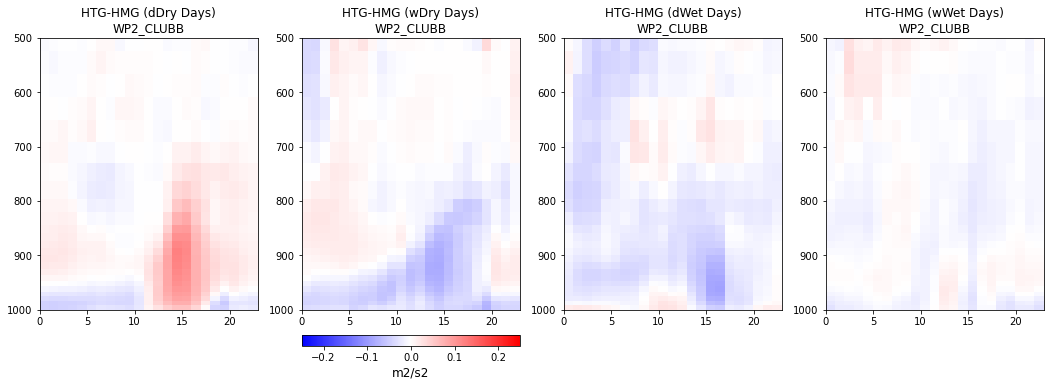

In [217]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'WP2_CLUBB' 
cMin = -0.25
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nWP3_CLUBB')

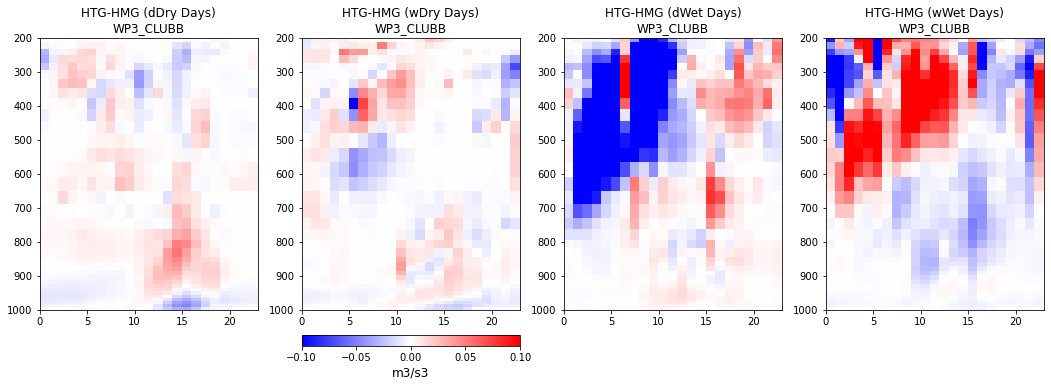

In [79]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'WP3_CLUBB' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nWPRTP_CLUBB')

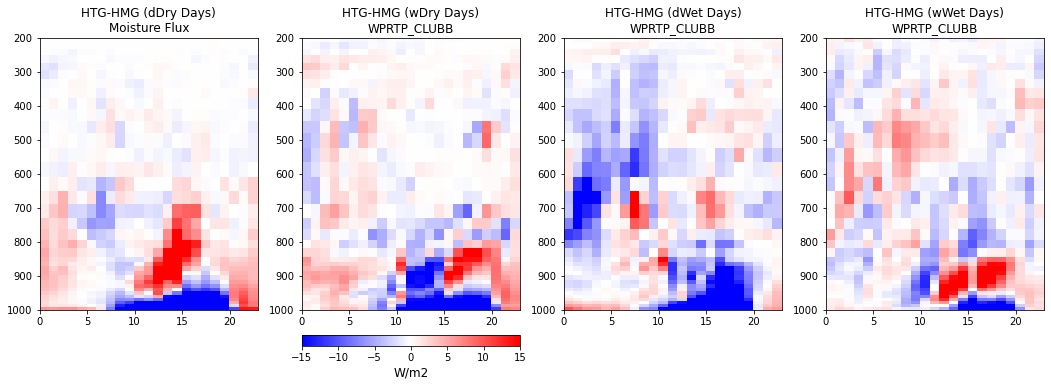

In [52]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'WPRTP_CLUBB' 
cMin = -15
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+HMGcamDS_local[varSel].long_name)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nWPTHLP_CLUBB')

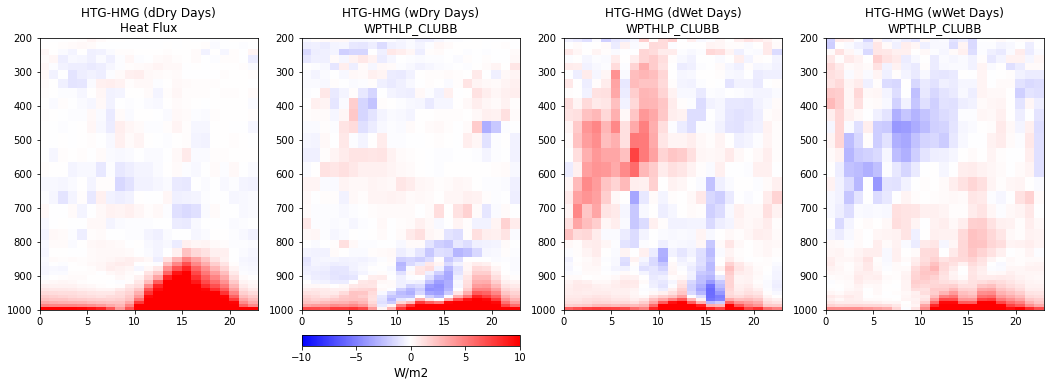

In [53]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'WPTHLP_CLUBB' 
cMin = -10
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+HMGcamDS_local[varSel].long_name)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nRVMTEND_CLUBB')

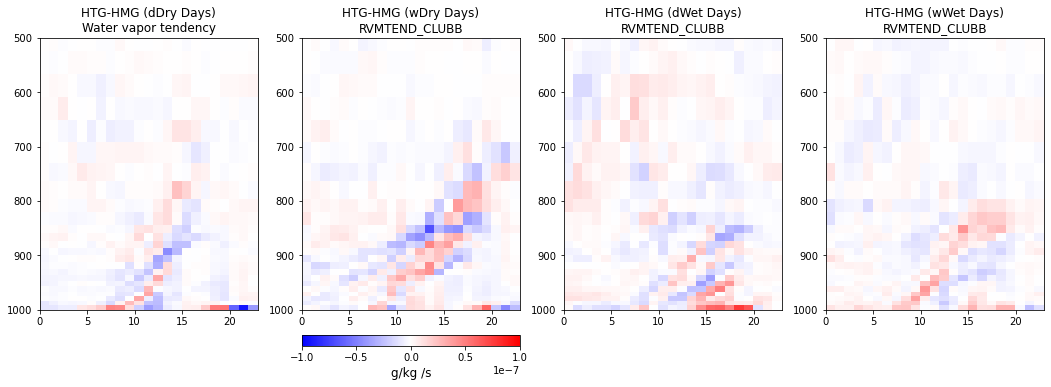

In [82]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'RVMTEND_CLUBB' 
cMin = -0.0000001
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+HMGcamDS_local[varSel].long_name)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nSTEND_CLUBB')

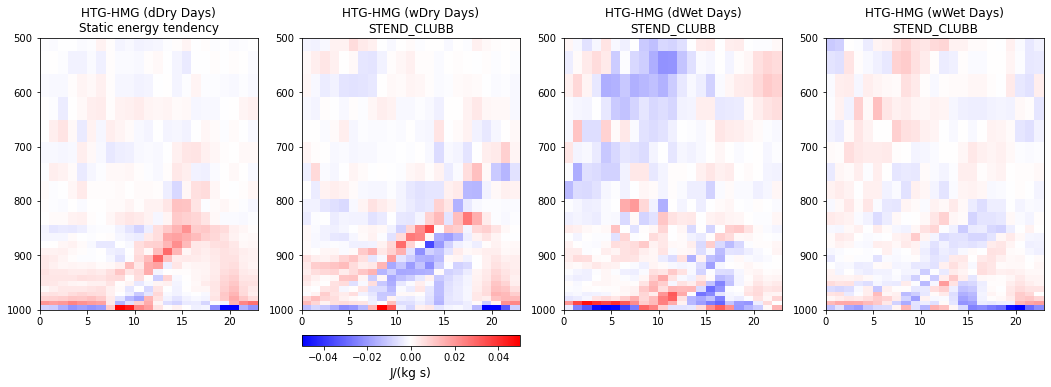

In [83]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'STEND_CLUBB' 
cMin = -0.05
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.ilev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.ilev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.ilev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.ilev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([500,1000])
axs[1].set_ylim([500,1000])
axs[2].set_ylim([500,1000])
axs[3].set_ylim([500,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+HMGcamDS_local[varSel].long_name)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)






Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nT')

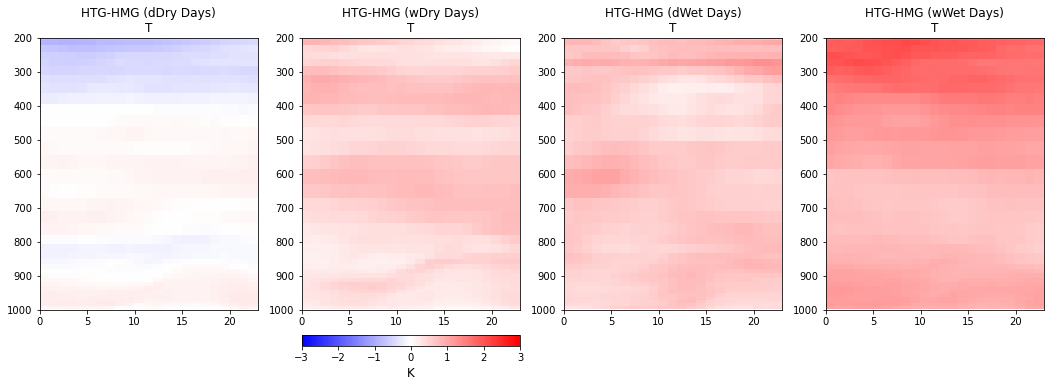

In [84]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = -3
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)


Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nT')

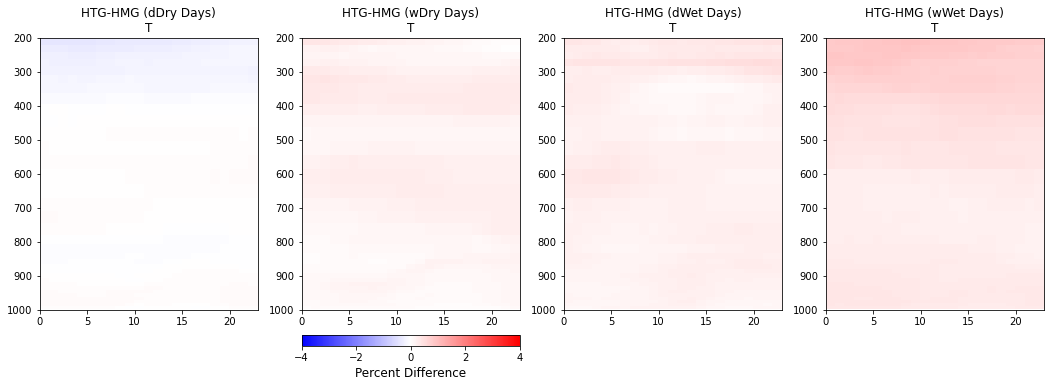

In [169]:
### Plot as percent difference
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'T' 
cMin = -4
cMax = -cMin 

# Define differences 
diffVar_dDry = (hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values)/hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = (hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values)/hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = (hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values)/hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = (hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values)/hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent Difference',fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nQ')

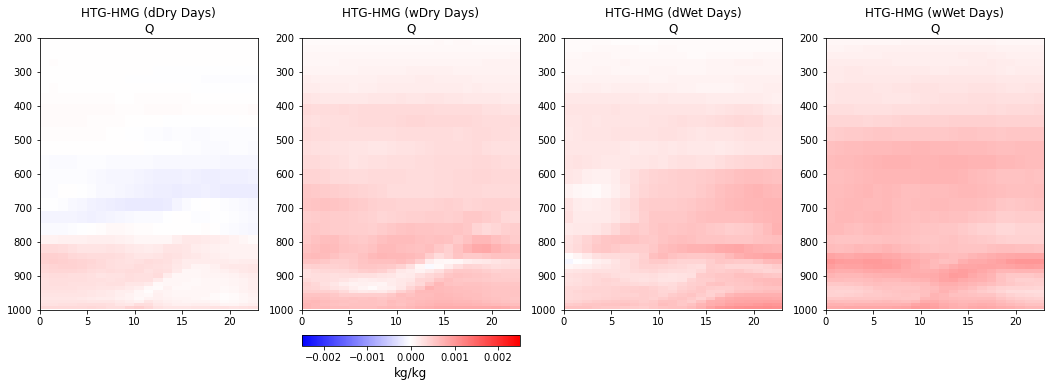

In [85]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'Q' 
cMin = -0.0025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)



Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nQ')

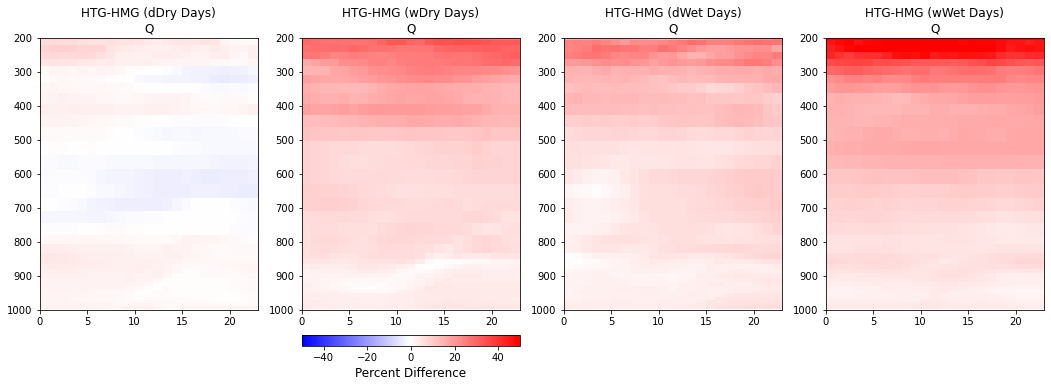

In [172]:
### Plot as percent difference
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'Q' 
cMin = -50
cMax = -cMin 

# Define differences 
diffVar_dDry = (hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values)/hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = (hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values)/hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = (hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values)/hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = (hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values)/hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent Difference',fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLDLIQ')

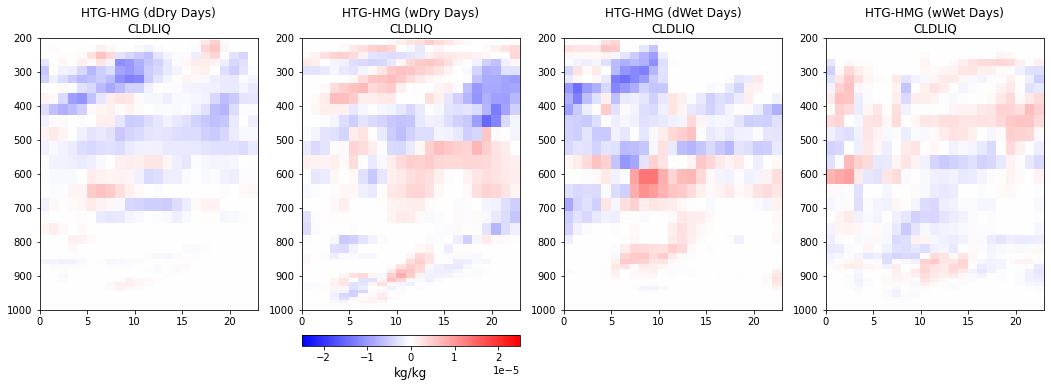

In [86]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLDLIQ' 
cMin = -0.000025
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)




Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLDLIQ')

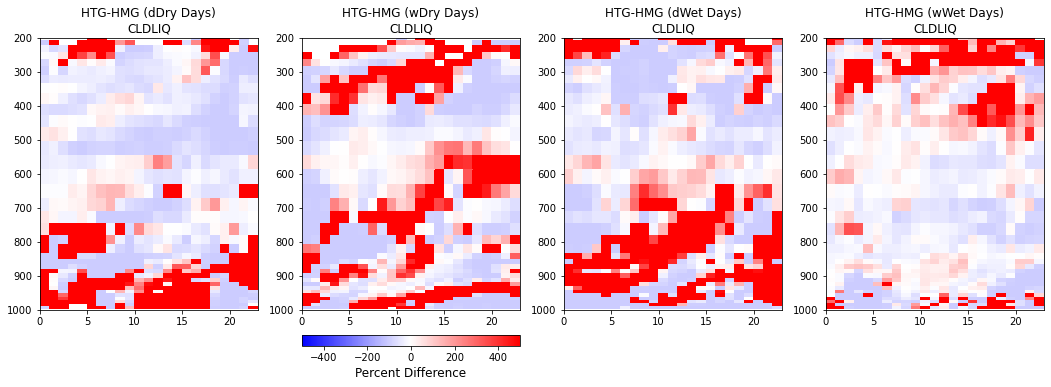

In [175]:
### Plot as percent difference
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLDLIQ' 
cMin = -500
cMax = -cMin 

# Define differences 
diffVar_dDry = (hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values)/hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = (hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values)/hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = (hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values)/hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = (hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values)/hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent Difference',fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLOUD')

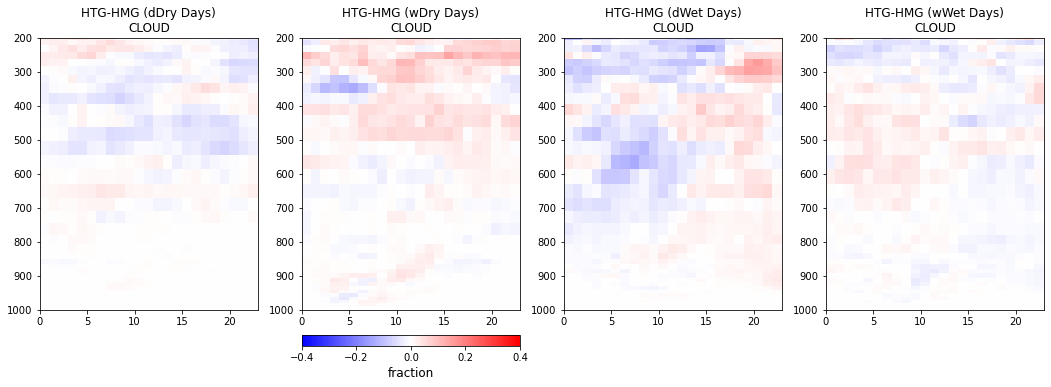

In [87]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLOUD' 
cMin = -0.4
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)





Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCLOUD')

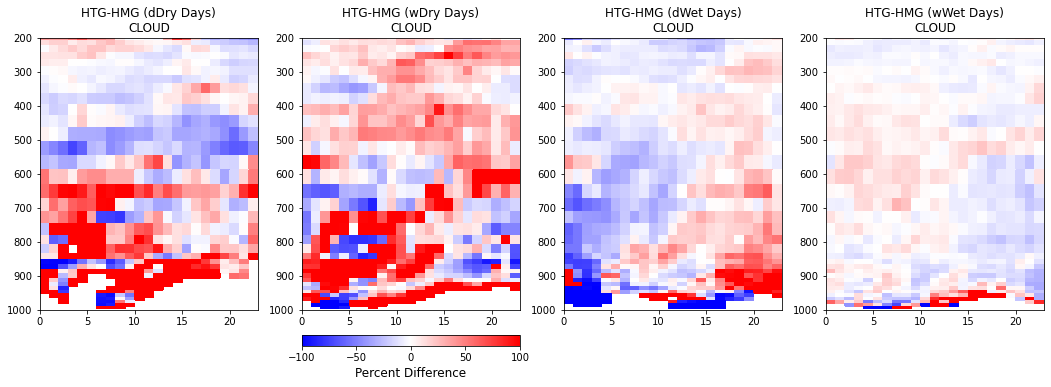

In [177]:
### Plot as percent difference
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CLOUD' 
cMin = -100
cMax = -cMin 

# Define differences 
diffVar_dDry = (hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values)/hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = (hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values)/hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = (hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values)/hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = (hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values)/hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('Percent Difference',fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet*100).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)






Text(0.5, 1.0, 'HTG-HMG (wWet Days)\nCONCLD')

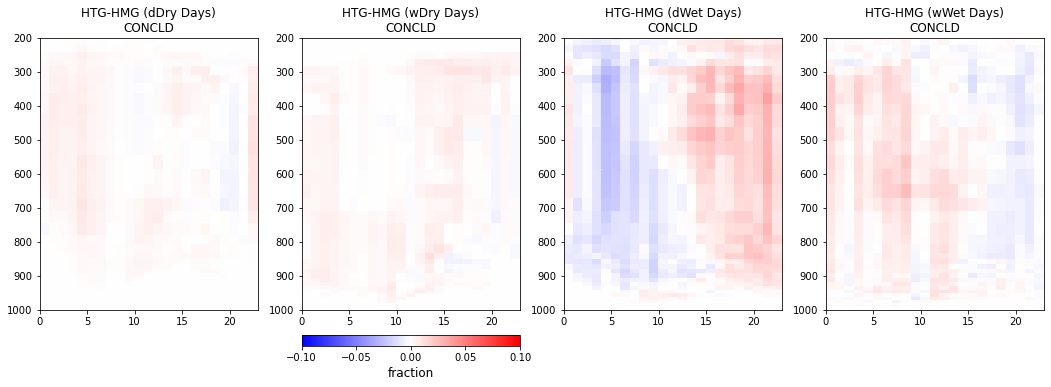

In [88]:
fig,axs = plt.subplots(1,4, figsize=(18,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace=0.5)

varSel  = 'CONCLD' 
cMin = -0.1
cMax = -cMin 

# Define differences 
diffVar_dDry = hourlyMean_dDry_HTG[varSel].values-hourlyMean_dDry_HMG[varSel].values
diffVar_wDry = hourlyMean_wDry_HTG[varSel].values-hourlyMean_wDry_HMG[varSel].values
diffVar_dWet = hourlyMean_dWet_HTG[varSel].values-hourlyMean_dWet_HMG[varSel].values
diffVar_wWet = hourlyMean_wWet_HTG[varSel].values-hourlyMean_wWet_HMG[varSel].values

contour_plot = axs[0].pcolormesh(hourlyMean_dDry_HTG.hour.values, hourlyMean_dDry_HTG.lev.values, 
                               np.squeeze(diffVar_dDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[1].pcolormesh(hourlyMean_wDry_HTG.hour.values, hourlyMean_wDry_HTG.lev.values, 
                               np.squeeze(diffVar_wDry).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(HMGcamDS_local[varSel].units,fontsize=12)

contour_plot = axs[2].pcolormesh(hourlyMean_dWet_HTG.hour.values, hourlyMean_dWet_HTG.lev.values, 
                               np.squeeze(diffVar_dWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')

contour_plot = axs[3].pcolormesh(hourlyMean_wWet_HTG.hour.values, hourlyMean_wWet_HTG.lev.values, 
                               np.squeeze(diffVar_wWet).transpose(), 
                               vmin=cMin, vmax=cMax,
                               cmap='bwr')


# Consistent settings 
axs[0].set_ylim([200,1000])
axs[1].set_ylim([200,1000])
axs[2].set_ylim([200,1000])
axs[3].set_ylim([200,1000])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_title('HTG-HMG (dDry Days)\n'+varSel)
axs[1].set_title('HTG-HMG (wDry Days)\n'+varSel)
axs[2].set_title('HTG-HMG (dWet Days)\n'+varSel)
axs[3].set_title('HTG-HMG (wWet Days)\n'+varSel)






In [153]:
'''
Plot mean vertical profiles over various time means (inclusive)
startHr and endHr are entered as 0-23
'''
def plotProfiles_timeOfDayMean(startHr, endHr, varSel, maxLev, xMin, xMax):
    
    ## First, get mean over those hours 
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((hourlyMean_dDry_HMG.hour>=startHr) & 
                                 (hourlyMean_dDry_HMG.hour<=endHr))[0]
    iTimeSel_dDryHTG = np.where((hourlyMean_dDry_HTG.hour>=startHr) & 
                                 (hourlyMean_dDry_HTG.hour<=endHr))[0]

    hourlyMean_dDryTimeSel_HMG = hourlyMean_dDry_HMG.isel(hour=iTimeSel_dDryHMG).mean(dim='hour')
    hourlyMean_dDryTimeSel_HTG = hourlyMean_dDry_HTG.isel(hour=iTimeSel_dDryHTG).mean(dim='hour')


    # ------- wDry days ----------
    iTimeSel_wDryHMG = np.where((hourlyMean_wDry_HMG.hour>=startHr) & 
                               (hourlyMean_wDry_HMG.hour<=endHr))[0]
    iTimeSel_wDryHTG = np.where((hourlyMean_wDry_HTG.hour>=startHr) & 
                               (hourlyMean_wDry_HTG.hour<=endHr))[0]

    hourlyMean_wDryTimeSel_HMG = hourlyMean_wDry_HMG.isel(hour=iTimeSel_wDryHMG).mean(dim='hour')
    hourlyMean_wDryTimeSel_HTG = hourlyMean_wDry_HTG.isel(hour=iTimeSel_wDryHTG).mean(dim='hour')


    # ------- dWet days ----------
    iTimeSel_dWetHMG = np.where((hourlyMean_dWet_HMG.hour>=startHr) & 
                               (hourlyMean_dWet_HMG.hour<=endHr))[0]
    iTimeSel_dWetHTG = np.where((hourlyMean_dWet_HTG.hour>=startHr) & 
                               (hourlyMean_dWet_HTG.hour<=endHr))[0]

    hourlyMean_dWetTimeSel_HMG = hourlyMean_dWet_HMG.isel(hour=iTimeSel_dWetHMG).mean(dim='hour')
    hourlyMean_dWetTimeSel_HTG = hourlyMean_dWet_HTG.isel(hour=iTimeSel_dWetHTG).mean(dim='hour')


    # ------- wWet days ----------
    iTimeSel_wWetHMG = np.where((hourlyMean_wWet_HMG.hour>=startHr) & 
                               (hourlyMean_wWet_HMG.hour<=endHr))[0]
    iTimeSel_wWetHTG = np.where((hourlyMean_wWet_HTG.hour>=startHr) & 
                               (hourlyMean_wWet_HTG.hour<=endHr))[0]

    hourlyMean_wWetTimeSel_HMG = hourlyMean_wWet_HMG.isel(hour=iTimeSel_wWetHMG).mean(dim='hour')
    hourlyMean_wWetTimeSel_HTG = hourlyMean_wWet_HTG.isel(hour=iTimeSel_wWetHTG).mean(dim='hour')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    
    
    
    ## Now we can figure out how to plot! 
    fig,axs = plt.subplots(1,4, figsize=(17,6))
    axs     = axs.ravel()
    
    # Select which levels array to use
    if np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.ilev.values): 
        levSel = 'ilev'
    elif np.shape(hourlyMean_wWetTimeSel_HMG[varSel].values)[0]==len(hourlyMean_wWetTimeSel_HMG.lev.values):
        levSel = 'lev'
    
    # Plot dDry days 
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HMG[varSel].values), hourlyMean_dDryTimeSel_HMG[levSel].values,
                'r-', label='HMG')
    axs[0].plot(np.squeeze(hourlyMean_dDryTimeSel_HTG[varSel].values), hourlyMean_dDryTimeSel_HTG[levSel].values,
                'b', label='HTG')
    axs[0].legend()
    axs[0].set_title(varSel+'\ndDry days ('+str(startHr)+'-'+str(endHr)+' mean)')
    axs[0].set_ylabel(HTGcamDS_local[varSel].units)

    # Plot wDry days 
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HMG[varSel].values), hourlyMean_wDryTimeSel_HMG[levSel].values,
                'r', label='HMG')
    axs[1].plot(np.squeeze(hourlyMean_wDryTimeSel_HTG[varSel].values), hourlyMean_wDryTimeSel_HTG[levSel].values,
                'b', label='HTG')
    axs[1].set_title(varSel+'\nwDry days')

    # Plot dWet days 
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HMG[varSel].values), hourlyMean_dWetTimeSel_HMG[levSel].values,
                'r', label='HMG')
    axs[2].plot(np.squeeze(hourlyMean_dWetTimeSel_HTG[varSel].values), hourlyMean_dWetTimeSel_HTG[levSel].values,
                'b', label='HTG')
    axs[2].set_title(varSel+'\ndWet days')

    # Plot wWet days 
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HMG[varSel].values), hourlyMean_wWetTimeSel_HMG[levSel].values,
                'r', label='HMG')
    axs[3].plot(np.squeeze(hourlyMean_wWetTimeSel_HTG[varSel].values), hourlyMean_wWetTimeSel_HTG[levSel].values,
                'b', label='HTG')
    axs[3].legend()
    axs[3].set_title(varSel+'\nwWet days')

    # Consistent settings across subplots 
    axs[0].set_ylim([maxLev,1000])
    axs[1].set_ylim([maxLev,1000])
    axs[2].set_ylim([maxLev,1000])
    axs[3].set_ylim([maxLev,1000])
    
    axs[0].set_xlim([xMin,xMax])
    axs[1].set_xlim([xMin,xMax])
    axs[2].set_xlim([xMin,xMax])
    axs[3].set_xlim([xMin,xMax])
    
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    axs[3].invert_yaxis()
    
    return

Means computed over the inclusive period of 8 to 10.


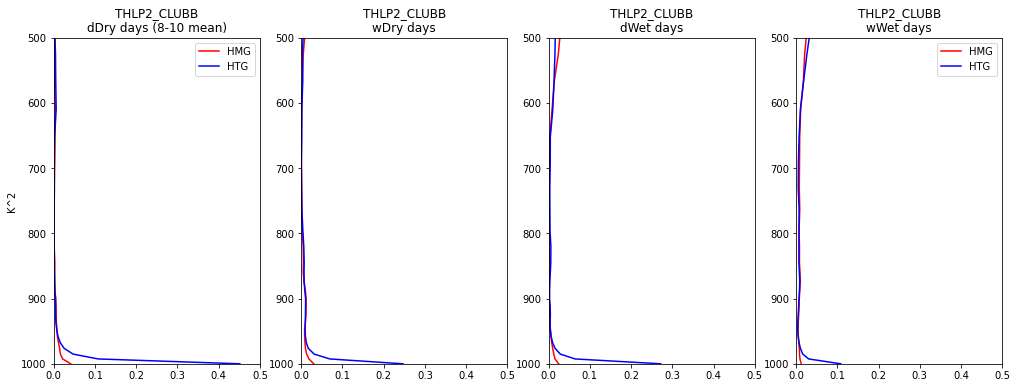

In [156]:
plotProfiles_timeOfDayMean(8, 10, 'THLP2_CLUBB', 500, 
                           0.0, 0.5)

Means computed over the inclusive period of 8 to 10.


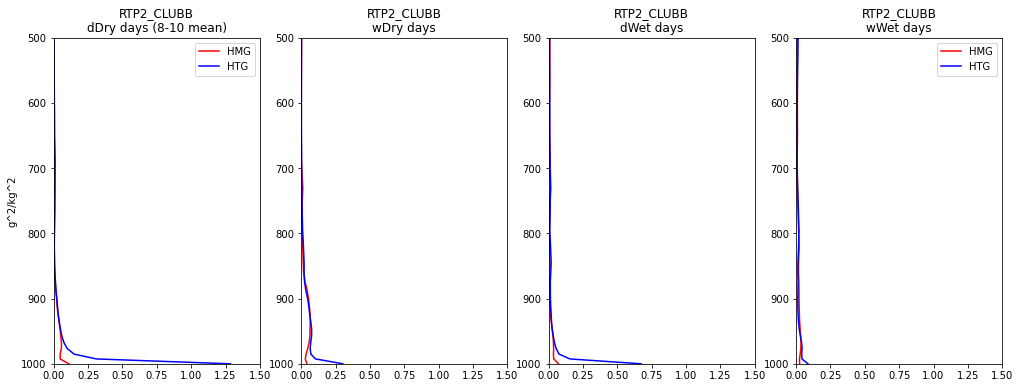

In [162]:
plotProfiles_timeOfDayMean(8, 10, 'RTP2_CLUBB', 500,
                           0.0, 1.5)

Means computed over the inclusive period of 8 to 10.


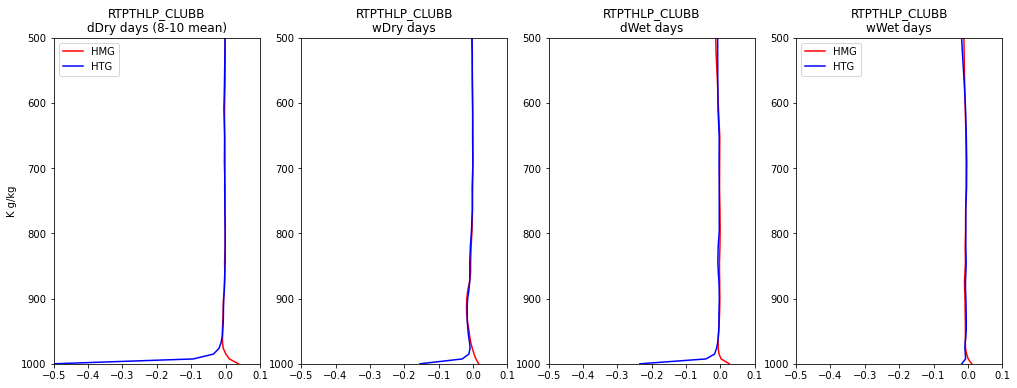

In [167]:
plotProfiles_timeOfDayMean(8, 10, 'RTPTHLP_CLUBB', 500,
                           -0.5, 0.1)

Means computed over the inclusive period of 8 to 10.


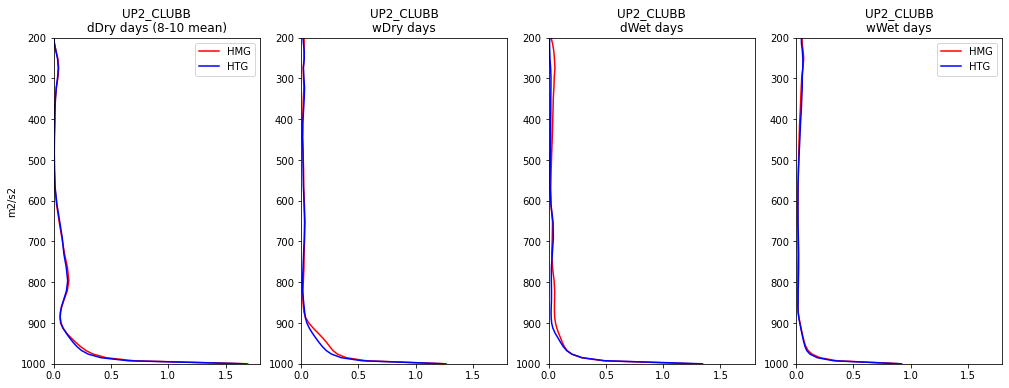

In [171]:
plotProfiles_timeOfDayMean(8, 10, 'UP2_CLUBB', 200,
                           0.0, 1.8)

Means computed over the inclusive period of 8 to 10.


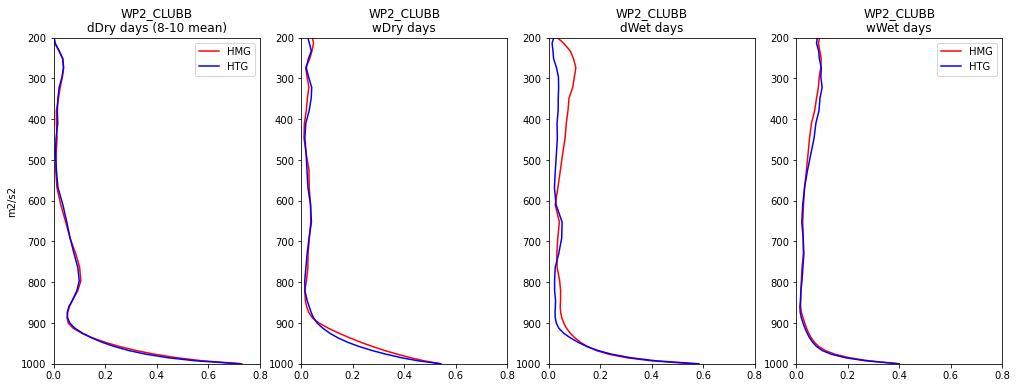

In [173]:
plotProfiles_timeOfDayMean(8, 10, 'WP2_CLUBB', 200,
                           0.0, 0.8)

Means computed over the inclusive period of 8 to 10.


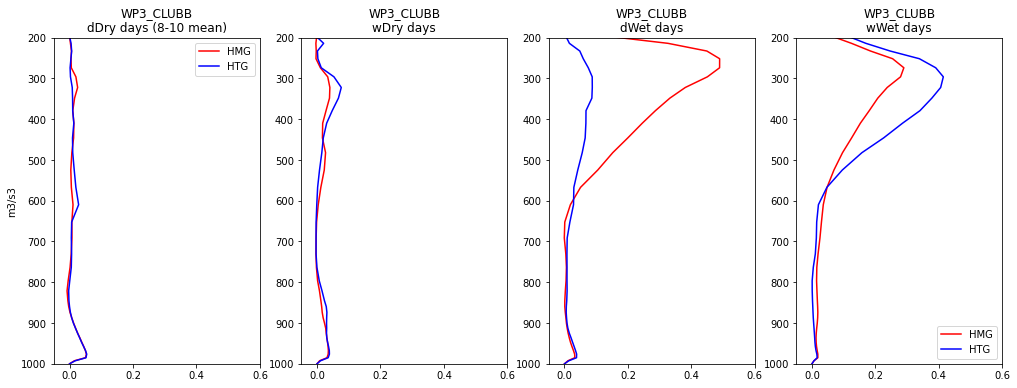

In [175]:
plotProfiles_timeOfDayMean(8, 10, 'WP3_CLUBB', 200,
                           -0.05, 0.6)

Means computed over the inclusive period of 8 to 10.


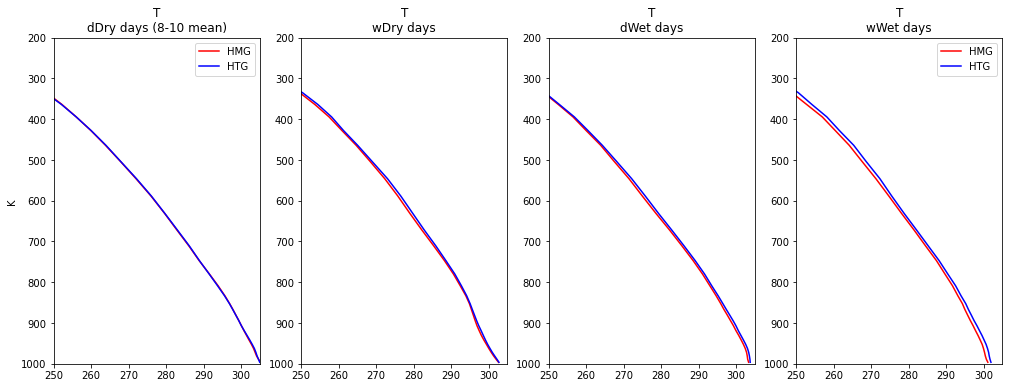

In [177]:
plotProfiles_timeOfDayMean(8, 10, 'T', 200,
                           250, 305)

Means computed over the inclusive period of 8 to 10.


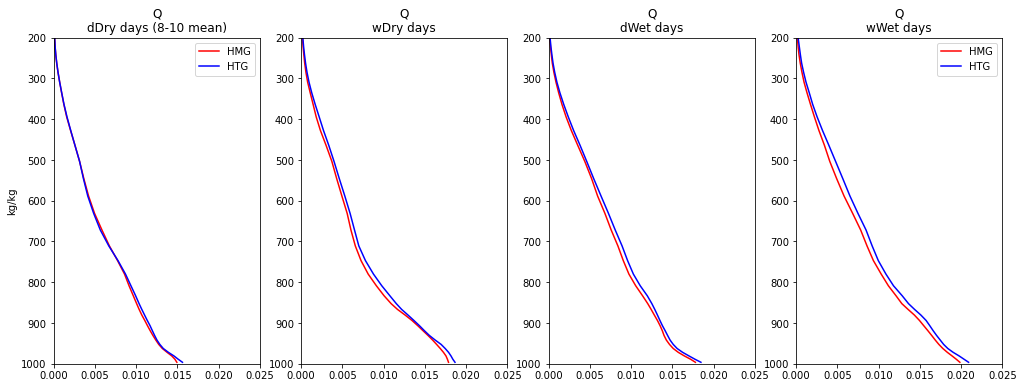

In [179]:
plotProfiles_timeOfDayMean(8, 10, 'Q', 200,
                           0.00, 0.025)

Means computed over the inclusive period of 8 to 10.


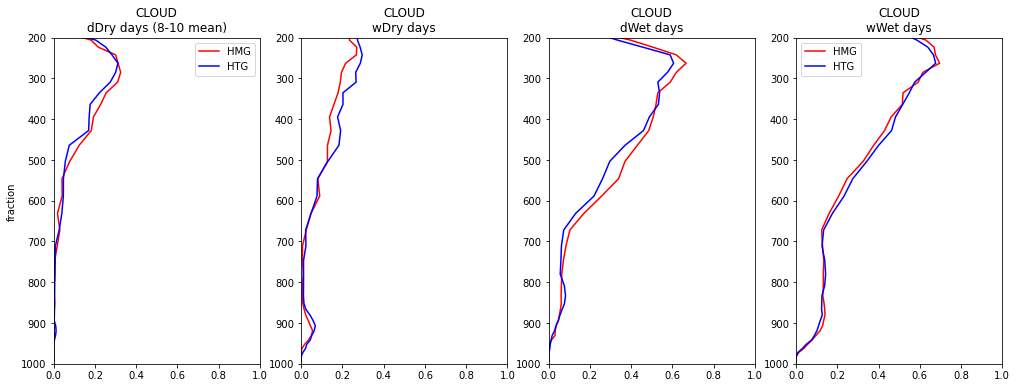

In [180]:
plotProfiles_timeOfDayMean(8, 10, 'CLOUD', 200,
                           0, 1)

#### Define days based on actual heterogeneity (i.e., std of patch LHFLX)